# Updated Baker Analysis

This is an update to the already existing project, in which I have attempted to predict Baker Mayfield's passing yards for the 2023-2024 season. In the foolowing project, we try to attempt to create a better performing model.

This time we will just focus on the statistical aspects of an exploratory analysis and will not showcase different aspects of Bakers career. This will be still available in the previouse notebook.

In [1]:
#!pip install torch torchvision torchaudio
#!pip install optuna plotly
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import normaltest
from scipy.stats import pearsonr, spearmanr,kendalltau,norm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, KFold,cross_val_score,learning_curve,LeaveOneOut
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error,mean_absolute_error,root_mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor
from feature_engine.encoding import MeanEncoder
from feature_engine.discretisation import DecisionTreeDiscretiser
from pingouin import partial_corr
import shap
import optuna
from optuna.samplers import GPSampler
from optuna.pruners import SuccessiveHalvingPruner
import optuna.visualization.matplotlib as optuna_matplotlib
import time
from xgboost import XGBRegressor
pd.set_option('future.no_silent_downcasting', True)

## Exploratory Analysis

In [2]:
df=pd.read_csv(r"C:\Users\gandj\OneDrive\Desktop\Case_Study\NFL\Baker_DataFrame.csv").iloc[:,1:]
#as we can see we do not have any missing data and all data types seem to be the appropriate ones
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Player             71 non-null     object 
 1   Tm                 71 non-null     object 
 2   Cmp                71 non-null     int64  
 3   Att                71 non-null     int64  
 4   Yds                71 non-null     int64  
 5   TD                 71 non-null     int64  
 6   Int                71 non-null     int64  
 7   Sk                 71 non-null     int64  
 8   Yds.1              71 non-null     int64  
 9   Lng                71 non-null     float64
 10  Rate               71 non-null     float64
 11  Home Game          71 non-null     int64  
 12  Opponent           71 non-null     object 
 13  Year               71 non-null     int64  
 14  # TopReceiver      71 non-null     int64  
 15  # TopRunningBacks  71 non-null     float64
dtypes: float64(3), int64(10), ob

In [3]:
#we can also drop the player and team, it can be beneficial to rename "Yds.1" to yards lost after sack, and we will make the value nagetive
df.rename(columns={'Yds.1':'Yards_Lost_After_Sack'},inplace=True)
df['Yards_Lost_After_Sack']=df['Yards_Lost_After_Sack']*-1
df['Avg_Yards']=df['Yds']/df['Cmp']
df.drop(['Player','Tm'],axis=1,inplace=True)
df.head()

Cmp  Att  Yds  TD  Int  Sk  Yards_Lost_After_Sack   Lng   Rate  Home Game  \
0   17   23  201   0    0   1                     -8  29.0  100.1          1   
1   21   41  295   2    2   2                    -16  59.0   70.7          0   
2   25   43  342   1    1   5                    -38  39.0   81.7          1   
3   22   46  238   1    2   5                    -24  32.0   52.6          1   
4   23   34  215   2    0   5                    -29  23.0  104.4          0   

  Opponent  Year  # TopReceiver  # TopRunningBacks  Avg_Yards  
0      NYJ  2018              1                0.0  11.823529  
1      OAK  2018              0                1.0  14.047619  
2      BAL  2018              3                0.0  13.680000  
3      LAC  2018              1                0.0  10.818182  
4      TAM  2018              1                0.0   9.347826

In [4]:
#we will need that def function later on for the predictions
def input_value(data,team,home):
    #getting all X features
    x_features=list(data.select_dtypes(exclude='object').columns)
    x_features.remove('Home Game')

    #getting the mean of the X features based on the team and if it is a home or road game
    df_avg_team_per=data.groupby(['Opponent','Home Game'])[x_features].mean().reset_index()
    #if the input for the home variable is 1 and based on team and home/road game status we get the numbers for the team when home/road status is 0
    if home==1 and len(df_avg_team_per[(df_avg_team_per['Opponent']==team) & (df_avg_team_per['Home Game']==home)])==0:
        return df_avg_team_per[(df_avg_team_per['Opponent']==team) & (df_avg_team_per['Home Game']==0)]
    #if the input for the home variable is 0 and based on team and home/road game status we get the numbers for the team when home/road status is 1
    elif home==0 and len(df_avg_team_per[(df_avg_team_per['Opponent']==team) & (df_avg_team_per['Home Game']==home)])==0:
        return df_avg_team_per[(df_avg_team_per['Opponent']==team) & (df_avg_team_per['Home Game']==1)]
    #if non of the previous conditions are meet just return the filtered dataframe
    else:
        return df_avg_team_per[(df_avg_team_per['Opponent']==team) & (df_avg_team_per['Home Game']==home)]

### Checking Linearity, Distribution & Outliers

In [5]:
X=df.drop(['Yds'],axis=1).copy()
y=df['Yds'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)

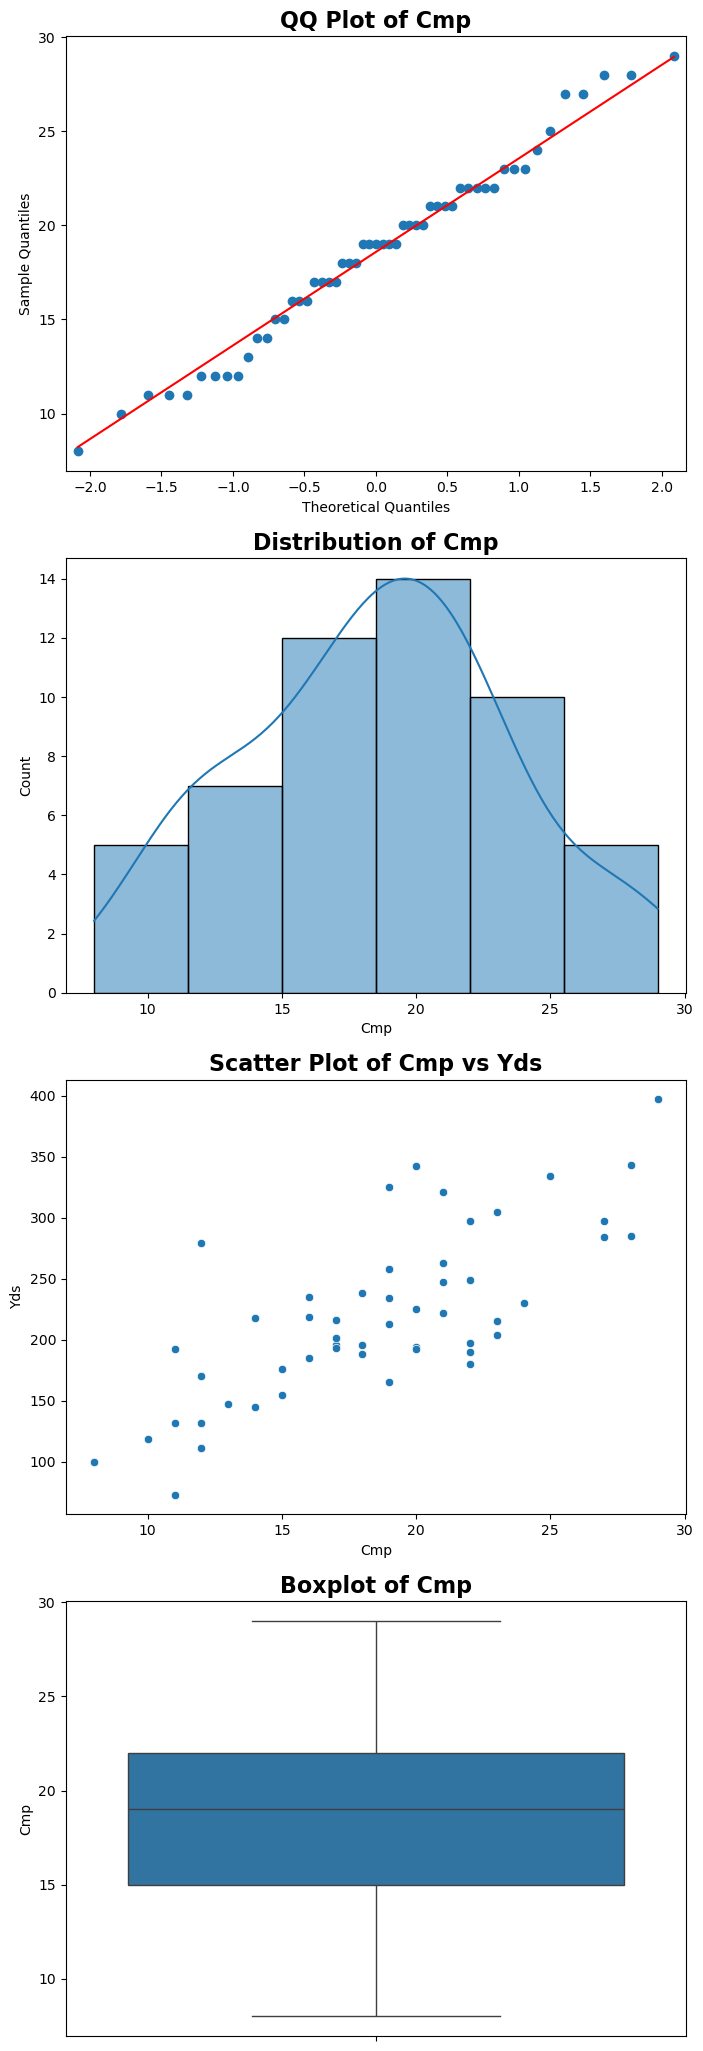

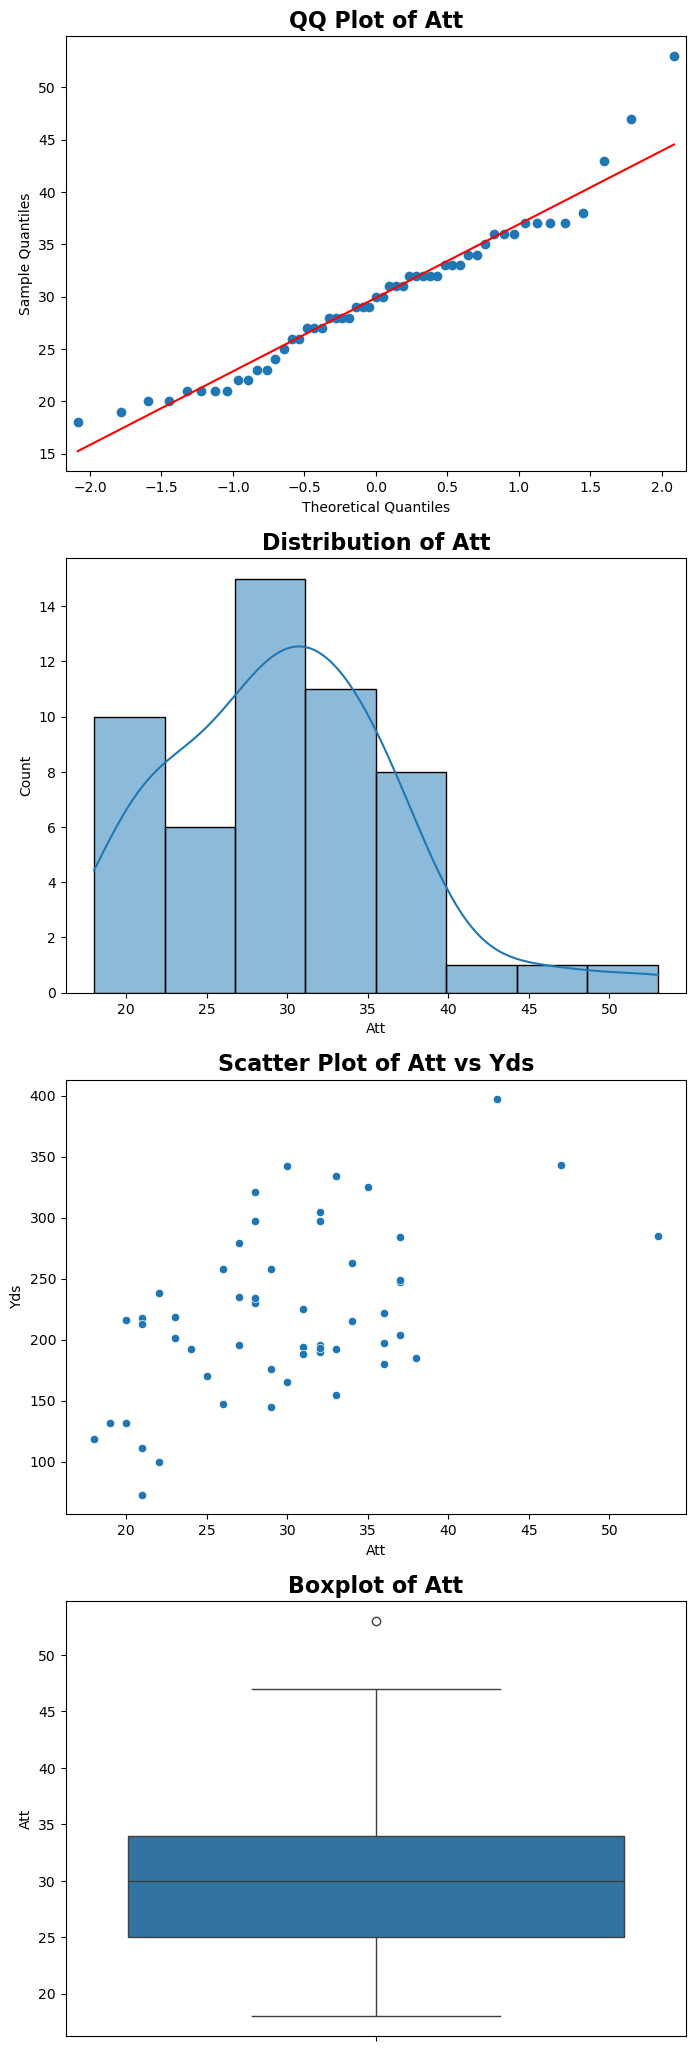

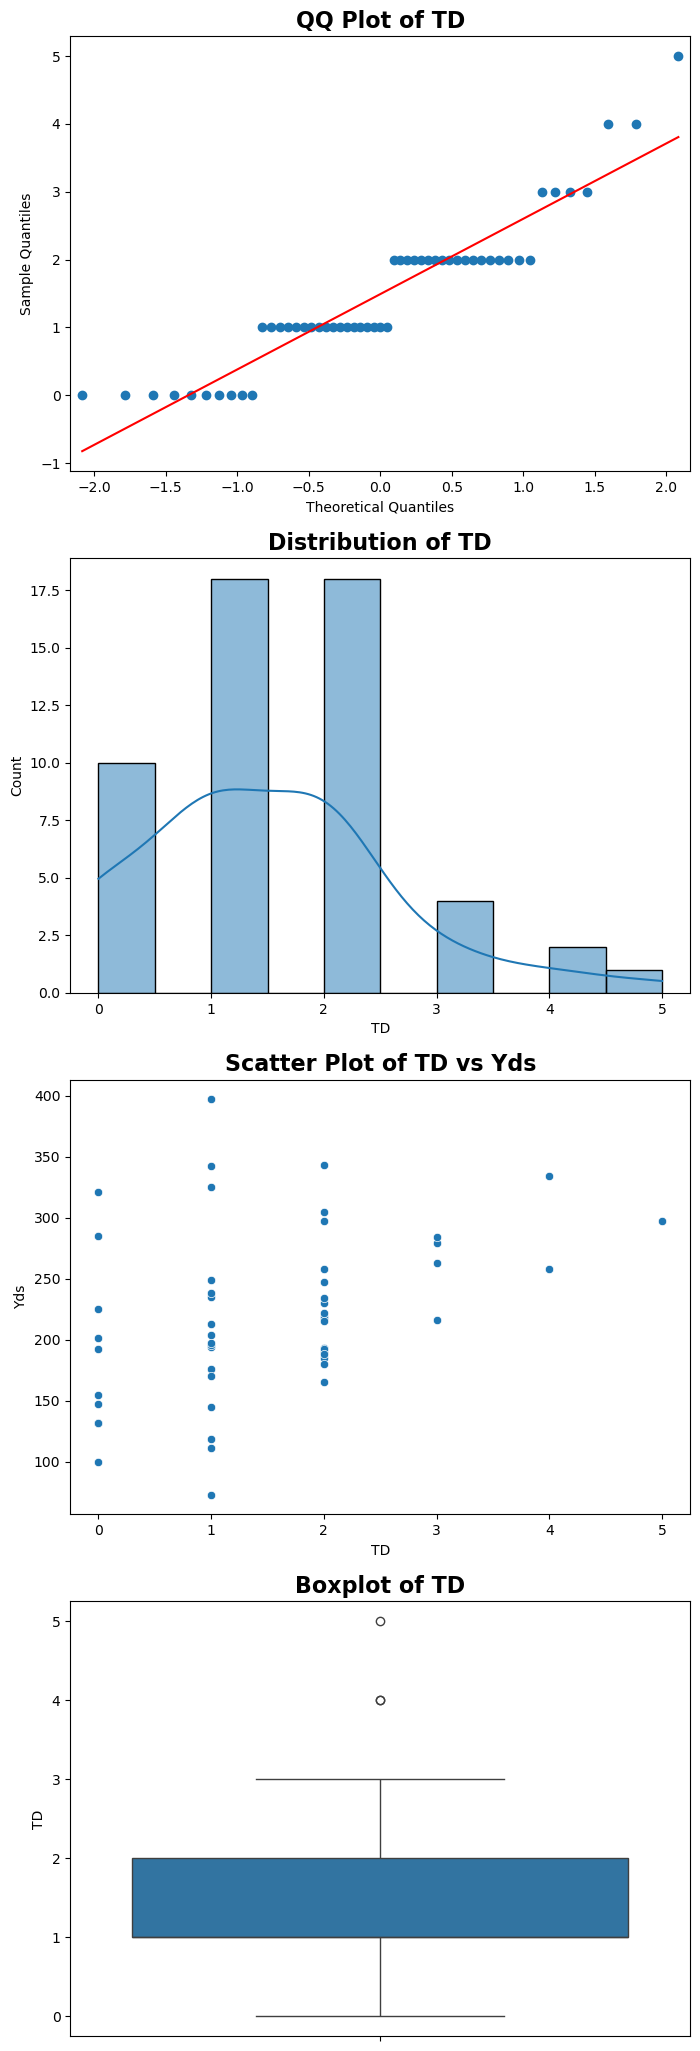

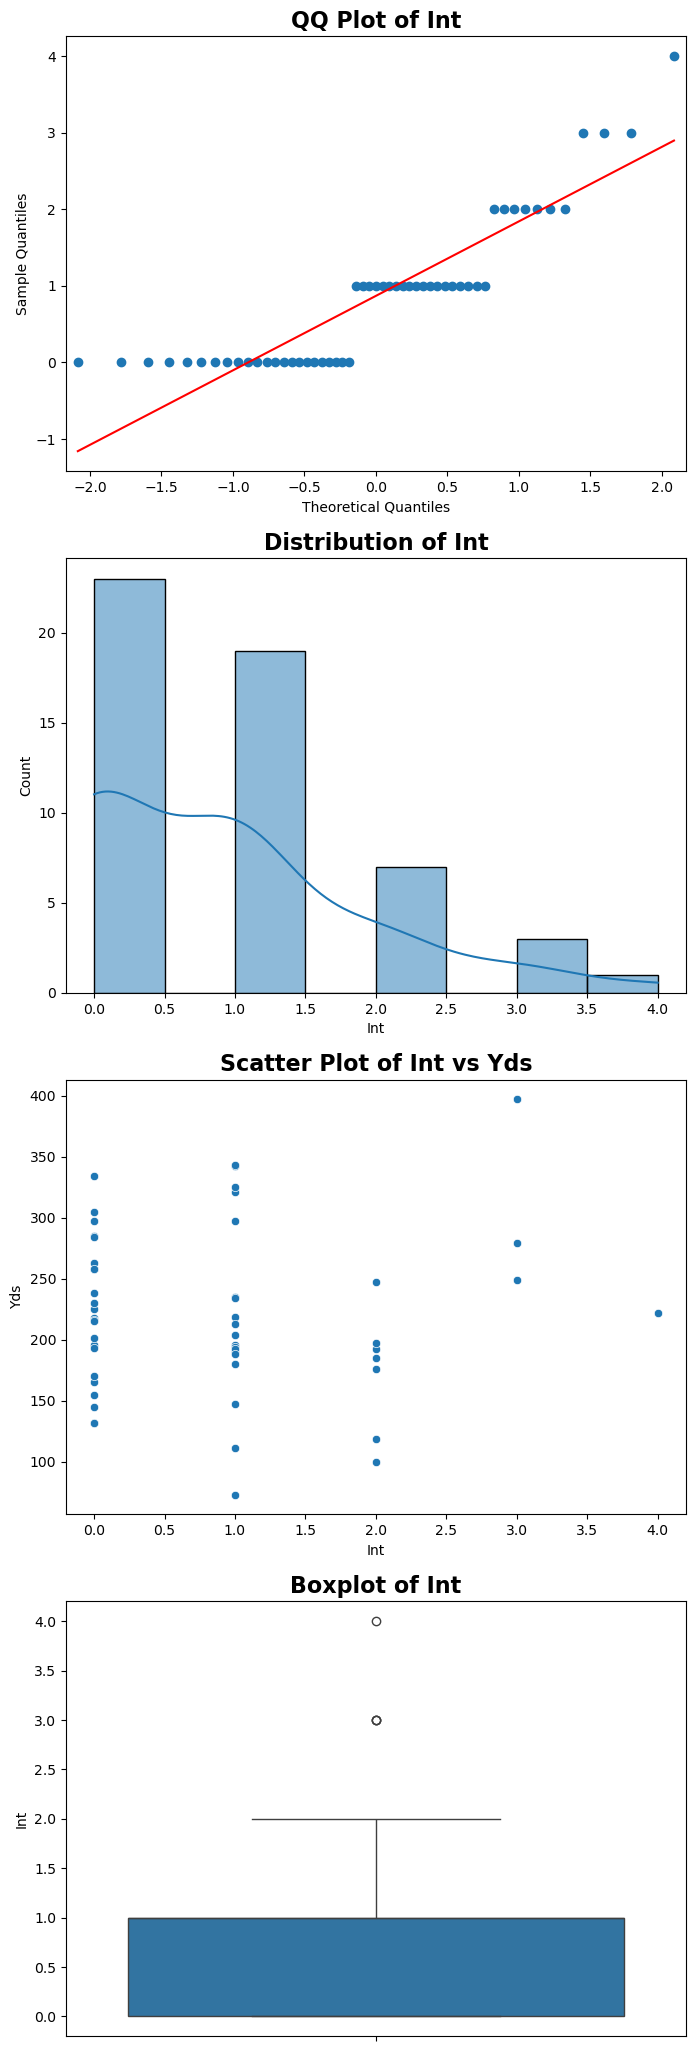

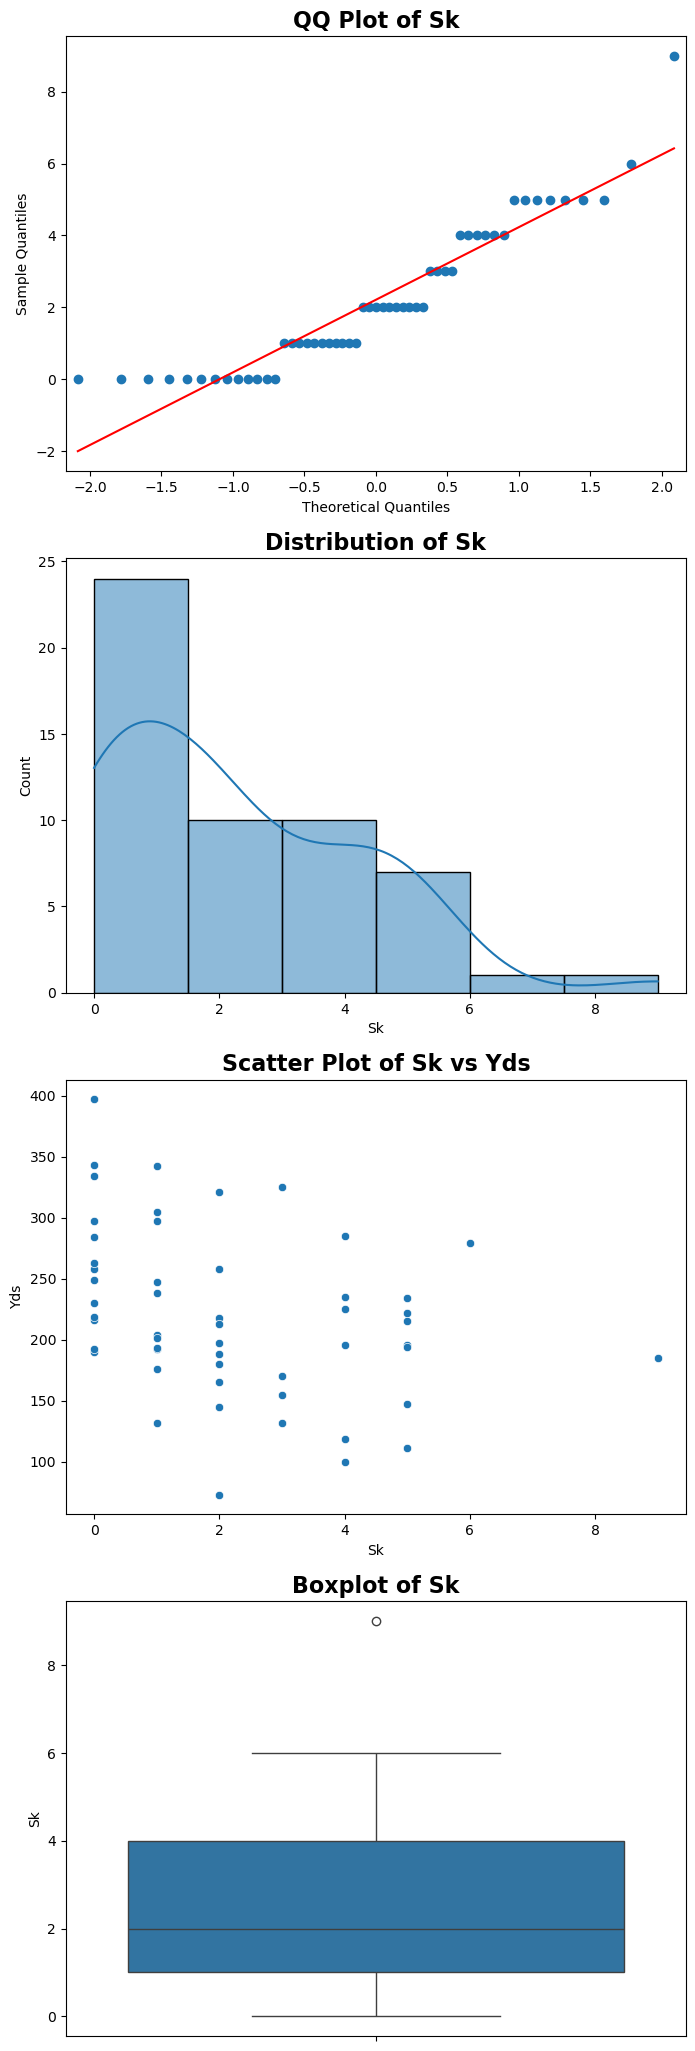

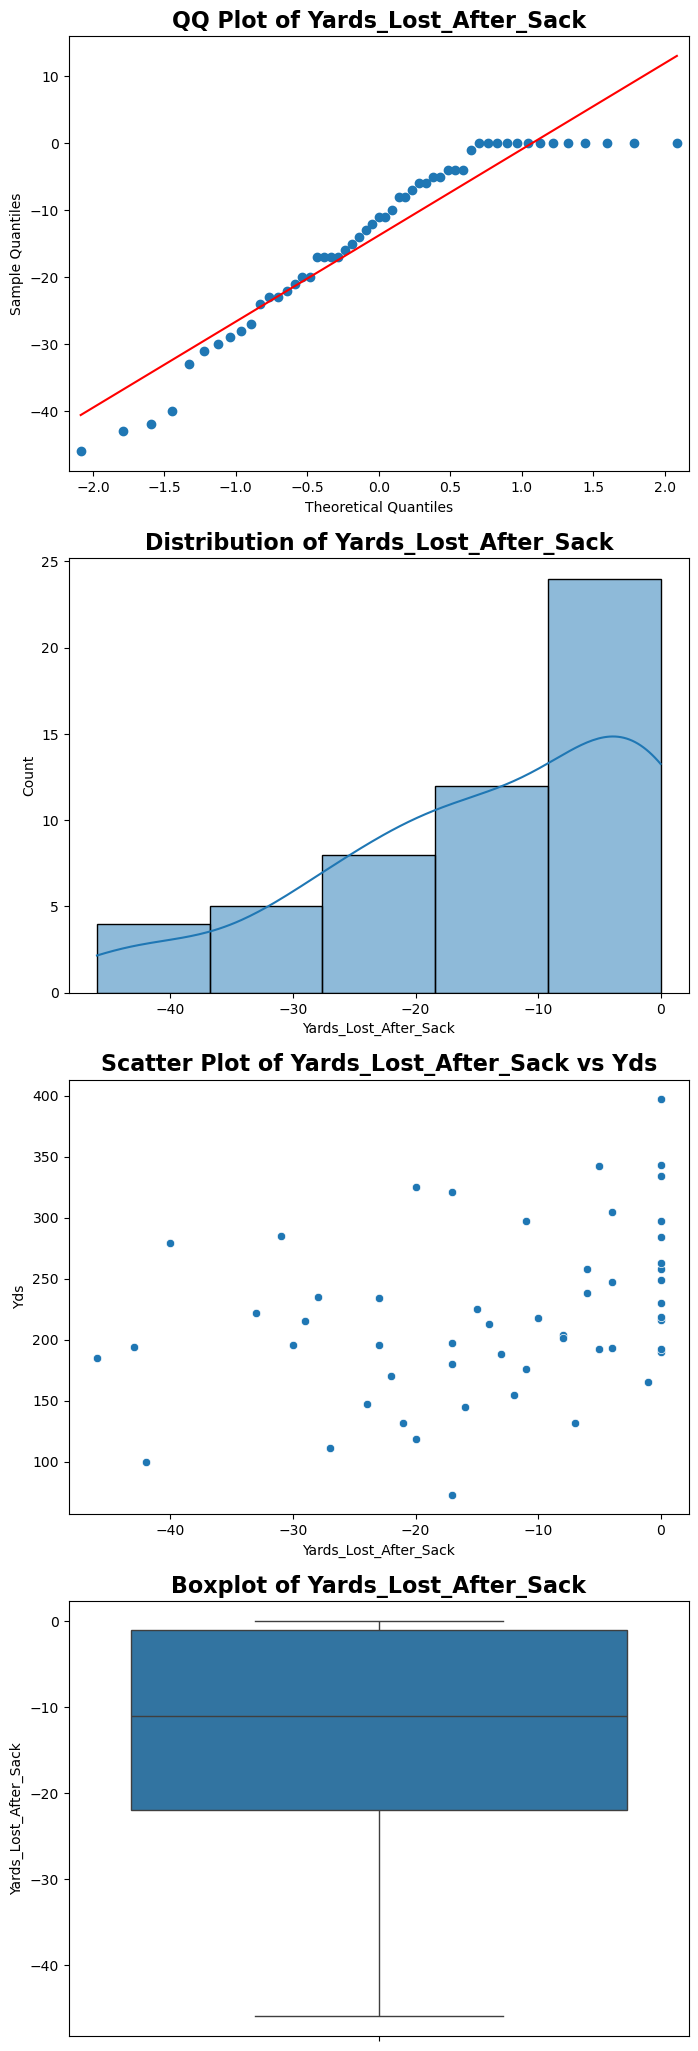

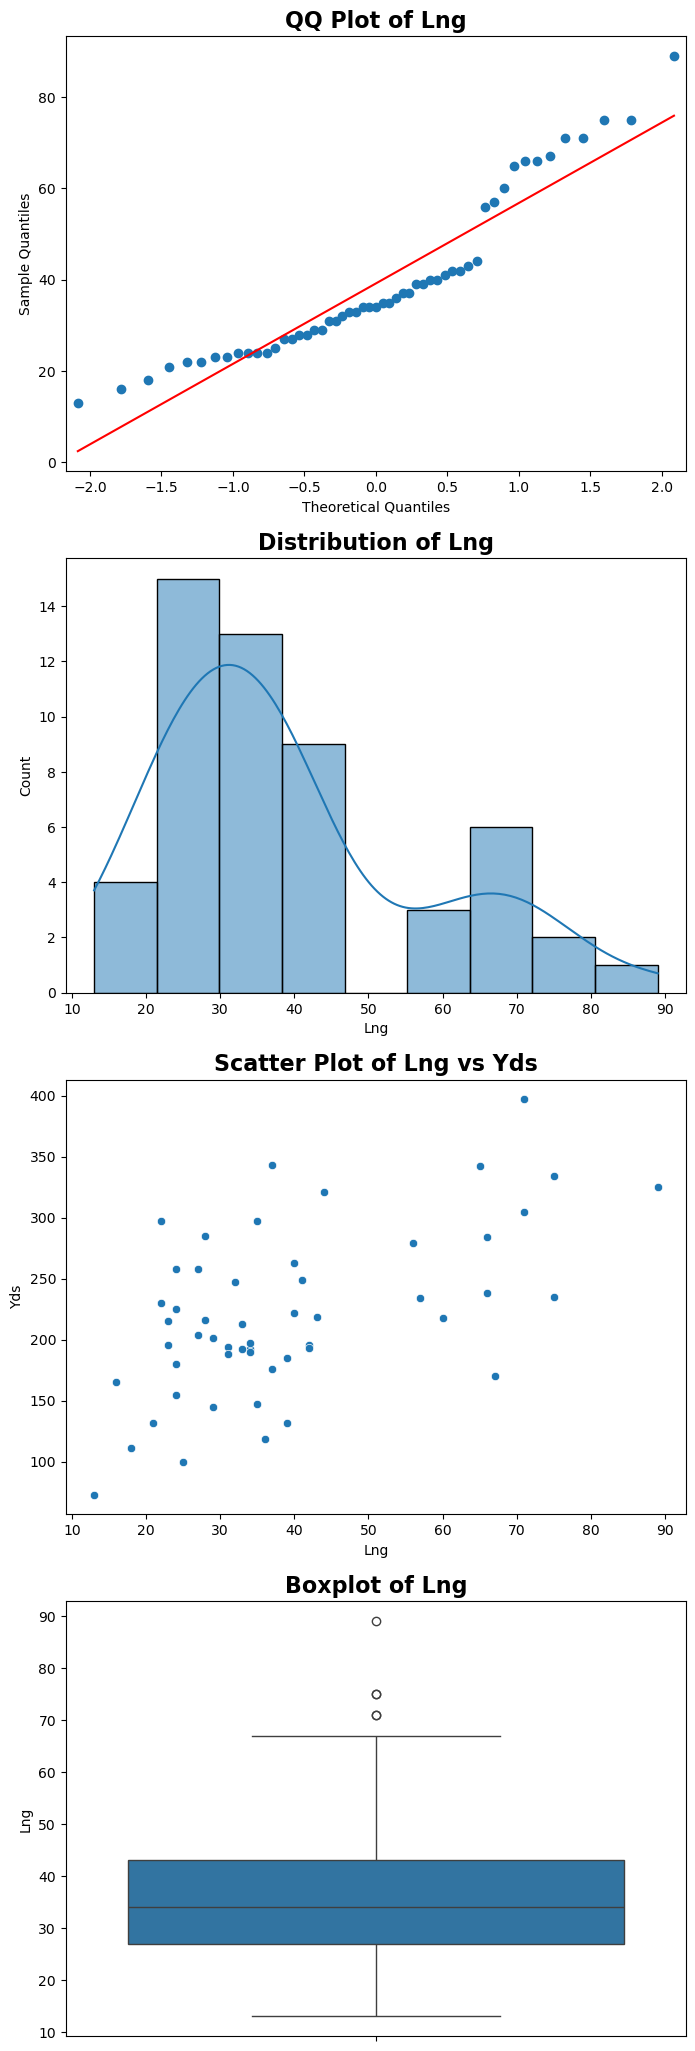

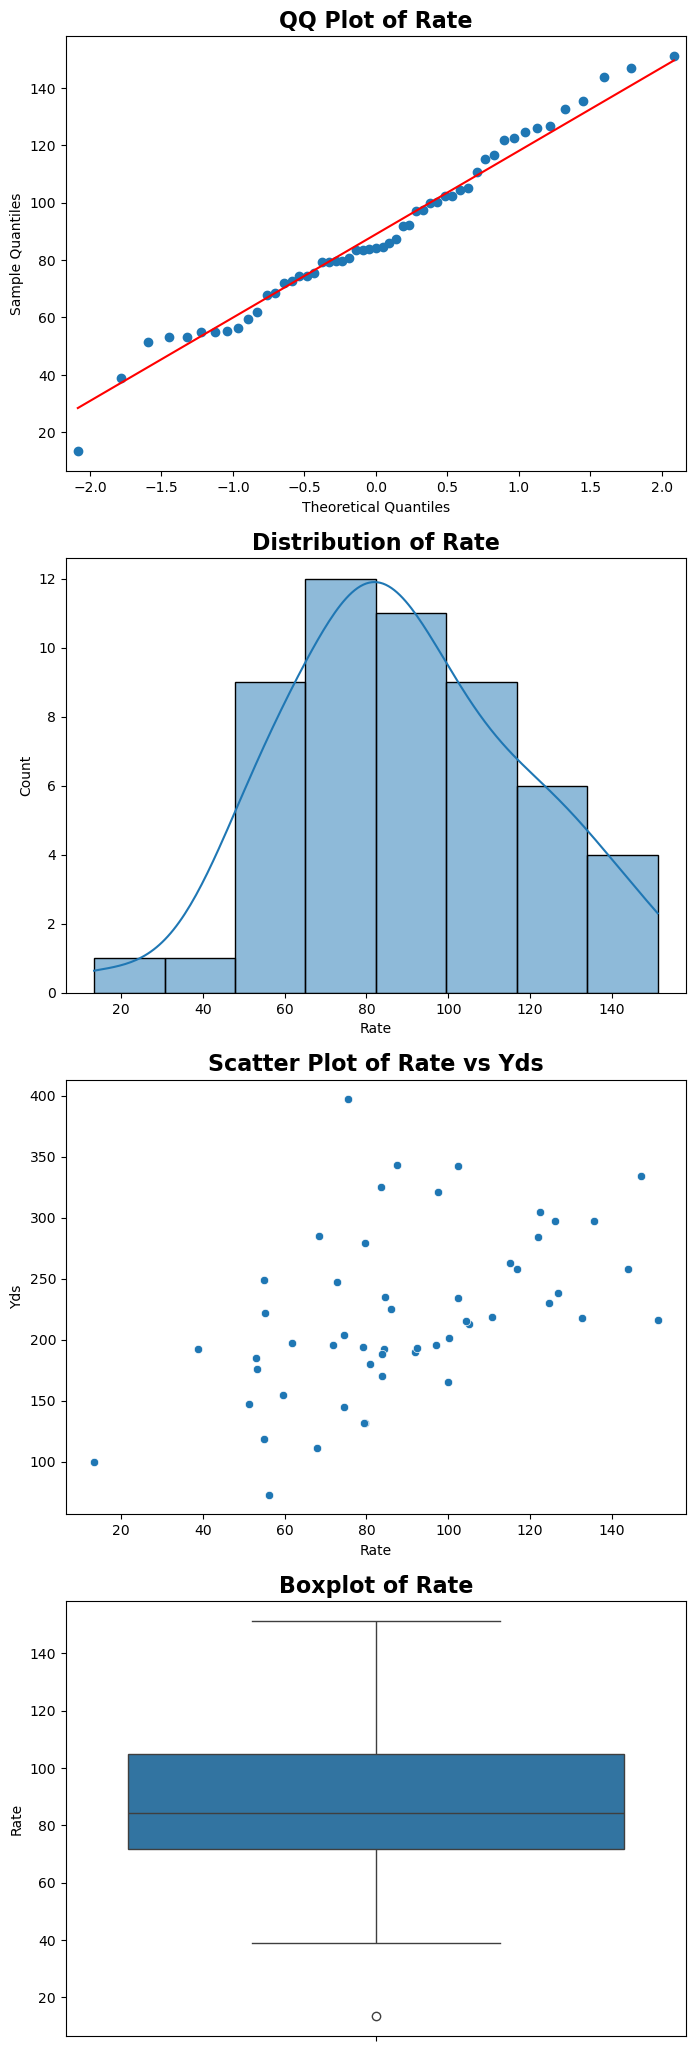

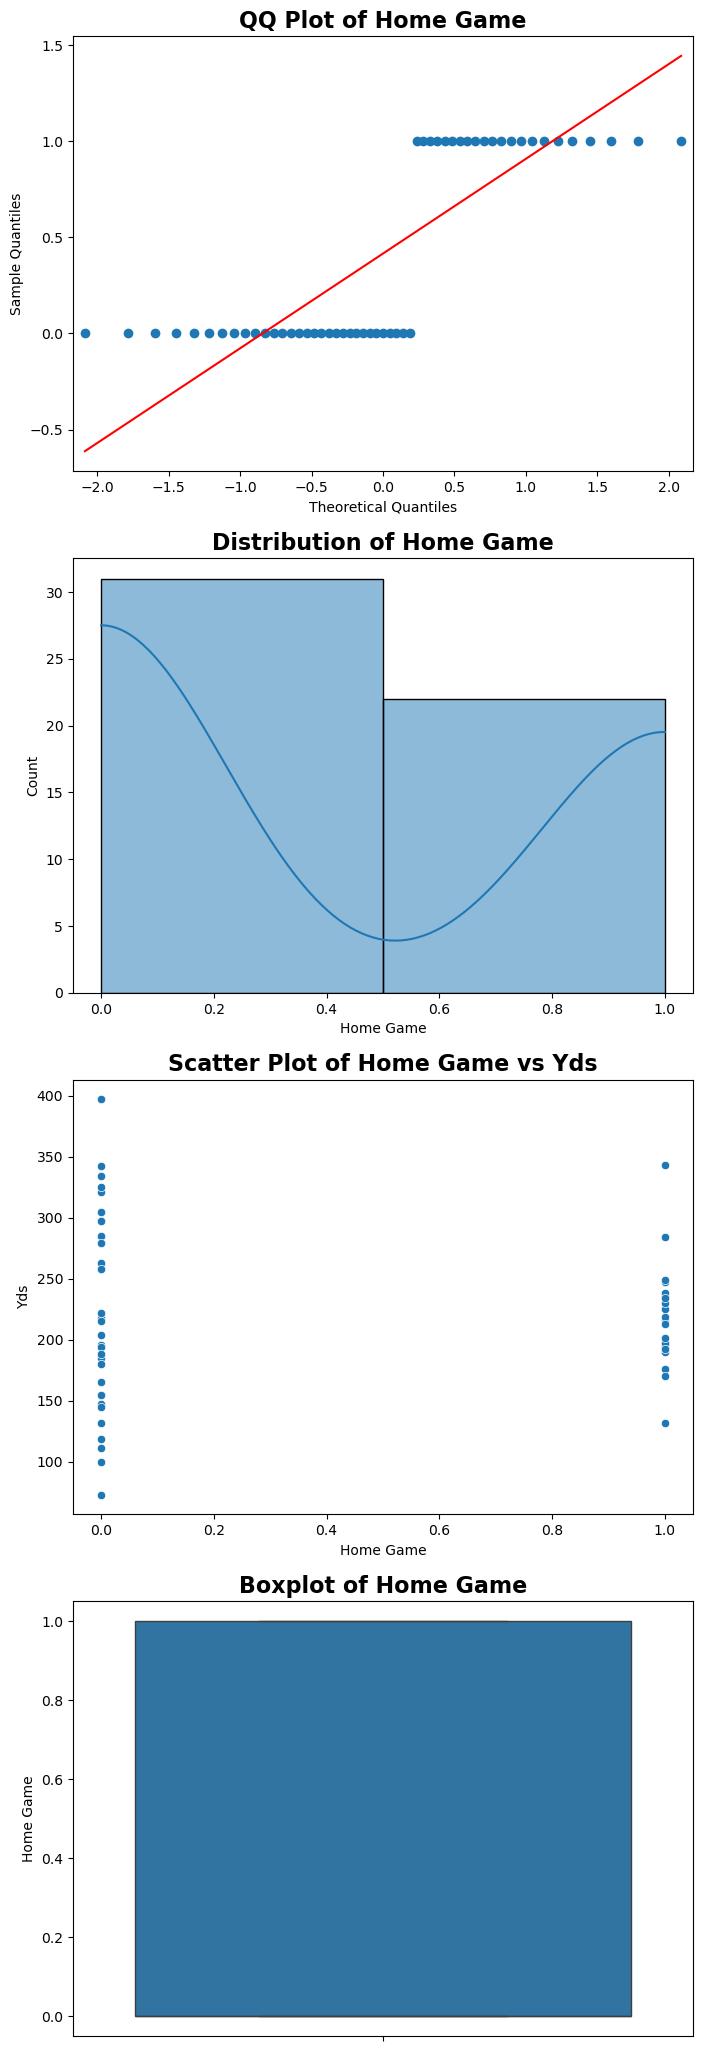

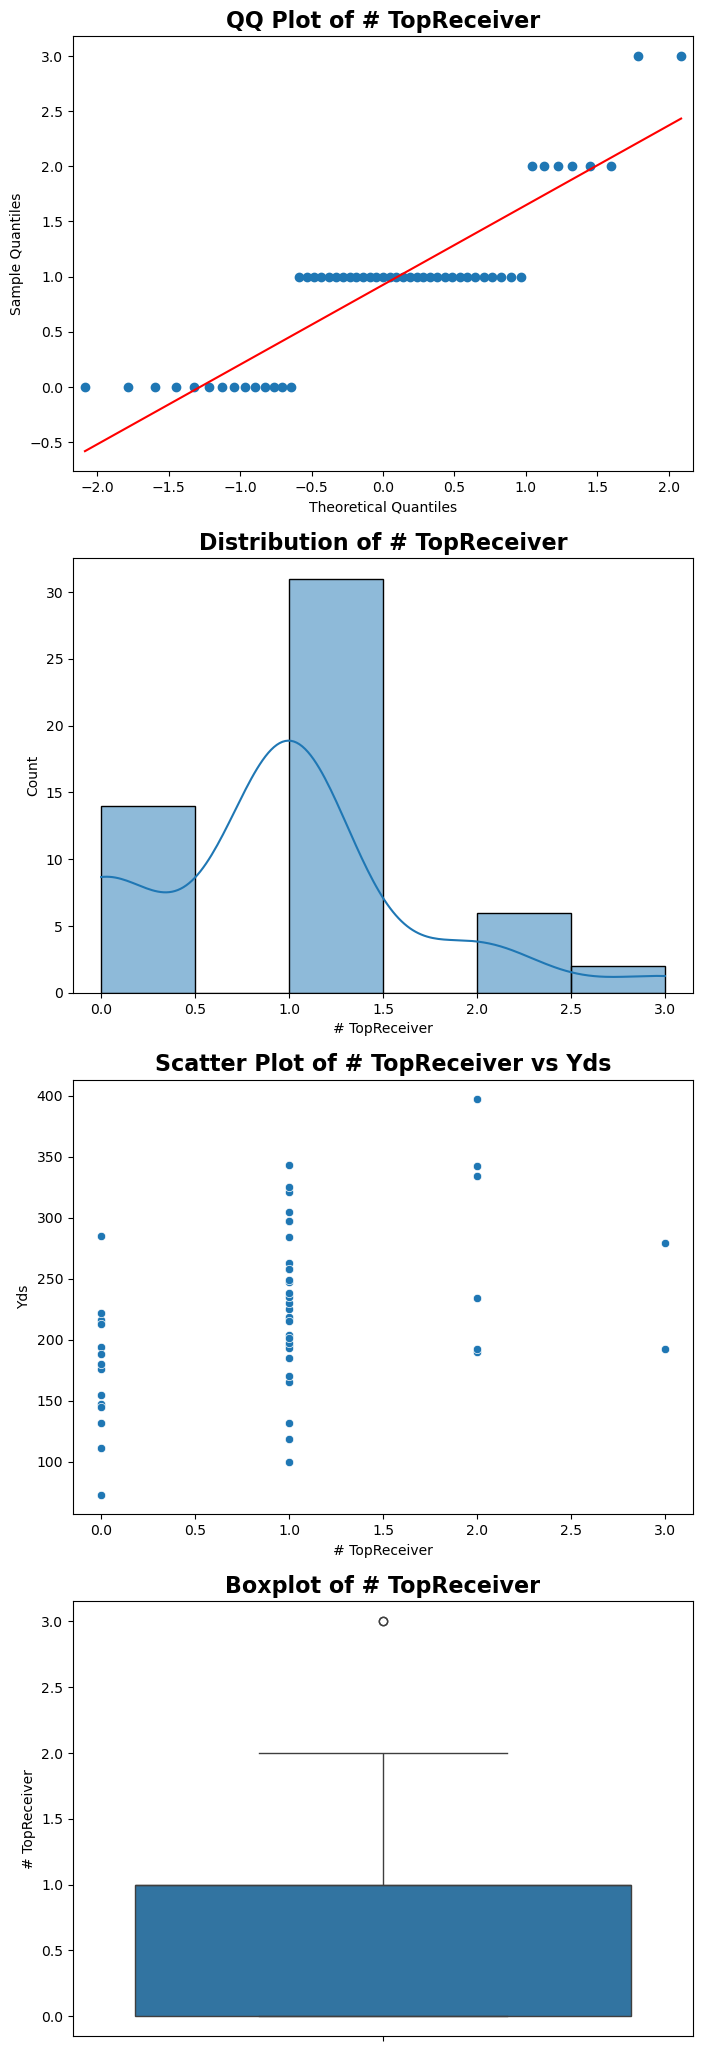

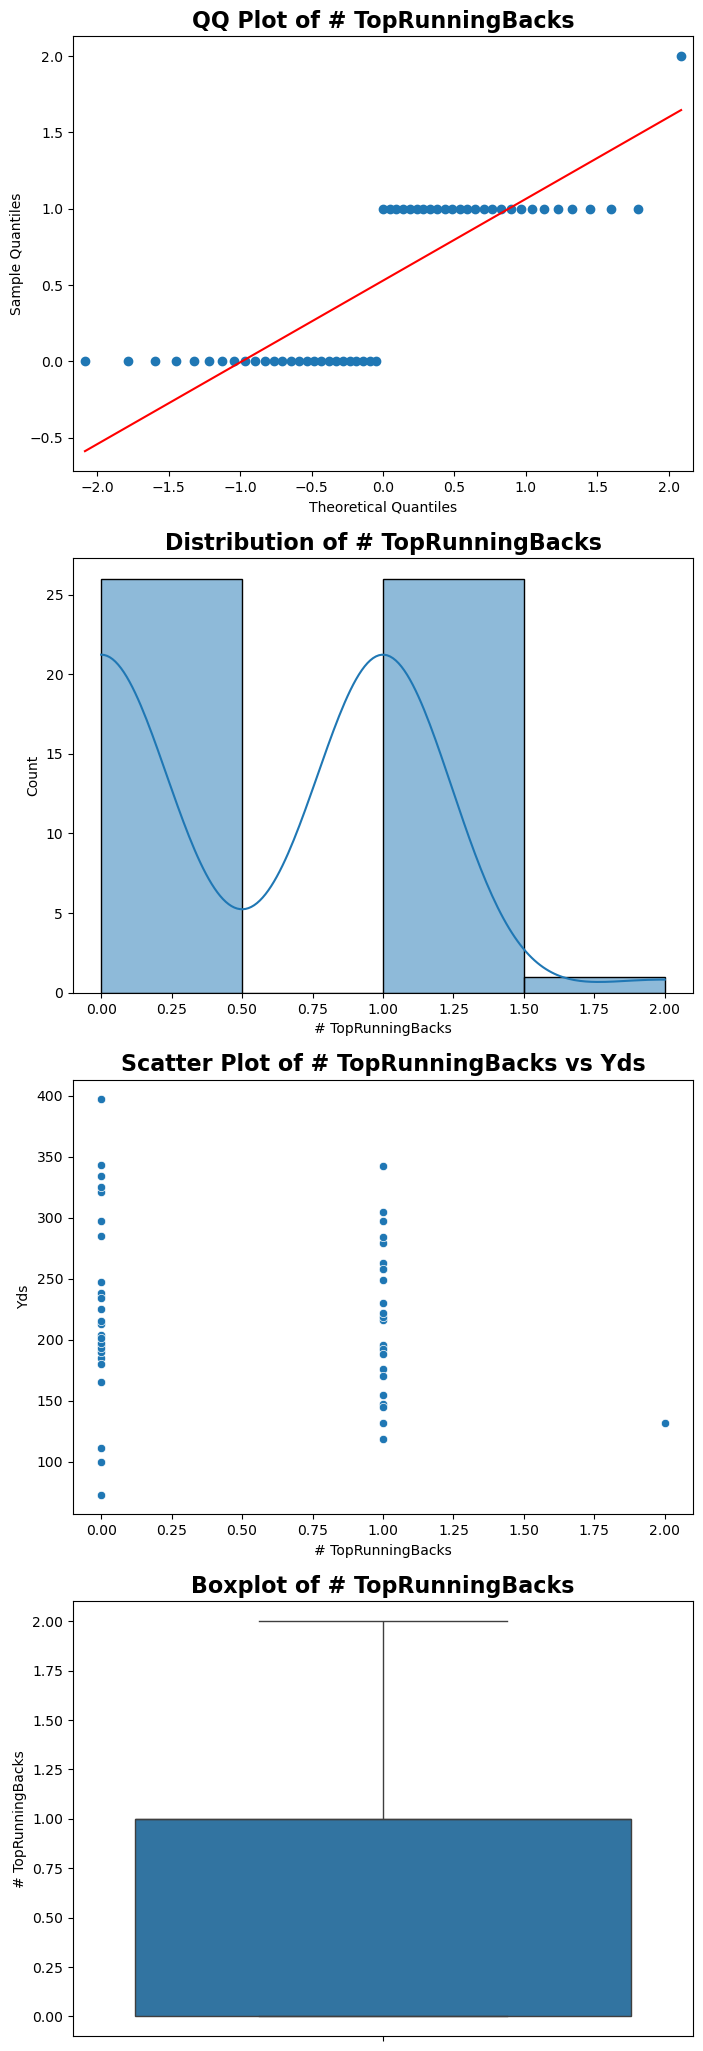

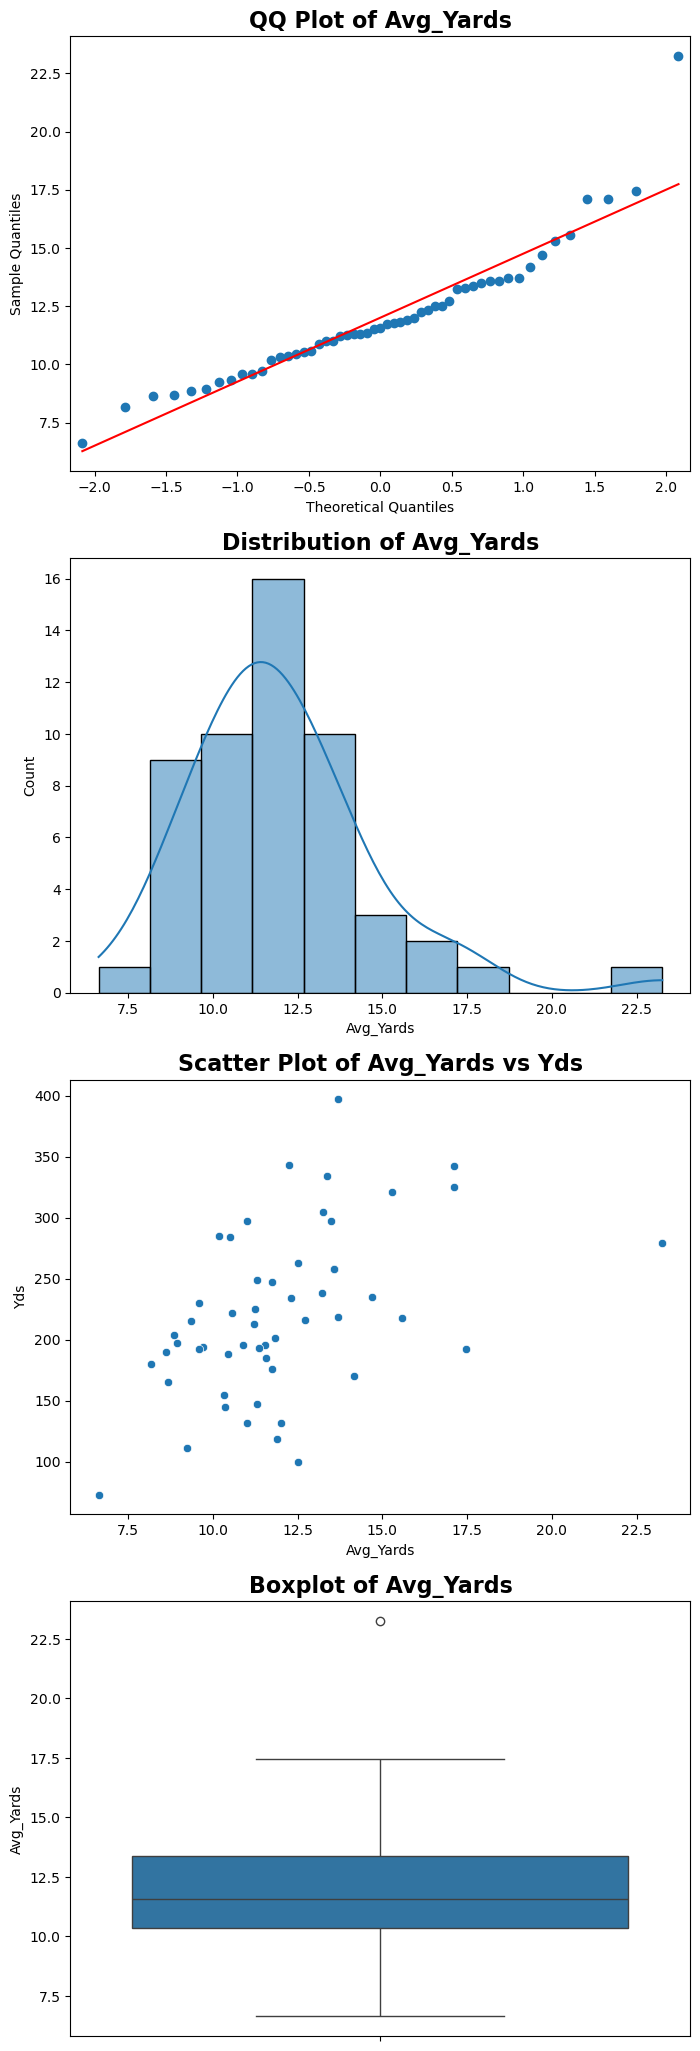

In [6]:
X_features=list(X_train.columns)
[X_features.remove(x) for x in ['Opponent','Year']]

#i => numerical value; x => input value for x
for i, x in enumerate(X_features):
    fig, axes = plt.subplots(4, 1, figsize=(8, 10))  #create a new figure for each variable
    plt.subplots_adjust(top=2.0,bottom=0.0)
    
    #qq plot
    sm.qqplot(X_train[x], line="s", ax=axes[0])
    axes[0].set_title(f"QQ Plot of {x}",size=16,fontweight='bold')

    #histogram
    sns.histplot(X_train[x], bins='fd', kde=True, ax=axes[1])
    axes[1].set_title(f"Distribution of {x}",size=16,fontweight='bold')

    #scatter Plot
    sns.scatterplot(x=X_train[x], y=y_train, ax=axes[2])
    axes[2].set_title(f"Scatter Plot of {x} vs Yds",size=16,fontweight='bold')

    #boxplot
    sns.boxplot(X_train[x],orient='v',ax=axes[3])
    axes[3].set_title(f"Boxplot of {x}",size=16,fontweight='bold')

Analysing the X features, we can see that we are dealing with a mix of distributions (normal, non-normal), that some features contain outliers and that almost no feature has a linear relationship with the with the y/target variable. In the feature engeenring section we will address the outliers. Knowing the characteristic of the X features is important for the feature selection process.

Text(0.5, 1.0, 'Boxplot of Yds')

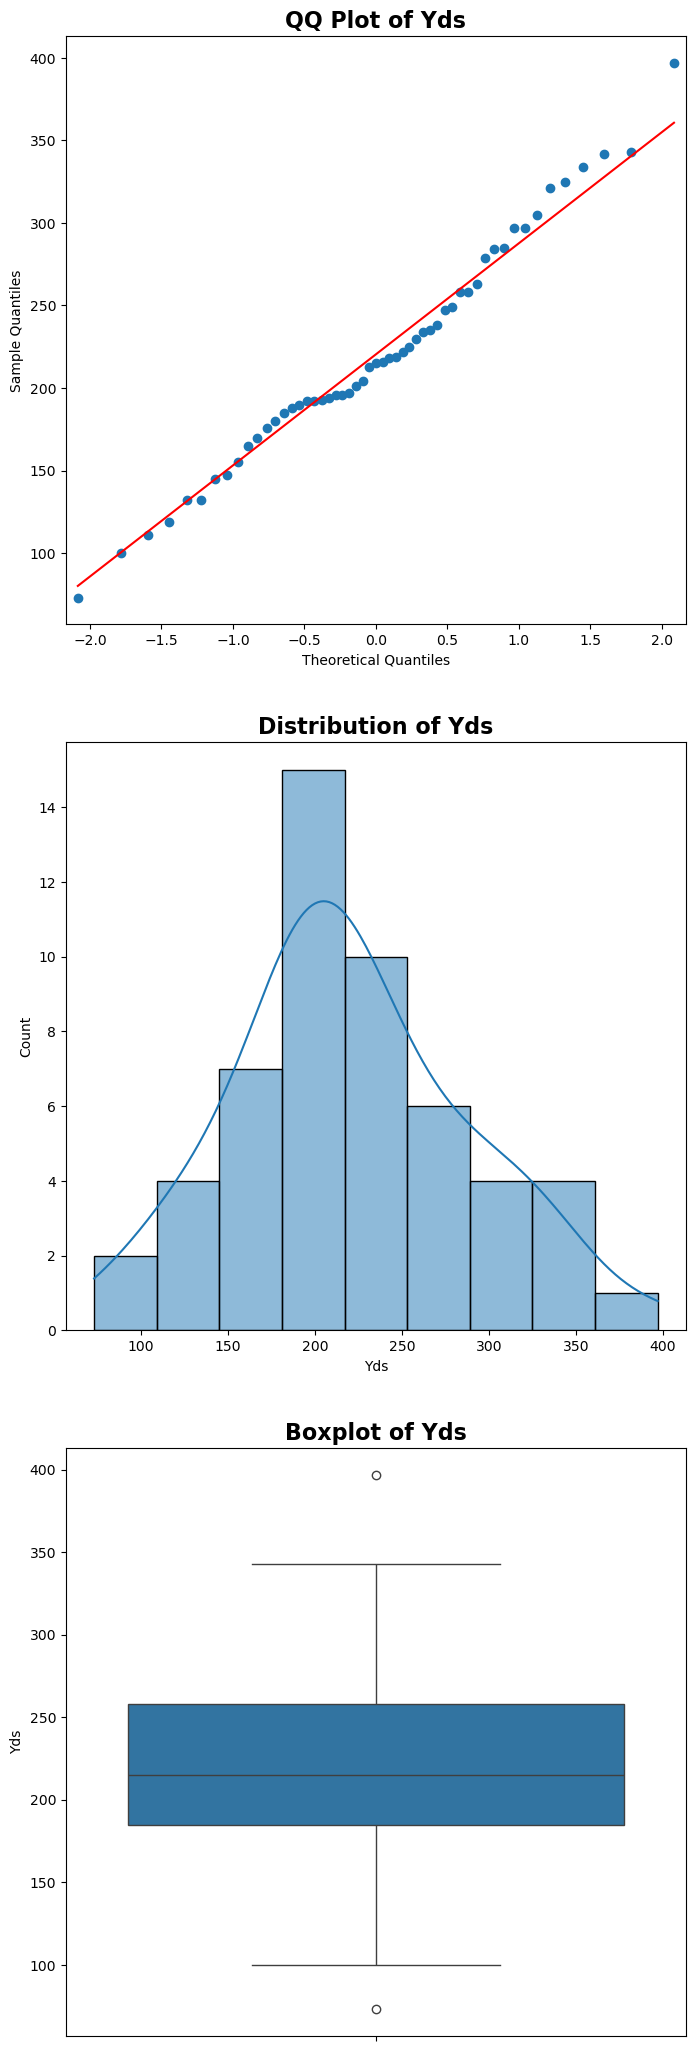

In [7]:
fig, axes = plt.subplots(3, 1, figsize=(8, 10))  #create a new figure for each variable
plt.subplots_adjust(top=2.0,bottom=0.0)

#qq plot
sm.qqplot(y_train, line='s', ax=axes[0])
axes[0].set_title(f"QQ Plot of Yds",size=16,fontweight='bold')

#histogram
sns.histplot(y_train, bins='fd', kde=True, ax=axes[1])
axes[1].set_title(f"Distribution of Yds",size=16,fontweight='bold')

#boxplot
sns.boxplot(y_train,orient='v',ax=axes[2])
axes[2].set_title(f"Boxplot of Yds",size=16,fontweight='bold')

The y feature is normally distributed but contains two outliers.

The choice of methods for the feature engineering depends strongly on the characteristics of the data. In the previous step we have analysed/determined the characteristics of the data with a visual approach, but for future retraining, it is more beneficial to use the statistical/mathematical approach. Based on the type of distribution we will select the appropriate feature engineering.

### Handling Categorical Values

The only categorical value we need to deal with is "Opponent", to choose the right approach we first need to see how often each opponent appears and how the feature interacts with the y feature yds.

In [8]:
#number of Baker's matchups
(X_train['Opponent'].value_counts()/len(X_train))*100

Opponent
PIT    15.094340
CIN    13.207547
BAL     7.547170
HOU     5.660377
NYJ     5.660377
NYG     3.773585
GNB     3.773585
KAN     3.773585
ARI     3.773585
NWE     3.773585
SEA     3.773585
LAC     3.773585
DEN     3.773585
TAM     1.886792
NOR     1.886792
IND     1.886792
MIN     1.886792
ATL     1.886792
CAR     1.886792
DET     1.886792
CLE     1.886792
SFO     1.886792
TEN     1.886792
DAL     1.886792
JAX     1.886792
Name: count, dtype: float64

<Axes: xlabel='Opponent'>

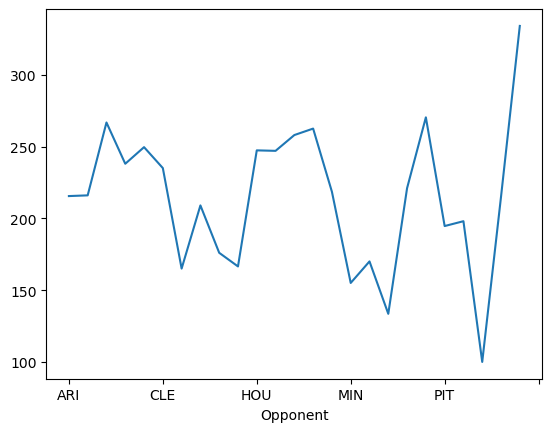

In [9]:
y_train.groupby(X_train['Opponent']).mean().plot()

In [10]:
def find_non_rare_labels(df,feat,tolerance):
    temp=df.groupby([feat])[feat].count()/len(df)
    non_rare=[x for x in temp.loc[temp>tolerance].index.values]
    return non_rare

def rare_encoding(train,test,feat,tolerance):
    X_train_dis=train.copy()
    X_test_dis=test.copy()

    frequ_cat=find_non_rare_labels(X_train_dis,feat,tolerance)
    X_train_dis[feat]=np.where(X_train_dis[feat].isin(frequ_cat),X_train_dis[feat], 'None Conference')
    X_test_dis[feat]=np.where(X_test_dis[feat].isin(frequ_cat),X_test_dis[feat], 'None Conference')
    return X_train_dis,X_test_dis

X_train_dis,X_test_dis=rare_encoding(X_train,X_test,'Opponent',0.05)

In [11]:
(X_train_dis['Opponent'].value_counts()/len(X_train))*100

Opponent
None Conference    52.830189
PIT                15.094340
CIN                13.207547
BAL                 7.547170
NYJ                 5.660377
HOU                 5.660377
Name: count, dtype: float64

In [12]:
X_train_dis['Opponent'].value_counts()

Opponent
None Conference    28
PIT                 8
CIN                 7
BAL                 4
NYJ                 3
HOU                 3
Name: count, dtype: int64

<Axes: xlabel='Opponent'>

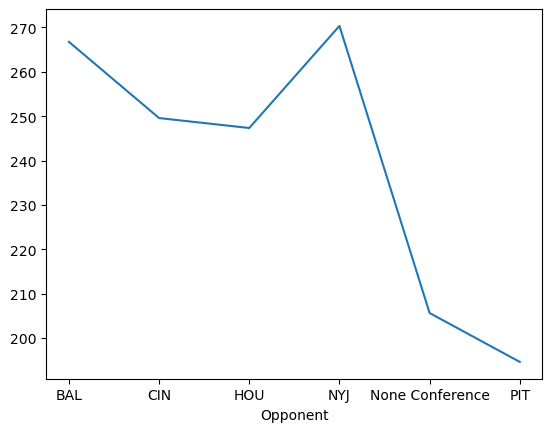

In [13]:
#we can observe a some kind of monotonic relationship between opponents and yds
y_train.groupby(X_train_dis['Opponent']).mean().plot()

In [14]:
#turning teh string values into numeric (ordinal) values
encoded_opponents = X_train_dis['Opponent'].astype('category').cat.codes
#
print(f"{'Monotonic Relationship Exists' if kendalltau(encoded_opponents, y_train)[1] <= 0.05 else 'Monotonic Relationship Does Not Exists'}")

Monotonic Relationship Exists


After applying the discretization of the categorical feature, we obtain a kind of monotonic relationship. Based on that information we will use mean encoding. We do not have enough data points for frequency encoding and one hot encoding would create too many columns.

In [15]:
meanec=MeanEncoder(variables=['Opponent'])
meanec.fit(X_train_dis,y_train)
X_train_mc=meanec.transform(X_train_dis)
X_test_mc=meanec.transform(X_test_dis)

### Addressing Continous & Discrete Values

Before we check for outliers, we will check the cardinality of the continuous and discrete values of the X features. We do this to deal with outliers and try to avoid exposing our model to an underrepresented value that our model might struggle with.

In [16]:
X_feat_dis=list(X_train_mc.columns)
X_feat_dis.remove('Opponent')
for x in X_feat_dis:
    print((X_train_mc[x].value_counts()/len( X_train_mc[x]))*100)
    print('\n')

Cmp
19    11.320755
22     9.433962
20     7.547170
21     7.547170
12     7.547170
17     7.547170
11     5.660377
18     5.660377
16     5.660377
23     5.660377
27     3.773585
15     3.773585
28     3.773585
14     3.773585
24     1.886792
8      1.886792
10     1.886792
13     1.886792
25     1.886792
29     1.886792
Name: count, dtype: float64


Att
32    9.433962
37    7.547170
28    7.547170
21    7.547170
27    5.660377
31    5.660377
29    5.660377
36    5.660377
33    5.660377
20    3.773585
22    3.773585
26    3.773585
23    3.773585
30    3.773585
34    3.773585
53    1.886792
19    1.886792
25    1.886792
24    1.886792
18    1.886792
38    1.886792
47    1.886792
35    1.886792
43    1.886792
Name: count, dtype: float64


TD
1    33.962264
2    33.962264
0    18.867925
3     7.547170
4     3.773585
5     1.886792
Name: count, dtype: float64


Int
0    43.396226
1    35.849057
2    13.207547
3     5.660377
4     1.886792
Name: count, dtype: float64


Sk
0    24.528302
1 

Looking at the cardinality of the different continuous and discrete values, we conclude that we need to discretise the discrete values. The features we are referring to are "TD", "Int", "Sk", "# TopReceiver" and "# TopRunningBacks". Discretizing these feature, we will need a method which addresses the characteristic of the data, all these discrete values are skewed to the right. The discritization tree allows us to address the skewness and create the right number of groups.

In [17]:
tree_disc = DecisionTreeDiscretiser(cv=5, scoring="neg_root_mean_squared_error", regression=True, variables=['TD','Int','Sk','# TopReceiver','# TopRunningBacks'],random_state=101)
X_train_dct = tree_disc.fit_transform(X_train_mc, y_train)
X_test_dct = tree_disc.transform(X_test_mc)

In [18]:
X_train_dct.head()

Cmp  Att          TD    Int          Sk  Yards_Lost_After_Sack   Lng  \
26   11   24  189.000000  215.0  249.958333                     -5  34.0   
70   13   26  189.000000  215.0  195.965517                    -24  35.0   
17   20   30  210.000000  215.0  249.958333                     -5  65.0   
25   18   32  210.000000  215.0  195.965517                    -23  23.0   
33   19   30  226.722222  215.0  195.965517                     -1  16.0   

     Rate  Home Game    Opponent  Year  # TopReceiver  # TopRunningBacks  \
26   38.9          1  249.571429  2019     270.000000         217.153846   
70   51.3          0  205.642857  2022     174.071429         217.153846   
17  102.4          0  266.750000  2019     270.000000         217.153846   
25   71.9          0  194.625000  2019     228.548387         227.076923   
33  100.0          0  205.642857  2020     228.548387         227.076923   

    Avg_Yards  
26  17.454545  
70  11.307692  
17  17.100000  
25  10.888889  
33   8.684211

In [19]:
X_feat_dis=list(X_train_dct.columns)
X_feat_dis.remove('Opponent')
for x in X_feat_dis:
    print((X_train_dct[x].value_counts()/len( X_train_mc[x]))*100)
    print('\n')

Cmp
19    11.320755
22     9.433962
20     7.547170
21     7.547170
12     7.547170
17     7.547170
11     5.660377
18     5.660377
16     5.660377
23     5.660377
27     3.773585
15     3.773585
28     3.773585
14     3.773585
24     1.886792
8      1.886792
10     1.886792
13     1.886792
25     1.886792
29     1.886792
Name: count, dtype: float64


Att
32    9.433962
37    7.547170
28    7.547170
21    7.547170
27    5.660377
31    5.660377
29    5.660377
36    5.660377
33    5.660377
20    3.773585
22    3.773585
26    3.773585
23    3.773585
30    3.773585
34    3.773585
53    1.886792
19    1.886792
25    1.886792
24    1.886792
18    1.886792
38    1.886792
47    1.886792
35    1.886792
43    1.886792
Name: count, dtype: float64


TD
210.000000    33.962264
226.722222    33.962264
189.000000    18.867925
260.500000     7.547170
296.000000     3.773585
297.000000     1.886792
Name: count, dtype: float64


Int
215.00    92.45283
286.75     7.54717
Name: count, dtype: float64


Sk


### Checking Distribution & Outliers statistically
We will use D'Agostion's K2 (Tests for Skewness & Kurtosis) to determine if a feature follows a normal and non-normal distribution. In addition, we will use the z_score for the normally distributed values and the IQR for the non-normally distributed features to determine whether or not they contain outliers.

In [20]:
def outlier_X_Features(df):
    X_feat=list(df.select_dtypes(exclude='object').columns)
    norm_dict={}
    for x in X_feat:
        x_norm_test=normaltest(df[x])
        norm_dict[f'{x}']=x_norm_test[1]
    normaility_df=pd.DataFrame.from_dict(norm_dict,orient='index', columns=['p-value']).reset_index()
    normaility_df.rename(columns={'index':'columns'},inplace=True)
    non_normal_features=list(normaility_df[normaility_df['p-value']<=0.05]['columns'])
    normal_features=list(normaility_df[normaility_df['p-value']>0.05]['columns'])
    
    print(f'Normal features: {normal_features}')
    print('\n')
    print(f'Non-normal features: {non_normal_features}')
    
    print('\n')
    #checking for oultiers in a normal distribution
    normal_outliers=[]
    for z in normal_features:
        z_scores=np.abs((df[z] - df[z].mean())/df[z].std())
        outlier=z_scores>1
        #we need to use .loc to filter based on the index
        outlier_values = df.loc[outlier, z]
        if len(outlier_values)<0:
            normal_outliers.append(z)
    
    #checking for oultiers in a non-normal distribution
    non_nor_outlier=[]
    for iqr in non_normal_features:
        Q1=df[iqr].quantile(0.25)
        Q3=df[iqr].quantile(0.75)
        IQR=Q3 - Q1
        
        lower_bound=Q1 - 1.5*IQR
        upper_bound=Q3 + 1.5*IQR
        
        non_normal_outlier=len(df[(df['Att']<lower_bound)|(df['Att']>upper_bound)])
        if non_normal_outlier > 0:
            non_nor_outlier.append(iqr)
        non_nor_outlier

    print(f'Columns which contain outliers: {"No Outliers" if len(normal_outliers)==0 else normal_outliers}')
    print('\n')
    print(f'Columns which contain Non-Normal outliers: {"No Outliers" if len(non_nor_outlier)==0 else non_nor_outlier}')
    print('\n')
    return normal_outliers,non_nor_outlier

#either enter [0] for outliers with normal distribution; and non-normal distribution [1]
print(outlier_X_Features(X_train_dct)[0])
print(outlier_X_Features(X_train_dct)[1])

Normal features: ['Cmp', 'Yards_Lost_After_Sack', 'Rate', '# TopReceiver']


Non-normal features: ['Att', 'TD', 'Int', 'Sk', 'Lng', 'Home Game', 'Opponent', 'Year', '# TopRunningBacks', 'Avg_Yards']


Columns which contain outliers: No Outliers


Columns which contain Non-Normal outliers: ['Att', 'TD', 'Int', 'Sk', 'Home Game', 'Opponent', 'Year', '# TopRunningBacks', 'Avg_Yards']


[]
Normal features: ['Cmp', 'Yards_Lost_After_Sack', 'Rate', '# TopReceiver']


Non-normal features: ['Att', 'TD', 'Int', 'Sk', 'Lng', 'Home Game', 'Opponent', 'Year', '# TopRunningBacks', 'Avg_Yards']


Columns which contain outliers: No Outliers


Columns which contain Non-Normal outliers: ['Att', 'TD', 'Int', 'Sk', 'Home Game', 'Opponent', 'Year', '# TopRunningBacks', 'Avg_Yards']


['Att', 'TD', 'Int', 'Sk', 'Home Game', 'Opponent', 'Year', '# TopRunningBacks', 'Avg_Yards']


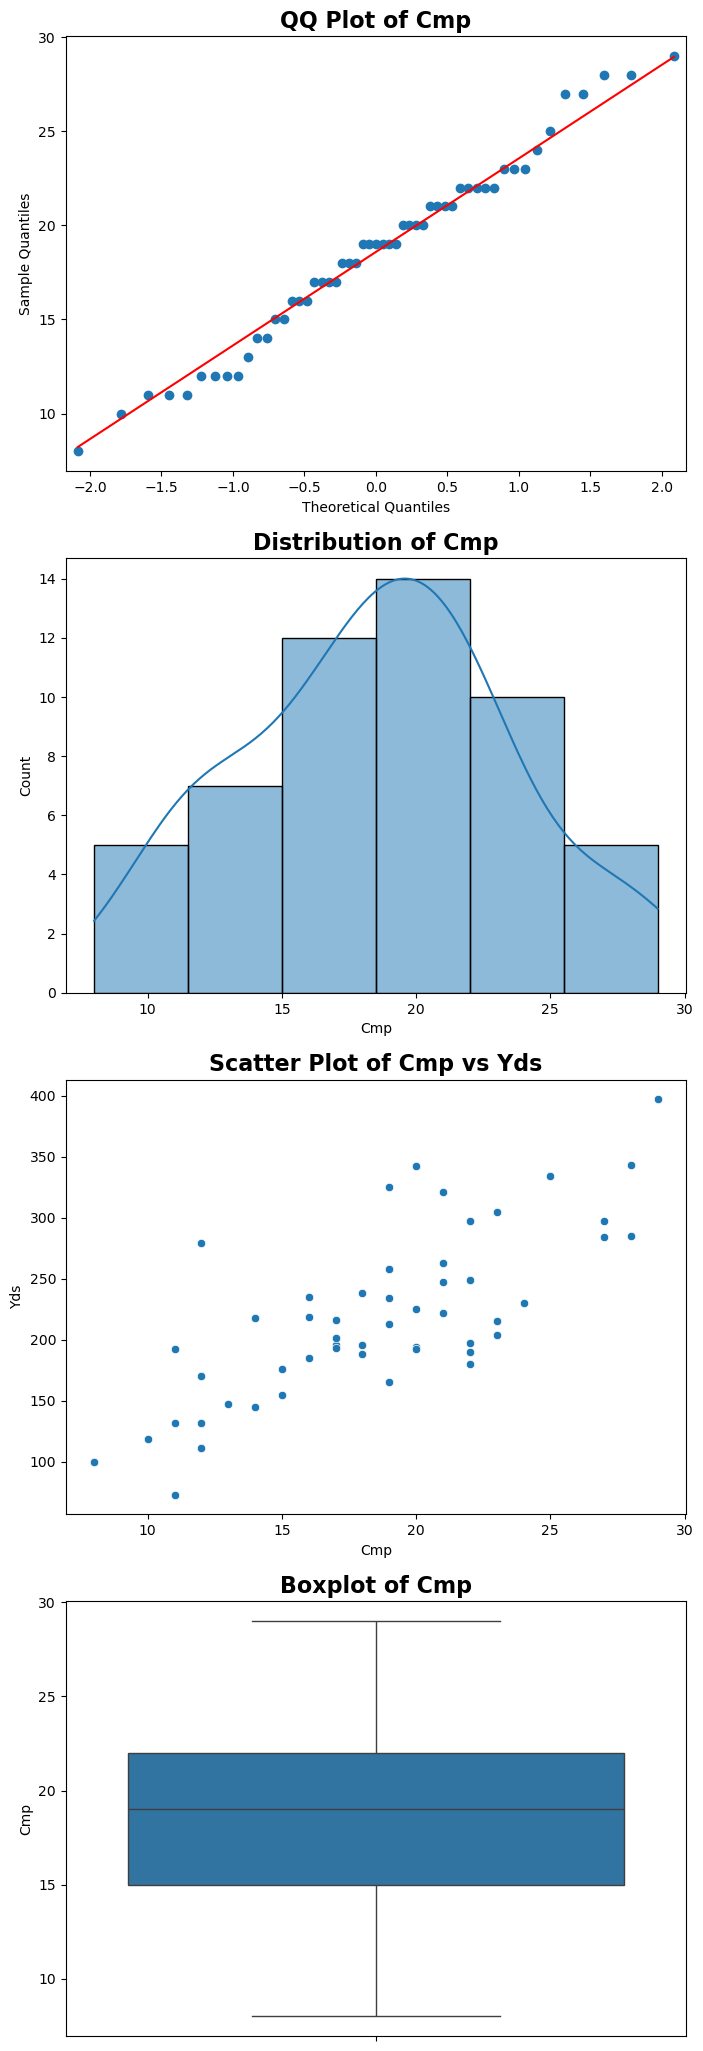

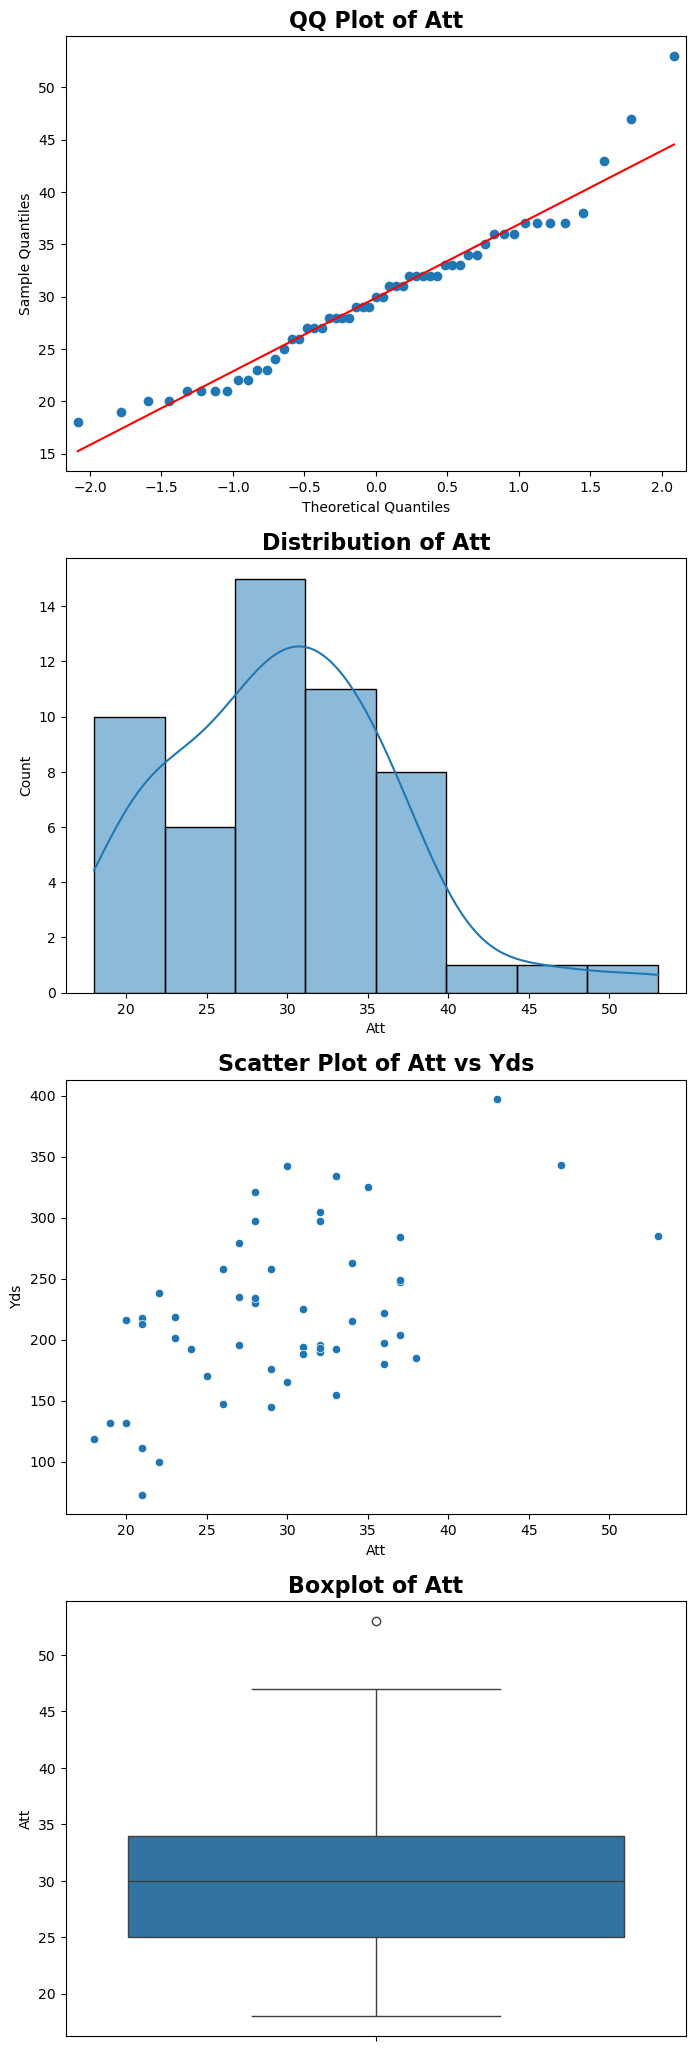

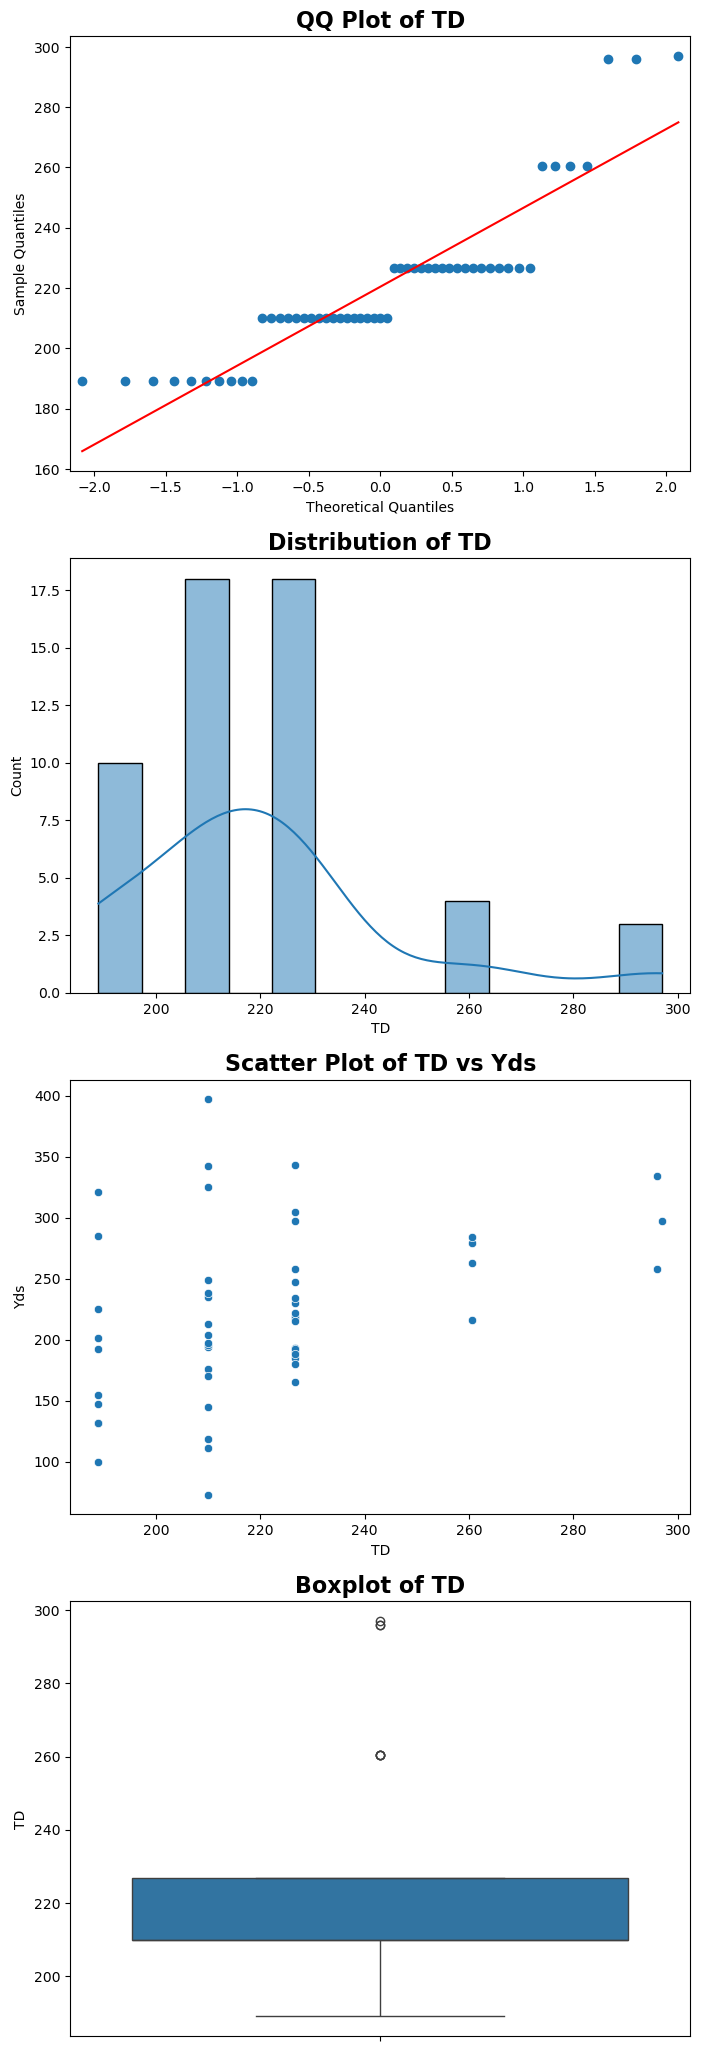

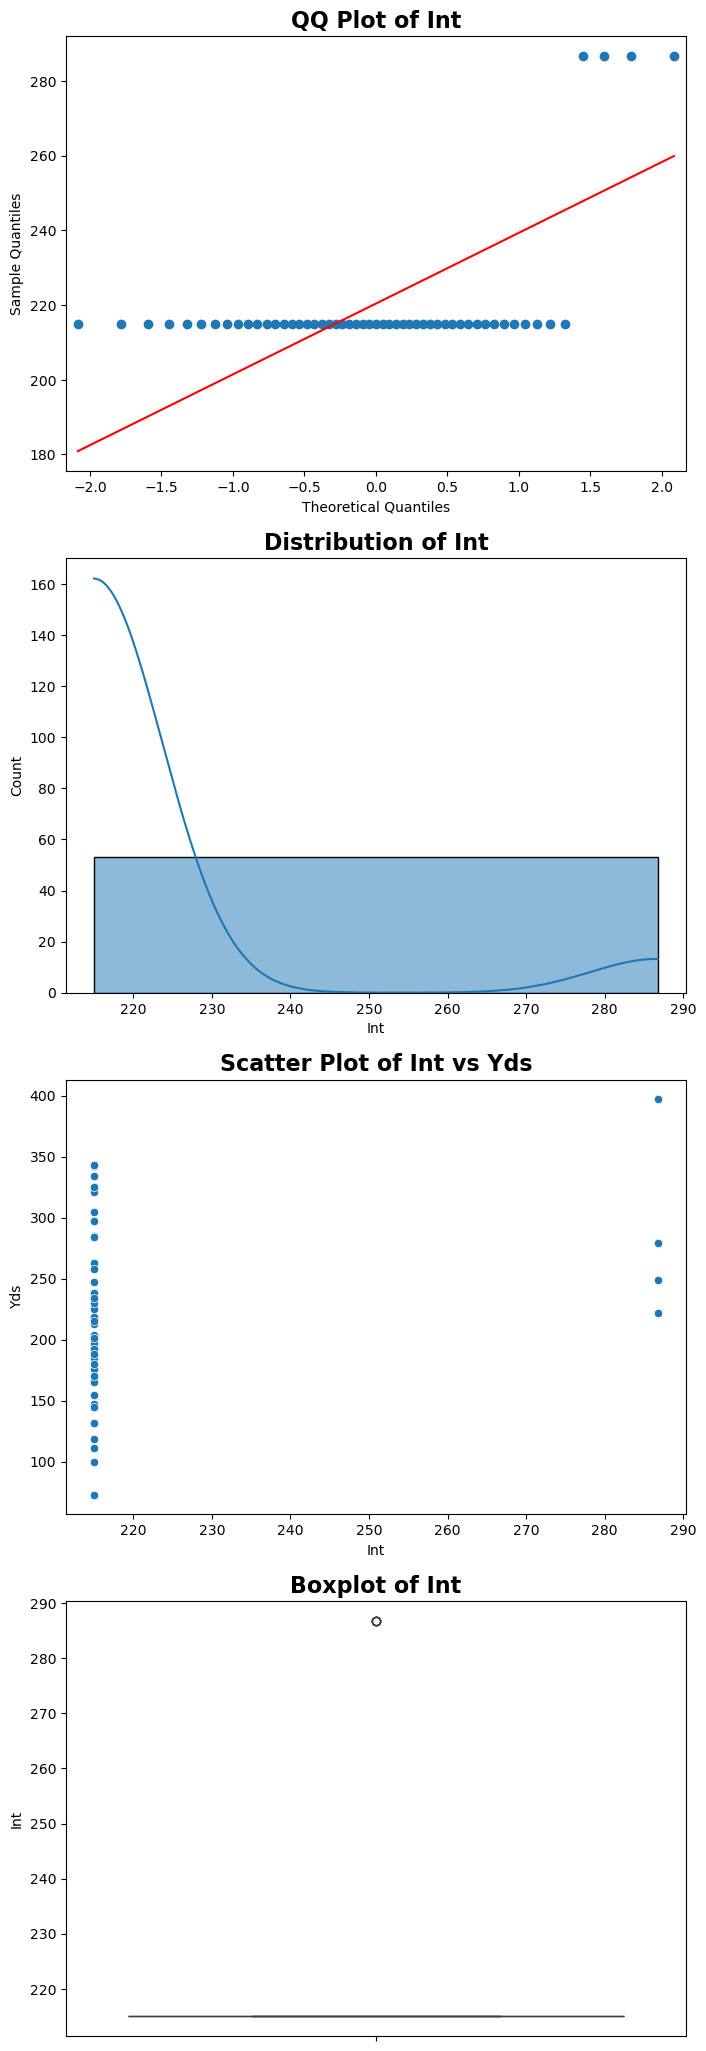

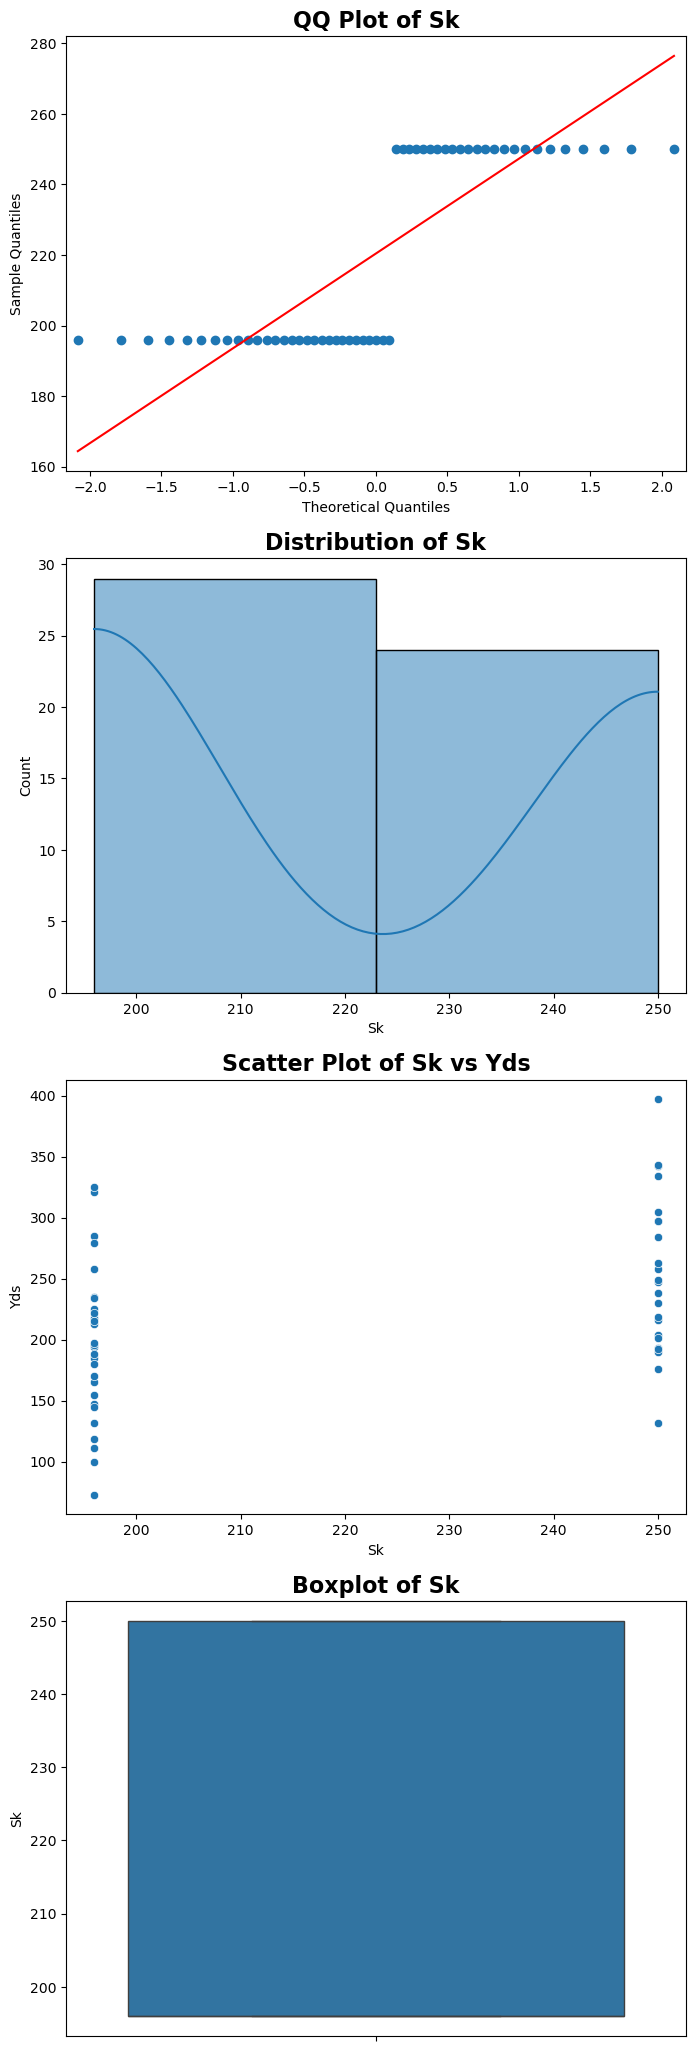

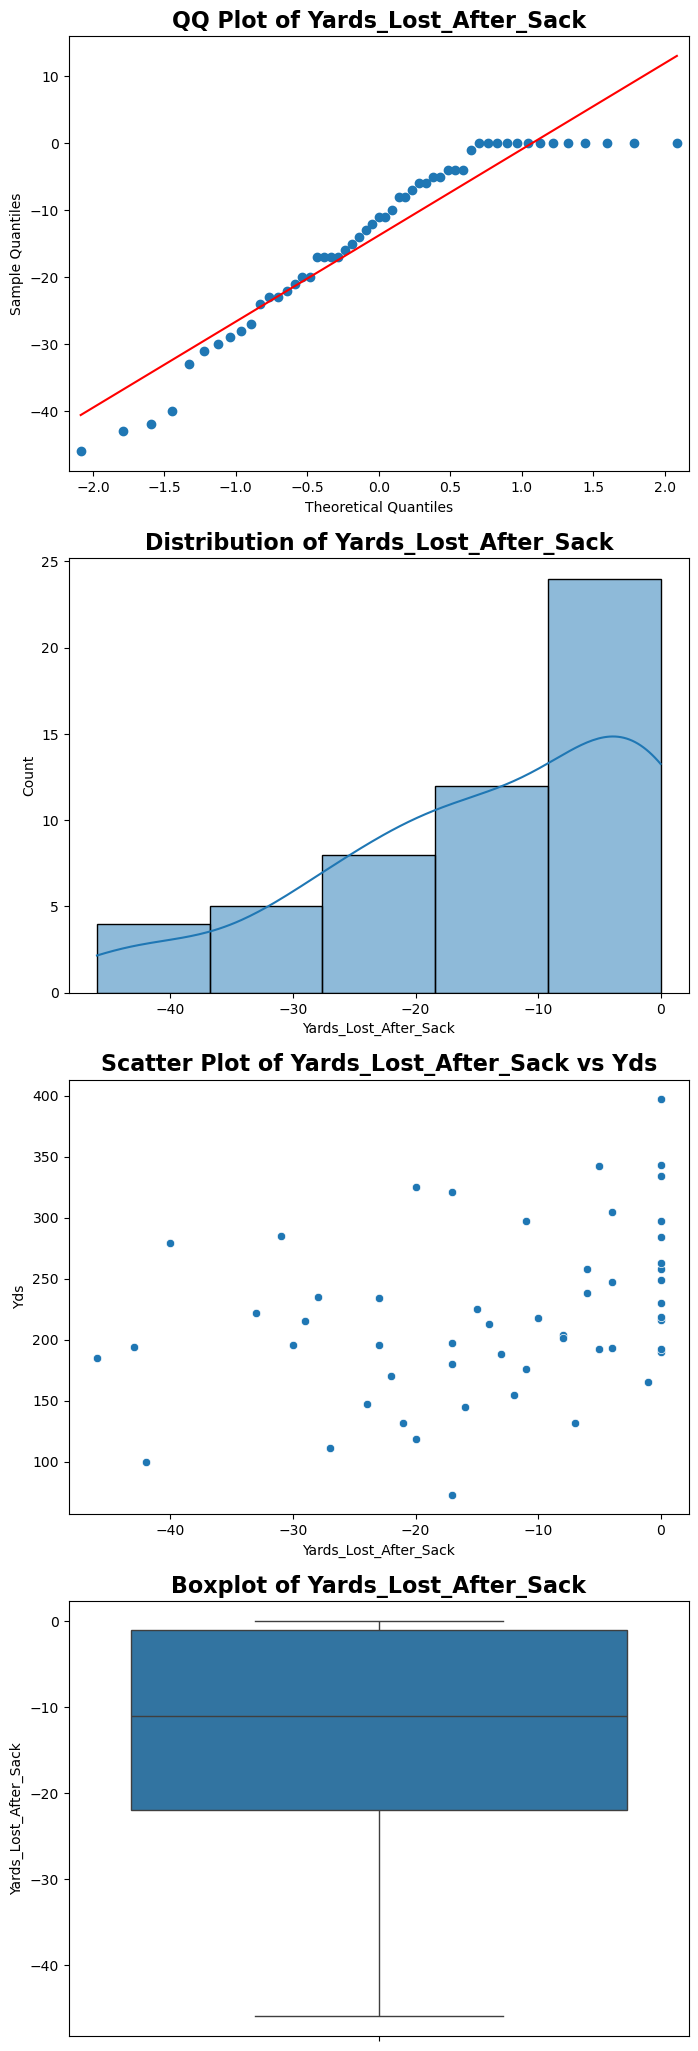

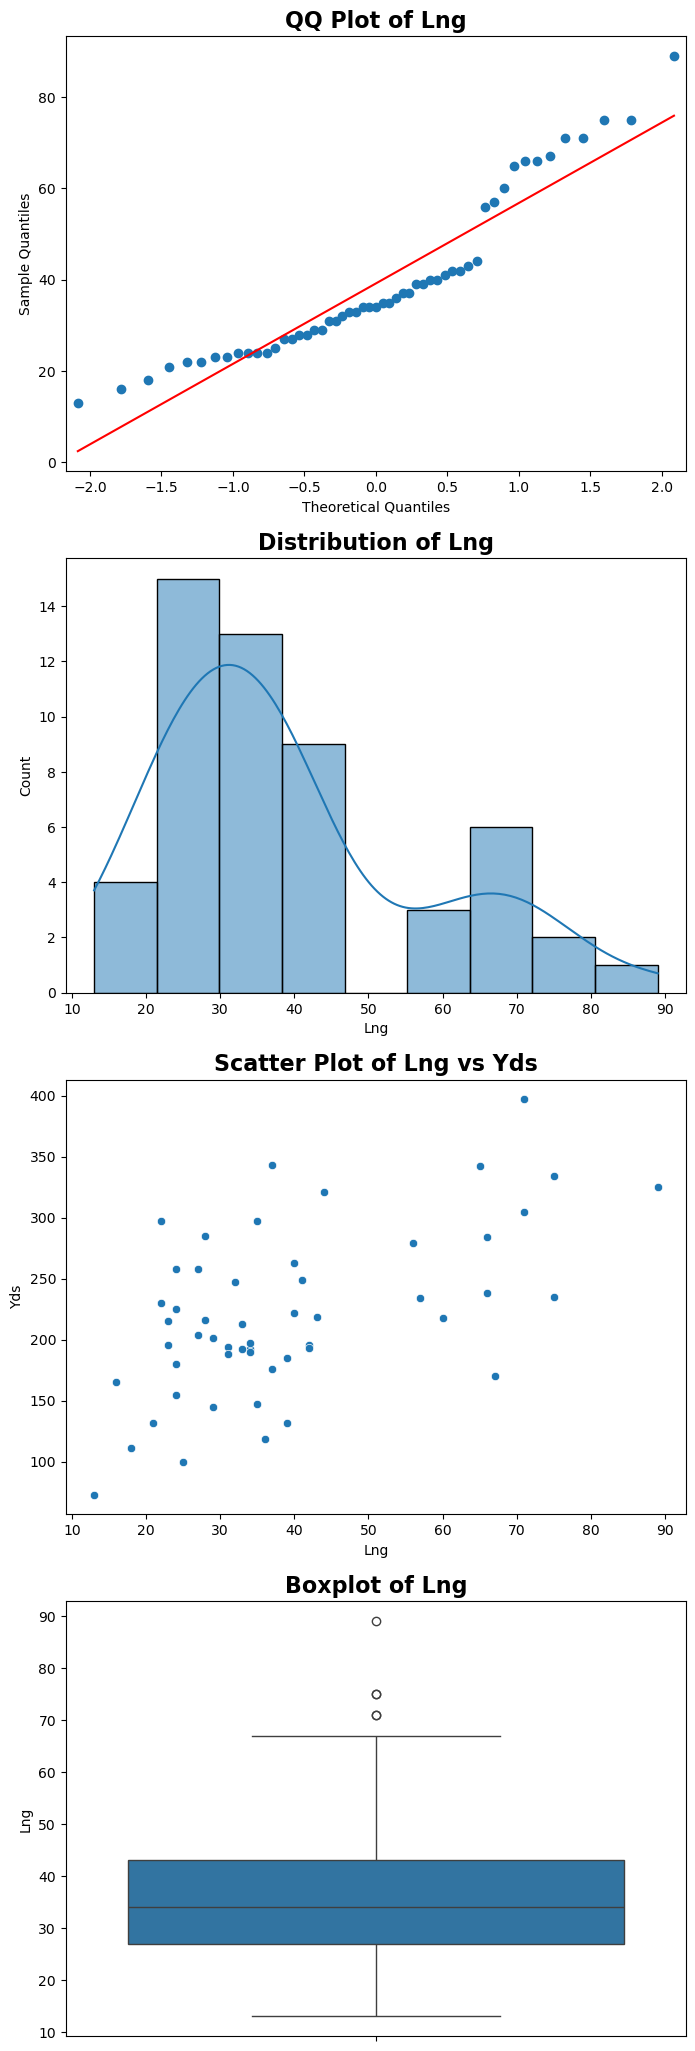

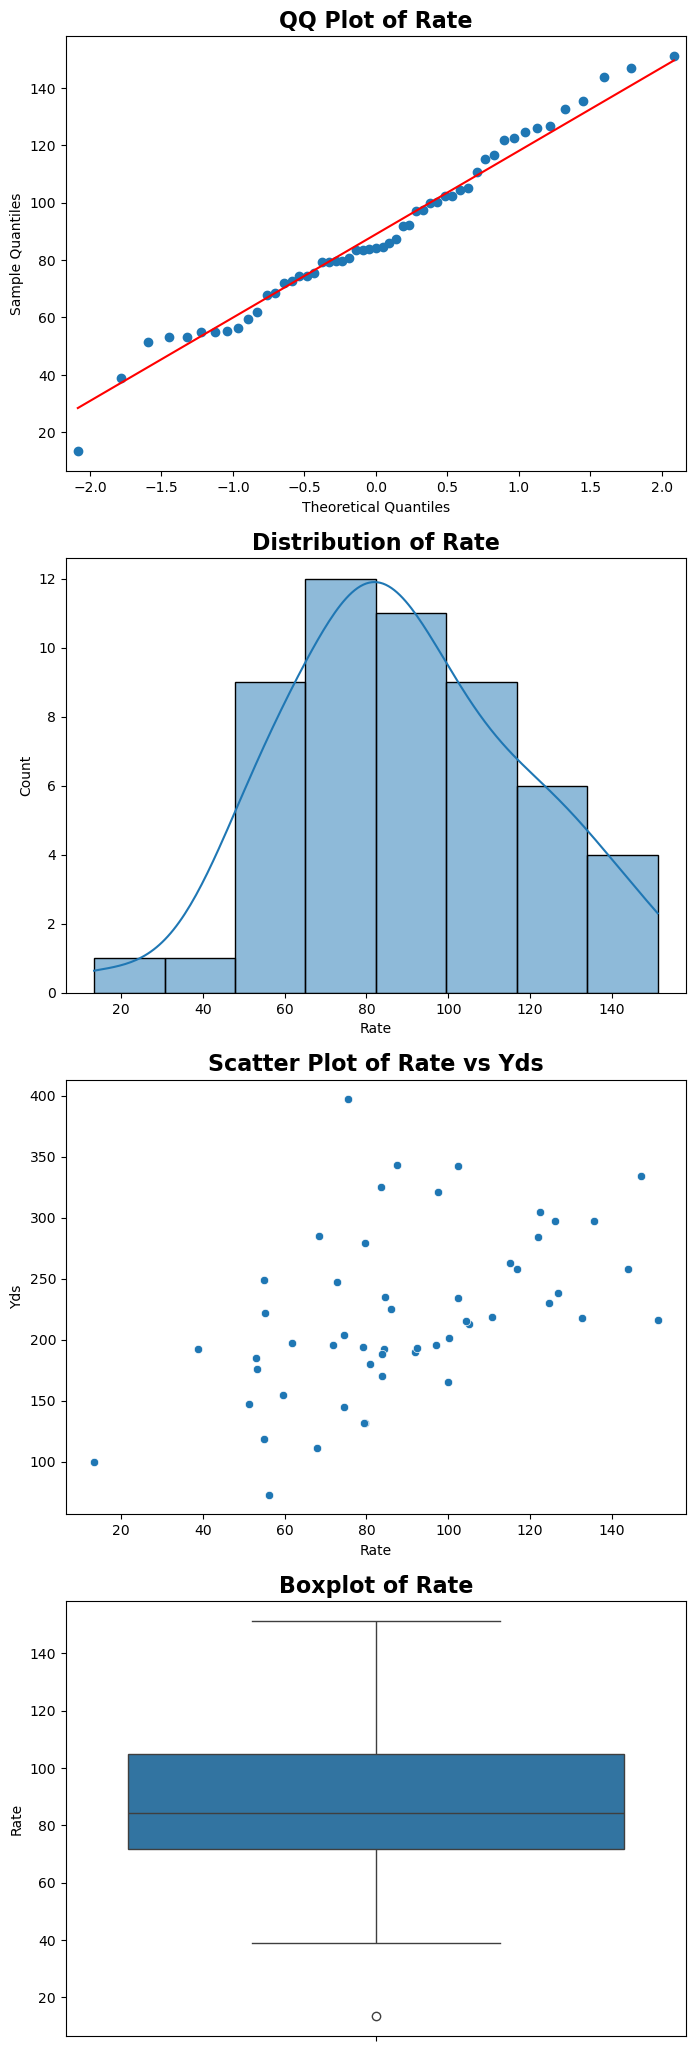

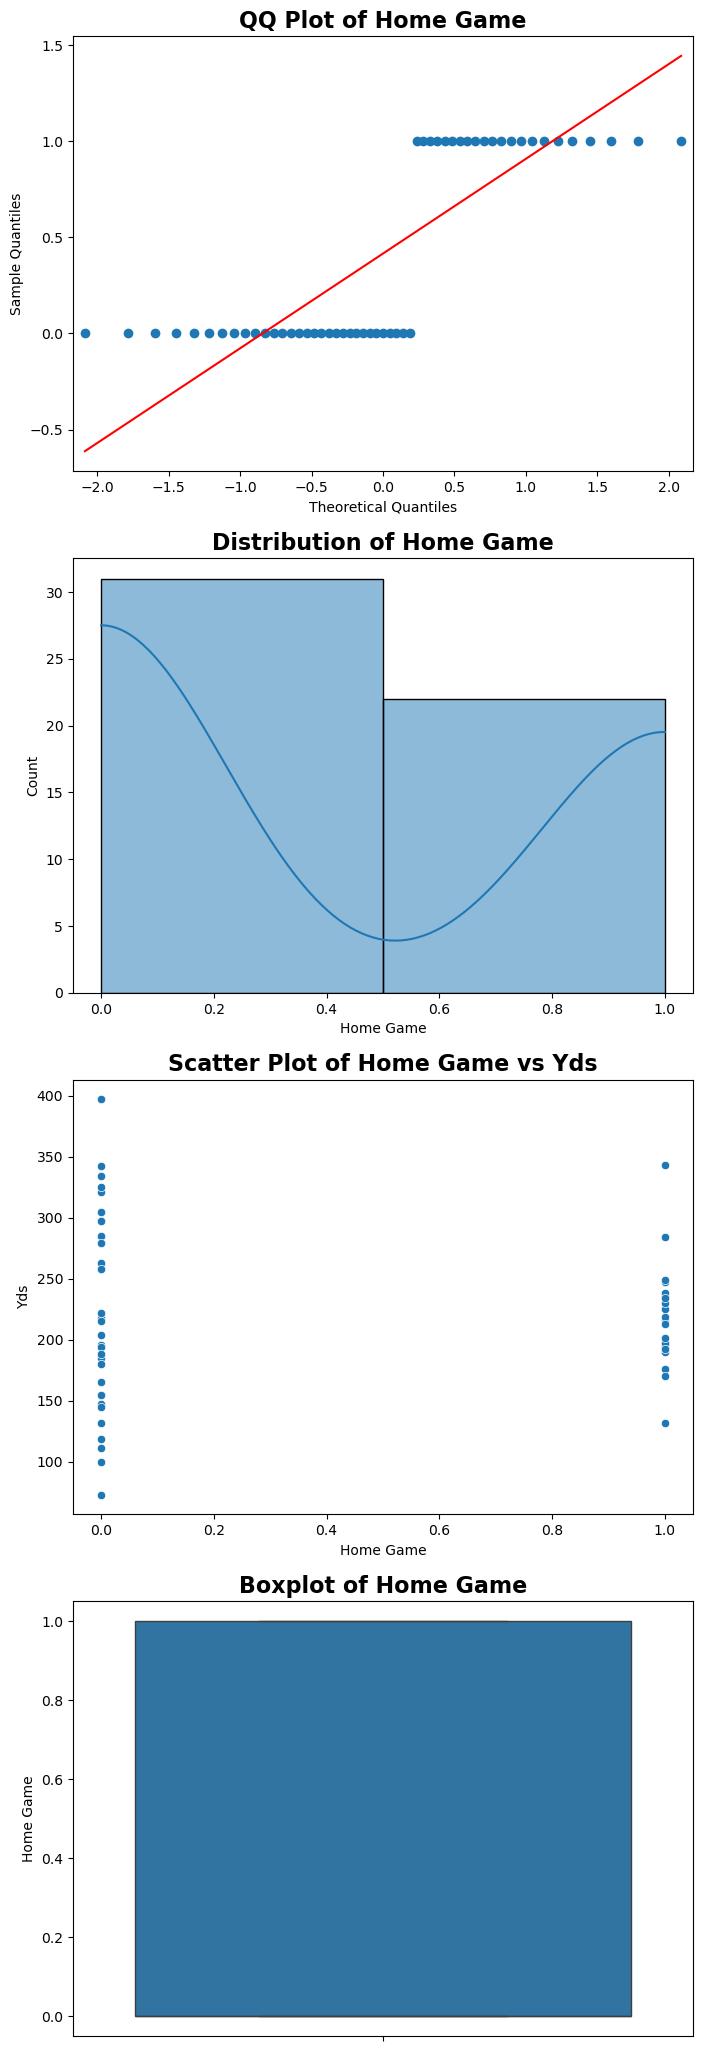

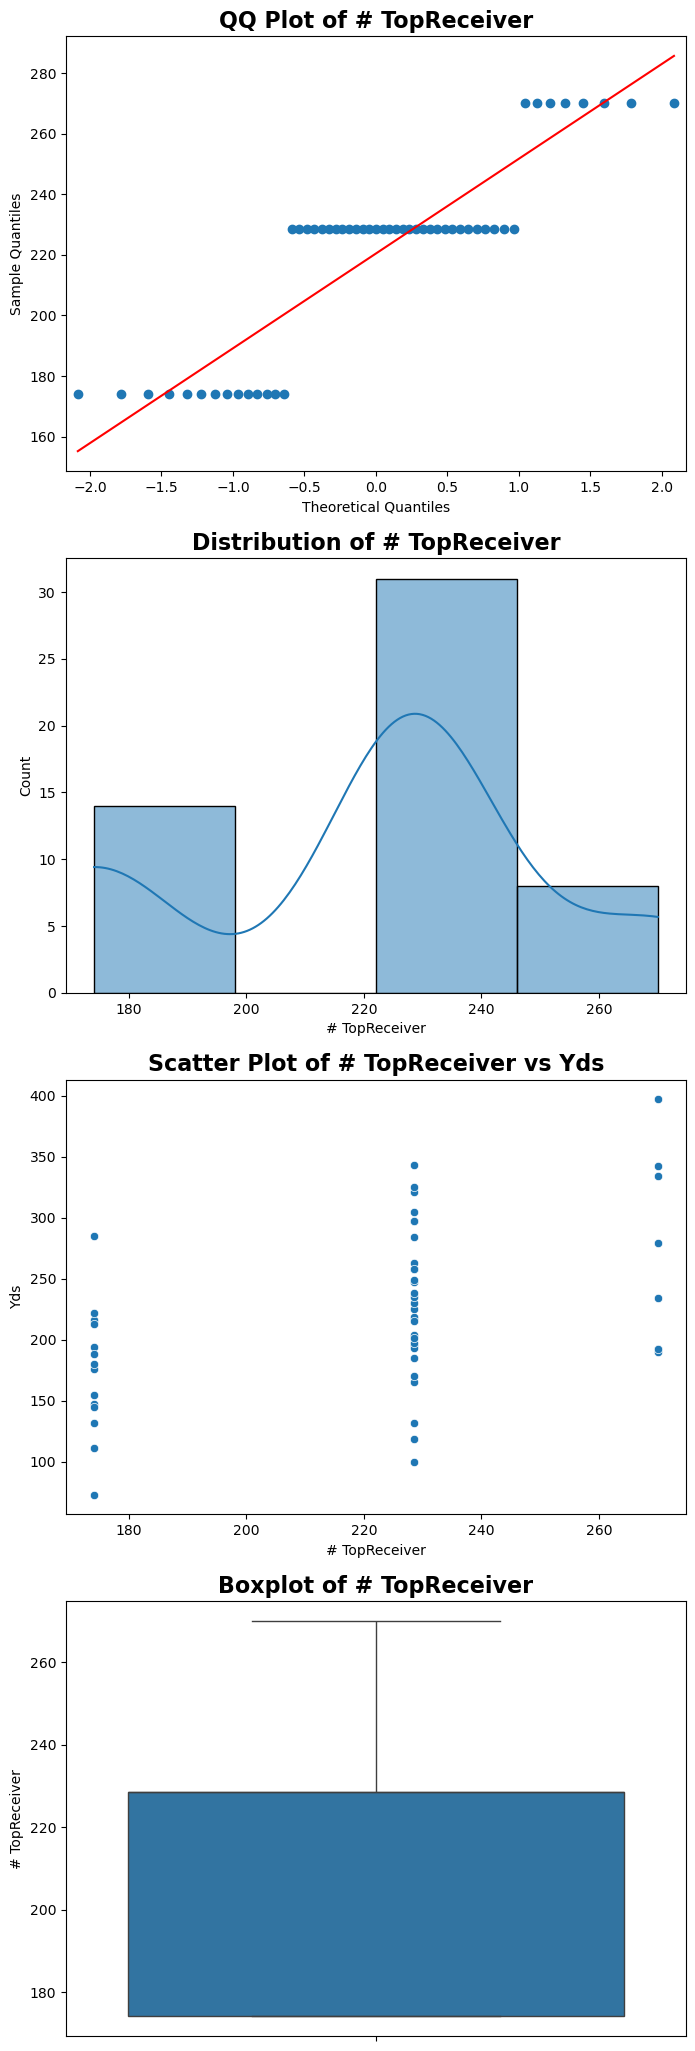

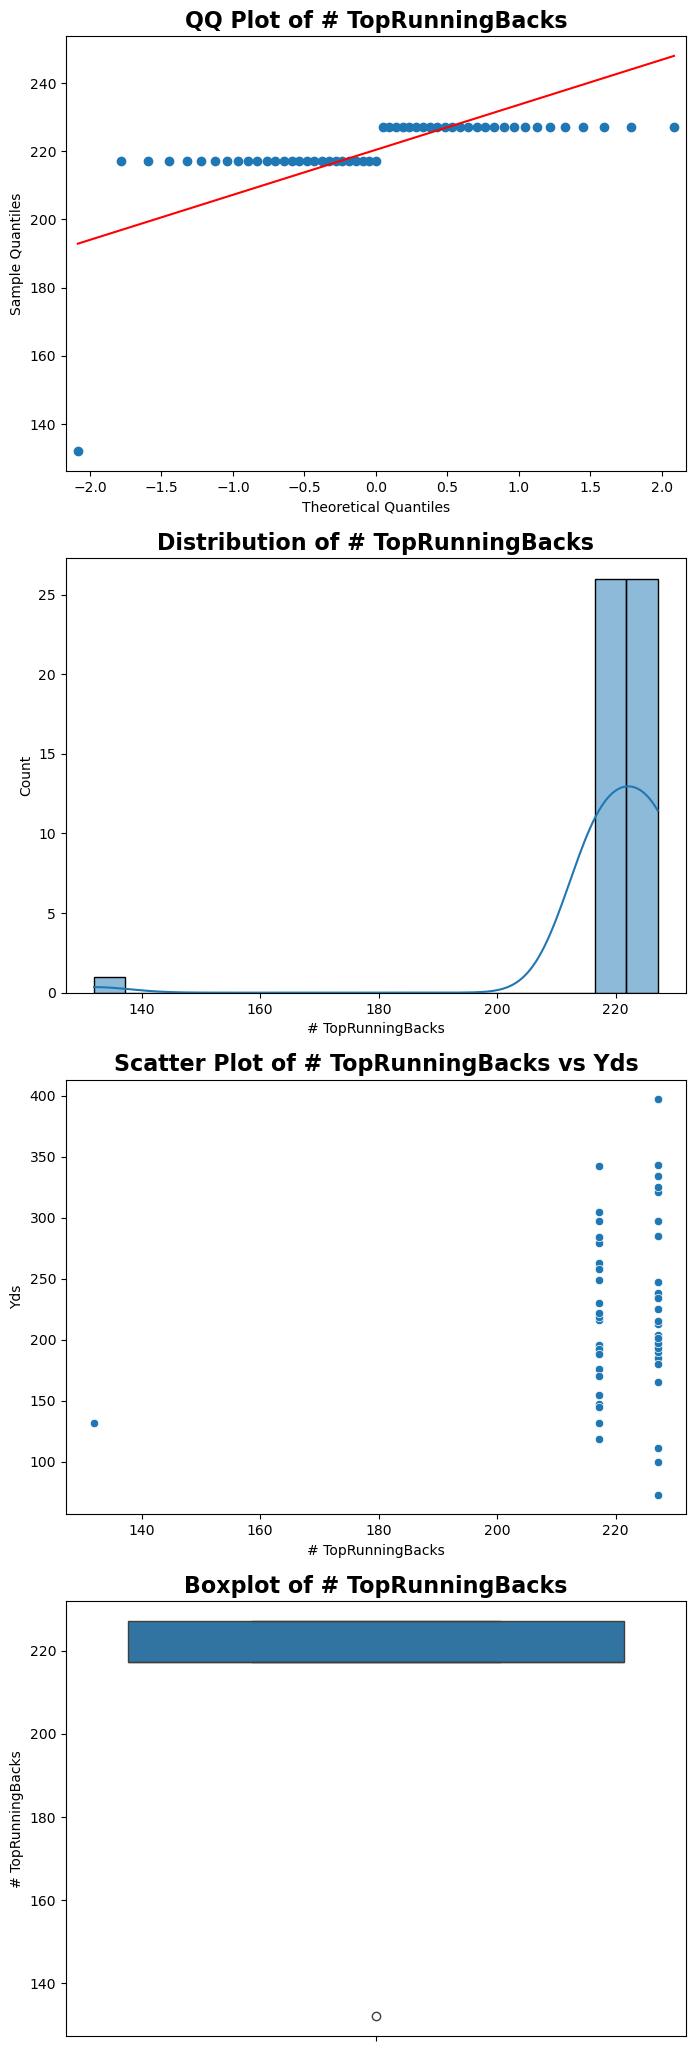

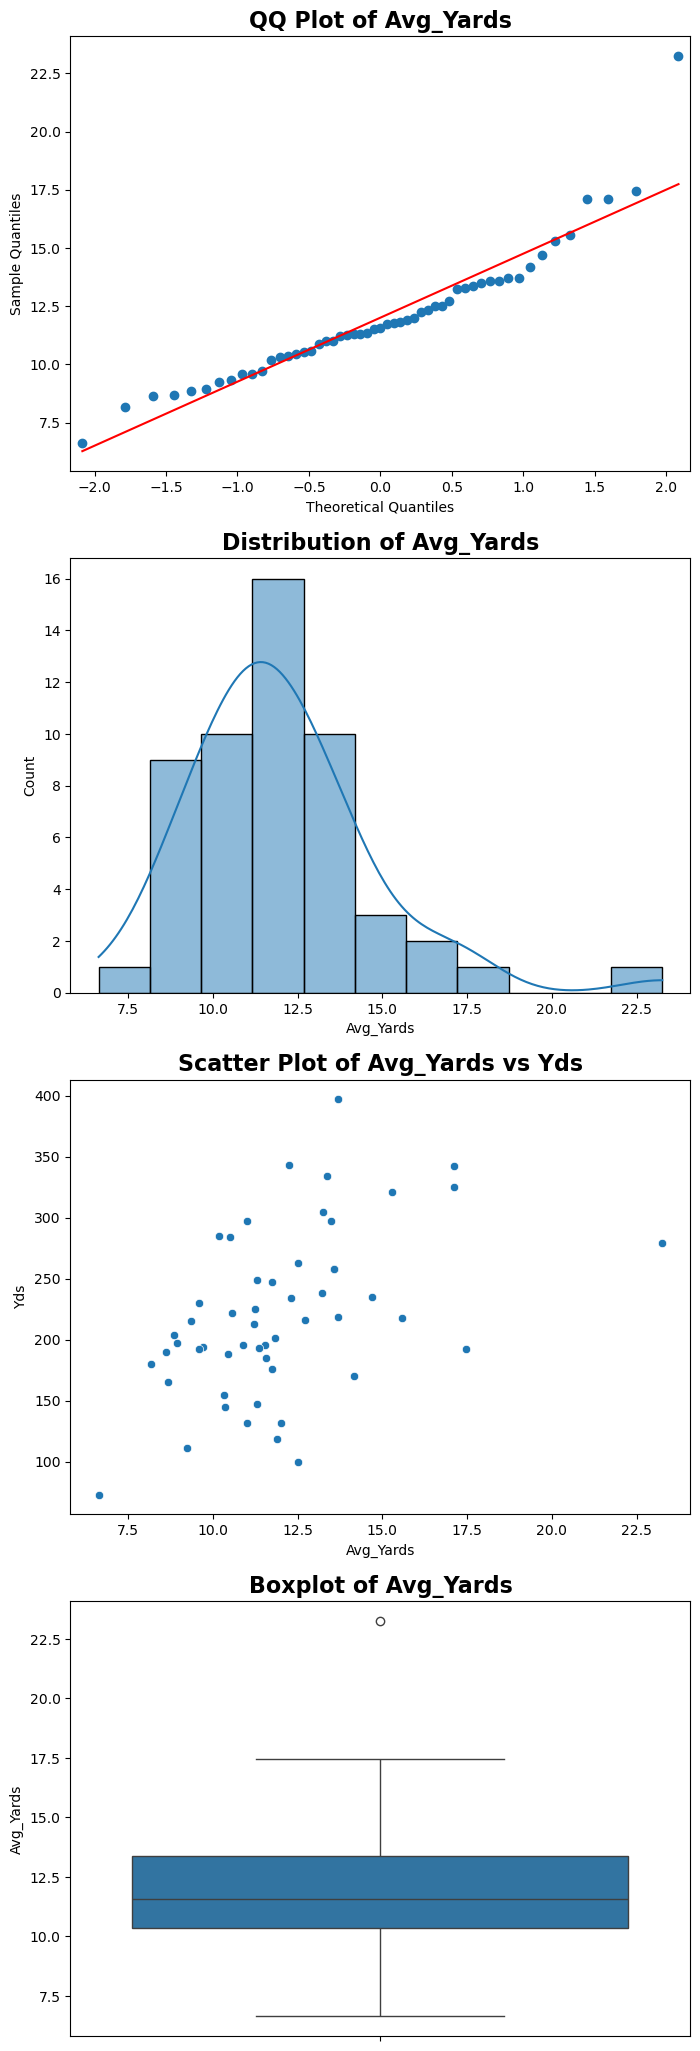

In [21]:
X_features=list(X_train_dct.columns)
[X_features.remove(x) for x in ['Opponent','Year']]

#i => numerical value; x => input value for x
for i, x in enumerate(X_features):
    fig, axes = plt.subplots(4, 1, figsize=(8, 10))  #create a new figure for each variable
    plt.subplots_adjust(top=2.0,bottom=0.0)
    
    #qq plot
    sm.qqplot(X_train_dct[x], line="s", ax=axes[0])
    axes[0].set_title(f"QQ Plot of {x}",size=16,fontweight='bold')

    #histogram
    sns.histplot(X_train_dct[x], bins='fd', kde=True, ax=axes[1])
    axes[1].set_title(f"Distribution of {x}",size=16,fontweight='bold')

    #scatter Plot
    sns.scatterplot(x=X_train_dct[x], y=y_train, ax=axes[2])
    axes[2].set_title(f"Scatter Plot of {x} vs Yds",size=16,fontweight='bold')

    #boxplot
    sns.boxplot(X_train_dct[x],orient='v',ax=axes[3])
    axes[3].set_title(f"Boxplot of {x}",size=16,fontweight='bold')

We still have to deal with a mixture of linear/non-linear, normally/non-normally distributed features that still contain outliers. At the moment we are not dealing with this, we will do so when we come to model selection.
Next, we will check if we are dealing with multicollinarity. Multicollinearity is when X features are correlated with each other. As mentioned, we have features with normal and non-normal distributions, each of which requires a different method.
For the features with a normal distribution we can use Pearson's Correlation and for the features with a non-normal distribution we will use Spearman's Correlation. Spearman's Correlation allows us to calculate the correlation of ordinal values as well, if we look at the graphs above we can see that our ordinal features are non-normally distributed, which makes sense because if there are only a few unique ordinal values then it is very likely that our distribution will follow a non-normal distribution.

In addition, we will run a partial correlation, just to get a better understanding of how the features interact with each other without the influence of the other features.

### Multicollinearity

Normal Features: ['Cmp', 'Yards_Lost_After_Sack', 'Rate', '# TopReceiver']
Non-Normal Features: ['Att', 'TD', 'Int', 'Sk', 'Lng', 'Home Game', 'Opponent', 'Year', '# TopRunningBacks', 'Avg_Yards']


Pearson Correlation between Cmp and Yds: 0.7450701507409836 - statistically signfificant


Pearson Correlation between Yards_Lost_After_Sack and Yds: 0.34004386717218227 - statistically signfificant


Pearson Correlation between Rate and Yds: 0.4957162129947018 - statistically signfificant


Pearson Correlation between # TopReceiver and Yds: 0.4645697048722246 - statistically signfificant


Partial Correlation of Normall Features between Yards_Lost_After_Sack - Rate leaving out Cmp: 0.43261064903304797 - not statistically signfificant


Partial Correlation of Normall Features between Yards_Lost_After_Sack - # TopReceiver leaving out Cmp: 0.2002109042654585 - not statistically signfificant


Partial Correlation of Normall Features between Rate - Yards_Lost_After_Sack leaving out Cmp: 0.43261

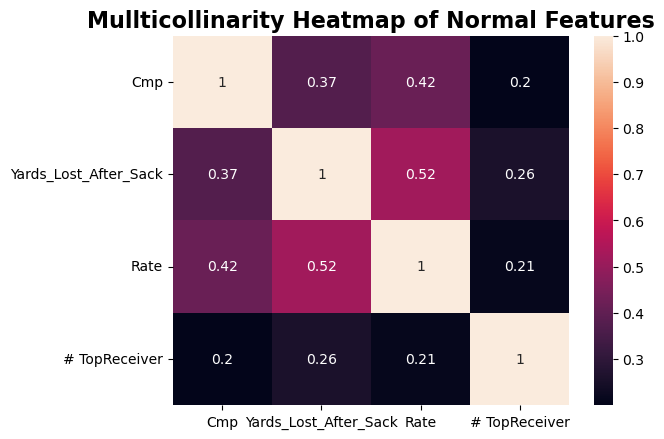

Text(0.5, 1.0, 'Mullticollinarity Heatmap of Non-Normal Features')

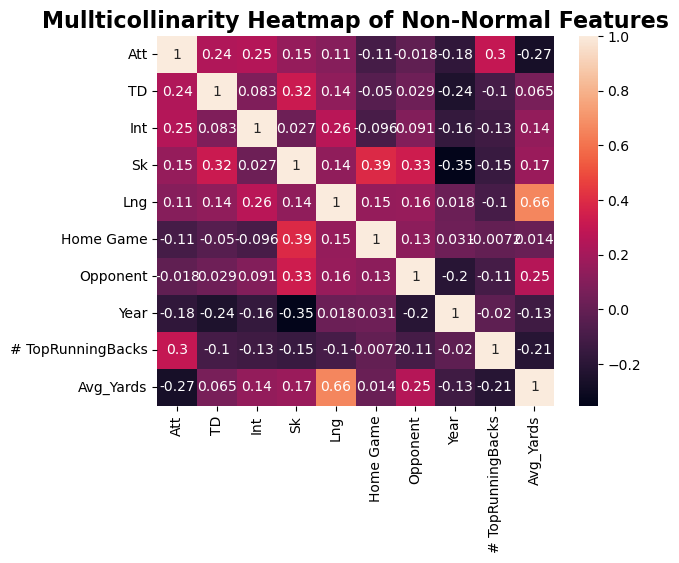

In [22]:
X_feat=list(X_train_dct.select_dtypes(exclude='object').columns)
norm_dict={}
for x in X_feat:
    x_norm_test=normaltest(X_train_dct[x])
    norm_dict[f'{x}']=x_norm_test[1]
normaility_df=pd.DataFrame.from_dict(norm_dict,orient='index', columns=['p-value']).reset_index()
normaility_df.rename(columns={'index':'columns'},inplace=True)
non_normal_features=list(normaility_df[normaility_df['p-value']<=0.05]['columns'])
normal_features=list(normaility_df[normaility_df['p-value']>0.05]['columns'])

print(f'Normal Features: {normal_features}')
print(f'Non-Normal Features: {non_normal_features}')
print('\n')
for nd in normal_features:
    pear_corr=pearsonr(x=X_train_dct[nd],y=y_train)
    print(f'Pearson Correlation between {nd} and Yds: {pear_corr[0]} - {"statistically signfificant" if pear_corr[1] < 0.05 else "not statistically signfificant"}')
    print('\n')

for nd in normal_features:
    for nd1 in normal_features:
        for nd2 in normal_features:
            if nd1!=nd2 and nd1!=nd and nd!=nd2:
                par_corr=partial_corr(data=X_train_dct,x=nd1,y=nd2,covar=nd,method='pearson')
                print(f'Partial Correlation of Normall Features between {nd1} - {nd2} leaving out {nd}: {par_corr.iat[0,1]} - {"statistically signfificant" if par_corr.iat[0,0] < 0.05 else "not statistically signfificant"}')
                print('\n')

for nd in non_normal_features:
    spearl_corr=spearmanr(X_train_dct[nd],y_train)
    print(f"Spearman Correlation between {nd} and Yds: {spearl_corr[0]} - {'statistically signfificant' if spearl_corr[1] < 0.05 else 'not statistically signfificant'}")
    print('\n')

for nd in non_normal_features:
    for nd1 in non_normal_features:
        for nd2 in non_normal_features:
            if nd1!=nd2 and nd1!=nd and nd!=nd2:
                par_corr=partial_corr(data=X_train_dct,x=nd1,y=nd2,covar=nd,method='spearman')
                print(f'Partial Correlation of Non Normal Features between {nd1} - {nd2} leaving out {nd}: {par_corr.iat[0,1]} - {"statistically signfificant" if par_corr.iat[0,0] < 0.05 else "not statistically signfificant"}')
                print('\n')

vif_df=pd.DataFrame()
vif_df['Features']=X_train_dct.columns
vif_df['VIF']=['{:f}'.format(variance_inflation_factor(X_train_dct.values,i)) for i in range(X_train_dct.shape[1])]
print(vif_df)

sns.heatmap(X_train_dct[normal_features].corr(method='pearson'),annot=True)
plt.title('Mullticollinarity Heatmap of Normal Features',size=16,fontweight='bold')
plt.show()
print('\n')
sns.heatmap(X_train_dct[non_normal_features].corr(method='spearman'),annot=True)
plt.title('Mullticollinarity Heatmap of Non-Normal Features',size=16,fontweight='bold')

In [23]:
def multicollinarity_check(X_train, y_train):
  X_feat=list(X_train.select_dtypes(exclude='object').columns)
  norm_dict={}
  for x in X_feat:
      x_norm_test=normaltest(X_train[x])
      norm_dict[f'{x}']=x_norm_test[1]
  normaility_df=pd.DataFrame.from_dict(norm_dict,orient='index', columns=['p-value']).reset_index()
  normaility_df.rename(columns={'index':'columns'},inplace=True)
  non_normal_features=list(normaility_df[normaility_df['p-value']<=0.05]['columns'])
  normal_features=list(normaility_df[normaility_df['p-value']>0.05]['columns'])

  print(f'Normal Features: {normal_features}')
  print('\n')
  print(f'Non-Normal Features: {non_normal_features}')
  print('\n')
  for nd in normal_features:
      pear_corr=pearsonr(x=X_train[nd],y=y_train)
      print(f'Pearson Correlation between {nd} and Yds: {pear_corr[0]} - {"statistically signfificant" if pear_corr[1] < 0.05 else "not statistically signfificant"}')
      print('\n')

  for nd in normal_features:
      for nd1 in normal_features:
          for nd2 in normal_features:
              if nd1!=nd2 and nd1!=nd and nd!=nd2:
                  par_corr=partial_corr(data=X_train,x=nd1,y=nd2,covar=nd,method='pearson')
                  print(f'Partial Correlation of Normall Features between {nd1} - {nd2} leaving out {nd}: {par_corr.iat[0,1]} - {"statistically signfificant" if par_corr.iat[0,0] < 0.05 else "not statistically signfificant"}')
                  print('\n')

  for nd in non_normal_features:
      spearl_corr=spearmanr(X_train[nd],y_train)
      print(f"Spearman Correlation between {nd} and Yds: {spearl_corr[0]} - {'statistically signfificant' if spearl_corr[1] < 0.05 else 'not statistically signfificant'}")
      print('\n')

  for nd in non_normal_features:
      for nd1 in non_normal_features:
          for nd2 in non_normal_features:
              if nd1!=nd2 and nd1!=nd and nd!=nd2:
                  par_corr=partial_corr(data=X_train,x=nd1,y=nd2,covar=nd,method='spearman')
                  print(f'Partial Correlation of Non Normal Features between {nd1} - {nd2} leaving out {nd}: {par_corr.iat[0,1]} - {"statistically signfificant" if par_corr.iat[0,0] < 0.05 else "not statistically signfificant"}')
                  print('\n')

  vif_df=pd.DataFrame()
  vif_df['Features']=X_train.columns
  vif_df['VIF']=['{:f}'.format(variance_inflation_factor(X_train.values,i)) for i in range(X_train.shape[1])]
  print(vif_df)

  sns.heatmap(X_train[normal_features].corr(method='pearson'),annot=True)
  plt.title('Mullticollinarity Heatmap of Normal Features',size=16,fontweight='bold')
  plt.show()
  print('\n')
  sns.heatmap(X_train[non_normal_features].corr(method='spearman'),annot=True)
  plt.title('Mullticollinarity Heatmap of Non-Normal Features',size=16,fontweight='bold')

Normal Features: ['Cmp', 'Yards_Lost_After_Sack', 'Rate', '# TopReceiver']


Non-Normal Features: ['Att', 'TD', 'Int', 'Sk', 'Lng', 'Home Game', 'Opponent', 'Year', '# TopRunningBacks', 'Avg_Yards']


Pearson Correlation between Cmp and Yds: 0.7450701507409836 - statistically signfificant


Pearson Correlation between Yards_Lost_After_Sack and Yds: 0.34004386717218227 - statistically signfificant


Pearson Correlation between Rate and Yds: 0.4957162129947018 - statistically signfificant


Pearson Correlation between # TopReceiver and Yds: 0.4645697048722246 - statistically signfificant


Partial Correlation of Normall Features between Yards_Lost_After_Sack - Rate leaving out Cmp: 0.43261064903304797 - not statistically signfificant


Partial Correlation of Normall Features between Yards_Lost_After_Sack - # TopReceiver leaving out Cmp: 0.2002109042654585 - not statistically signfificant


Partial Correlation of Normall Features between Rate - Yards_Lost_After_Sack leaving out Cmp: 0.432

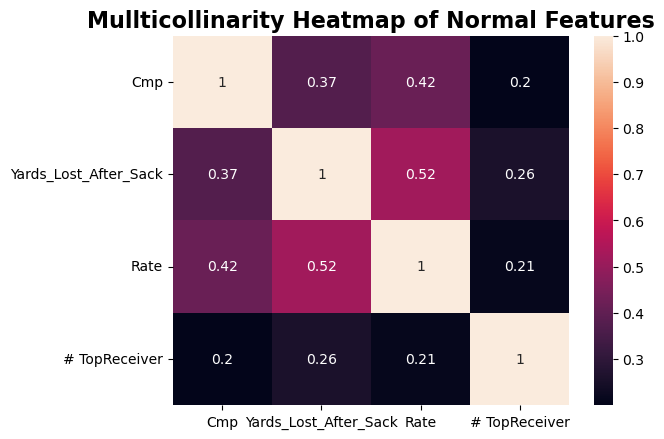

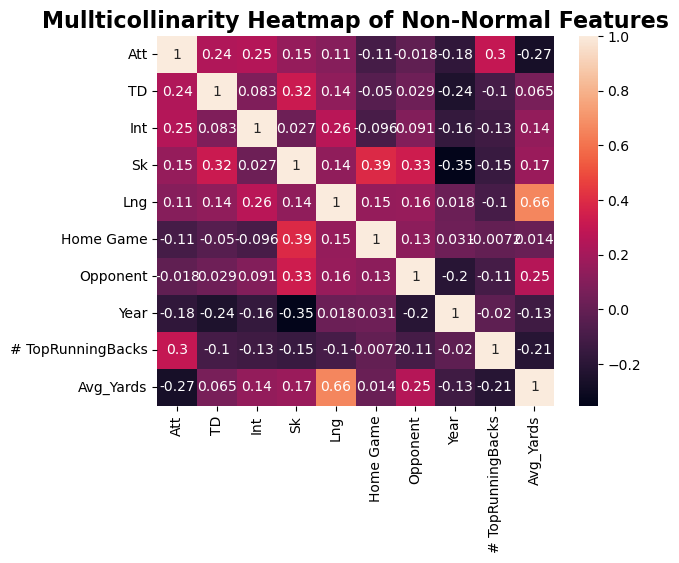

In [24]:
multicollinarity_check(X_train_dct,y_train)

The Spearman and Pearson correlations suggest that we are dealing with low to moderate multicorrelation. Looking at the VIF, it is clear that we are dealing with a strong multi-correlation.

The next step is to decide which model(s) to try to predict Baker's passing yards.

## Choosing the appropriate Models

After feature engineering, which is the characteristic of the data:

**X Features**

- Mixture of linear (rather weak linearity) and non-linear features
- Mixture of normal and non-normal distributions
- Outliers, small but still present
- Based on the vif score, we are dealing with a massive multicorrelation, but Pearson, Spearman and their partial correlations show a different trend

**y Feature**

- Has few outliers
- Normally distributed

Based on the characteristics of the data, the following models are trained and compared.

- RandomForest => is robust to outliers; can deal with non-linear data as well as linear data.
- Gradient Boosting Regressor => Same characteristics as RandomForest, but better suited to smaller data sets.
- Kernel Rdige Regression => Can deal with non-linear data and regularise it.
- XGBoost Regression => Can handle non-linear data, is robust to outliers and can capture complex relationships.

It is important to note that we only have 72 data points in total and 54 for the training set. The models we have selected may over- or under-fit if we do not choose an appropriate hypertuning range and choose the appropriate corss validation method. As mentioned above, we do not have many data points, so we will use Leave-One-Out cross-validation, which trains on maximum points -1, so it leaves one out and trains on the rest.

Next, having decided which models to train, we will select a model that best fits our data.

### Feature Selection

Based on the characteristics of the data, we will use a RandomForest model to find the most important features for the models. As we only have a few data points (72 total; 54 training), we will run one trial with Leave One Out cross-validation and one without. If we see similar results, Leave One Out may not really be needed in this scenario.

In [25]:
#without cross-validation approach

#setting up the estimator model
rfr=RandomForestRegressor(random_state=101)
#putting it in the SelectFromModel
feature_select=SelectFromModel(rfr,threshold=0.05)
#fitting the data
feature_select.fit(X_train_dct,y_train)
#going to the estimator level, and get from the model the feature importance socre
feature_importances = feature_select.estimator_.feature_importances_
#getting the boolan values for all columns; important => True; not important False
selected_mask = feature_select.get_support()
#filtering the scores down to the only important onces
selected_importances = feature_importances[selected_mask]

#printing out the names of the important columns
print(list(feature_select.get_feature_names_out()))
print('\n')
#printing out the score of the important columns
print(selected_importances)

['Cmp', 'Att', 'Lng', 'Rate', 'Avg_Yards']


[0.44263352 0.07843035 0.11107851 0.0571462  0.20665867]


In [26]:
#we are setting up the KFold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

rfr=RandomForestRegressor(random_state=101)

importances = []

#setting up manually cross-validation logic
for train_idx, test_idx in kf.split(X_train_dct):
    X_train, X_test = X_train_dct.iloc[train_idx], X_train_dct.iloc[test_idx]
    y_train_kf, y_test_kf = y_train.iloc[train_idx], y_train.iloc[test_idx]

    rfr.fit(X_train, y_train_kf)
    
    #computing permutation importance on validation set
    #permutation importance*
    result = permutation_importance(rfr, X_test, y_test_kf, n_repeats=10, random_state=42)
    #adding the mean of each cross-validation run
    importances.append(result.importances_mean)

#average feature importance across cross-validation runs
##mean based on row (horizontal) not an column (vertical)
mean_importances = np.mean(importances, axis=0)
#sorting values in descending order 
sorted_idx = np.argsort(mean_importances)[::-1]

for idx in sorted_idx:
    print(f"Feature {idx}: Importance {mean_importances[idx]:.4f}")
filter_idx=[]
for x in sorted_idx:
    if mean_importances[x] >=0.05:
        filter_idx.append(x)
list(X_train_dct.iloc[:,filter_idx].columns)

Feature 0: Importance 0.5276
Feature 13: Importance 0.2680
Feature 6: Importance 0.0622
Feature 1: Importance 0.0427
Feature 7: Importance 0.0122
Feature 11: Importance 0.0079
Feature 8: Importance 0.0056
Feature 10: Importance 0.0043
Feature 3: Importance 0.0030
Feature 9: Importance 0.0017
Feature 4: Importance 0.0008
Feature 2: Importance 0.0002
Feature 12: Importance -0.0011
Feature 5: Importance -0.0036


['Cmp', 'Avg_Yards', 'Lng']

*permutation importance

allows us to measure how much the performance of the model is degraded when the feature values are randomly shuffled.

Which approach is best? Due to the limited data, it is recommended that we use cross-validation to see how the model performs across different training and test sets. To be sure, we will run each model with the different feature selection approaches to see how each model performs.

### Setting Up The Pipeline For The Models

In the previous steps we have performed various feature engineering methods and set up feature selection methods. Next, we need to turn these functions/methods into classes, which will allow us to pass them through the pipeline more easily.

#### Setting Up The Class for Label Encoder

In [27]:
class RareCategoryEncoder(BaseEstimator,TransformerMixin):
    #setting up the different variables which are needed in the class
    def __init__(self,feat,tolerance=0.05,rare_label="None Conference"):
        self.feat=feat
        self.tolerance=tolerance
        self.rare_label=rare_label
        self.frequent_categories_ = None
    #setting up the fit function
    def fit(self,X,y=None):
        category_count=X[self.feat].value_counts(normalize=True)
        self.frequent_categories_=category_count[category_count>self.tolerance].index.tolist()
        return self
    #seeting up the transform function
    def transform(self,X):
        X_transformed=X.copy()
        X_transformed[self.feat]=np.where(X_transformed[self.feat].isin(self.frequent_categories_),
                              X_transformed[self.feat],self.rare_label)
        return X_transformed
#rare_encoder will be passed into the pipeline
rare_encoder = RareCategoryEncoder(feat="Opponent", tolerance=0.05)

#### Setting Up Classes for Feature Selection

In [28]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    #setting up the different variables which are needed in the class
    def __init__(self, threshold=0.05, random_state=101):
        self.threshold = threshold
        self.random_state = random_state
        self.selector_ = None
        self.selected_features_ = None
        self.feature_importances_ = None

    #setting up the fit function
    def fit(self, X, y):
        rfr = RandomForestRegressor(random_state=self.random_state)

        #setting up SelectFromModel
        self.selector_ = SelectFromModel(rfr, threshold=self.threshold)

        #then we fit it the data to the model
        self.selector_.fit(X, y)

        #store feature importances and selected feature names
        self.feature_importances_ = self.selector_.estimator_.feature_importances_
        self.selected_features_ = self.selector_.get_feature_names_out()

        return self

    def transform(self, X):
        #transform X using the selector => applying it to X_train or X_test
        return self.selector_.transform(X)
    #returns feature names
    def get_selected_features(self):
        """Returns the names of selected features."""
        return self.selected_features_
    #returns the score of all features 
    def get_selected_importances(self):
        """Returns the importance scores of selected features."""
        selected_mask = self.selector_.get_support()
        return self.feature_importances_[selected_mask]
#how to pass it into the pipeline
feature_selector = FeatureSelector(threshold=0.05, random_state=101)

In [29]:
class FeatureSelector_CV(BaseEstimator,TransformerMixin):
    #setting up the different variables which are needed in the class
    def __init__(self, threshold=0.05, n_splits=5, n_repeats=10, random_state=101):
        self.threshold = threshold
        self.n_splits = n_splits
        self.n_repeats = n_repeats
        self.random_state = random_state
        self.selected_features_ = None

    def fit(self, X, y):
        kf = KFold(n_splits=self.n_splits, shuffle=True, random_state=self.random_state)
        importances = []
        
        for train_idx, test_idx in kf.split(X):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train_kf, y_test_kf = y.iloc[train_idx], y.iloc[test_idx]

            #fit RandomForestRegressor
            model = RandomForestRegressor(random_state=self.random_state)
            model.fit(X_train, y_train_kf)

            #compute permutation importance
            result = permutation_importance(model, X_test, y_test_kf, n_repeats=self.n_repeats, random_state=self.random_state)
            importances.append(result.importances_mean)

        #calculate mean importances across cross-validation folds
        mean_importances = np.mean(importances, axis=0)

        #select features above the threshold
        self.selected_features_ = X.columns[mean_importances >= self.threshold].tolist()
        
        return self

    def transform(self, X):
        return X[self.selected_features_]
    #returns feature names
    def get_selected_features(self):
        return self.selected_features_
#how to pass it into the pipeline
feature_selector = FeatureSelector_CV(threshold=0.05,random_state=101)

## Building & Training The Different Models

We will start with a baseline model, which is what we need to beat, all the other models will be compared against this baseline.
First we will split the data again to get our training and test sets, when we have more data we can split the test data again to get a validation and test set.

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=101)

### Baseline Model

In [82]:
dict_model_scores={}
base_pipeline=Pipeline(
    [
        ('rare_label',RareCategoryEncoder(feat="Opponent", tolerance=0.05)),
        ('mean_encoder',MeanEncoder(variables=['Opponent'])),
        ('discritization',DecisionTreeDiscretiser(cv=10, scoring="neg_root_mean_squared_error", regression=True, variables=['TD','Int','Sk','# TopReceiver','# TopRunningBacks'],random_state=101)),
        ('feature_select',FeatureSelector(threshold=0.05, random_state=101)),
        ('base_model',DummyRegressor())
    ]
)
start_time=time.time()
dummy_score_rmse=(cross_val_score(base_pipeline,X_train,y_train,cv=KFold(n_splits=10, shuffle=True, random_state=101),scoring='neg_root_mean_squared_error').mean())*-1
end_time=time.time()
dict_model_scores['Baseline_Model_Score']={'Score':dummy_score_rmse,'RunTime_In_Min':((end_time-start_time)/60)}
print(f'Baseline Model Score: {dummy_score_rmse}')

Baseline Model Score: 63.807377915565176


In [83]:
base_pipeline=Pipeline(
    [
        ('rare_label',RareCategoryEncoder(feat="Opponent", tolerance=0.05)),
        ('mean_encoder',MeanEncoder(variables=['Opponent'])),
        ('discritization',DecisionTreeDiscretiser(cv=5, scoring="neg_root_mean_squared_error", regression=True, variables=['TD','Int','Sk','# TopReceiver','# TopRunningBacks'],random_state=101)),
        ('feature_select_cv',FeatureSelector_CV(threshold=0.05,random_state=101)),
        ('base_model',DummyRegressor())
    ]
)
start_time=time.time()
dummy_score_rmse_CV=(cross_val_score(base_pipeline,X_train,y_train,cv=KFold(n_splits=10, shuffle=True, random_state=101),scoring='neg_root_mean_squared_error').mean())*-1
end_time=time.time()
dict_model_scores['Baseline_Model_Score_CV']={'Score':dummy_score_rmse_CV,'RunTime_In_Min':((end_time-start_time)/60)}
print(f'Baseline Model_CV Score: {dummy_score_rmse_CV}')

Baseline Model_CV Score: 63.807377915565176


In [84]:
dict_model_scores

{'Baseline_Model_Score': {'Score': 63.807377915565176,
  'RunTime_In_Min': 0.07183326482772827},
 'Baseline_Model_Score_CV': {'Score': 63.807377915565176,
  'RunTime_In_Min': 0.41908502181371055}}

### RandomForest

C:\Users\gandj\AppData\Local\Temp\ipykernel_82324\2053715424.py:27: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  study_rfr=optuna.create_study(direction='minimize',sampler=GPSampler(seed=101),pruner=SuccessiveHalvingPruner())
[I 2025-02-20 23:40:24,700] A new study created in memory with name: no-name-9dae3540-92e7-4990-837e-cc5b2f058995
[I 2025-02-20 23:40:52,759] Trial 0 finished with value: 35.55559283333896 and parameters: {'n_estimators': 127, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 35.55559283333896.
[I 2025-02-20 23:41:17,073] Trial 1 finished with value: 43.57344955211322 and parameters: {'n_estimators': 96, 'max_depth': 12, 'min_samples_split': 22, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 0 with value: 35.55559283333896.
[I 2025-02-20 23:41:41,239] Trial 2 finished with value: 49.353275078745526 and parameters: {'

Best trial: {'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt'}
Best trial Score (RMSE) for RandomForest_CV: 31.719701813529774
Run Time in Minutes: 12.163744819164275


C:\Users\gandj\AppData\Local\Temp\ipykernel_82324\2053715424.py:41: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna_matplotlib.plot_optimization_history(study_rfr)


<Figure size 1000x600 with 0 Axes>

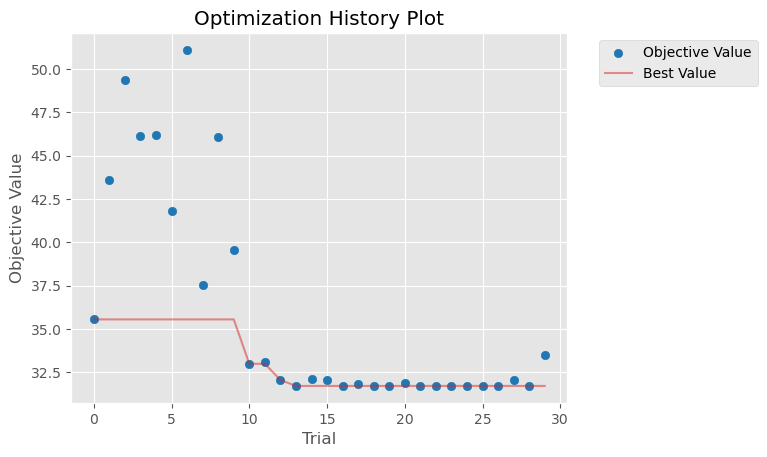

C:\Users\gandj\AppData\Local\Temp\ipykernel_82324\2053715424.py:44: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna_matplotlib.plot_param_importances(study_rfr)


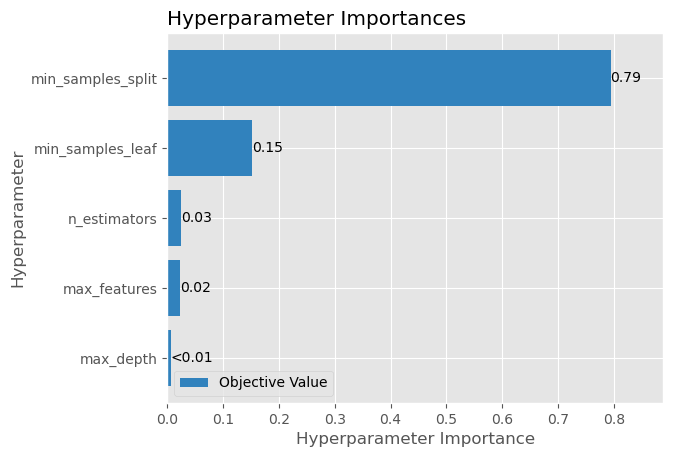

C:\Users\gandj\AppData\Local\Temp\ipykernel_82324\2053715424.py:47: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  optuna_matplotlib.plot_contour(study_rfr,params=['n_estimators','max_depth','min_samples_split','min_samples_leaf','max_features'])
[W 2025-02-20 23:52:34,809] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


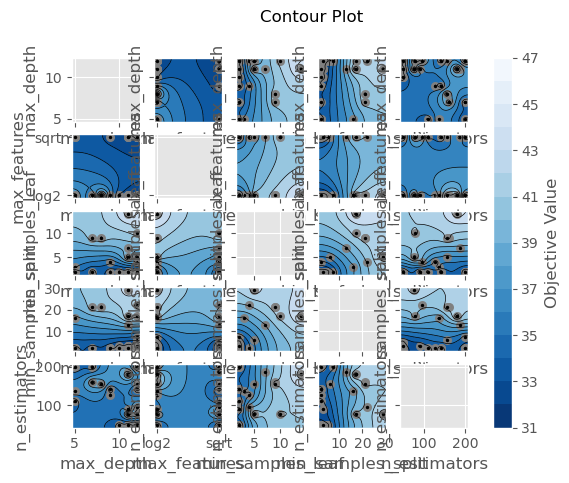

Text(0.5, 1.0, 'Train-Validation for RandomForest')

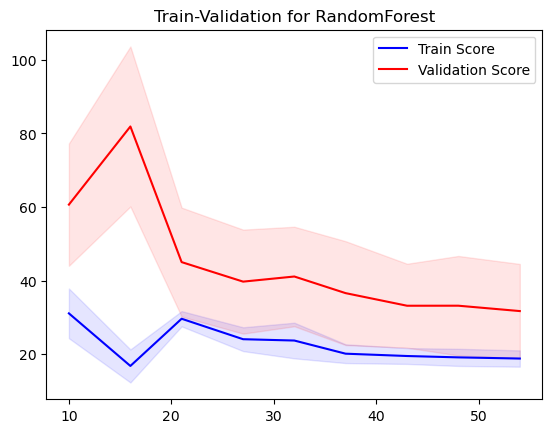

In [85]:
#RandomForest_CV
def create_pipeline_randfor(trial):
    #threshold=trial.suggest_float('threshold',0.01,0.05) #commented out => optuna_matplotlib.plot_param_importances() indicates that the parameter has the biggest impact on the tuning trials
    n_estimators=trial.suggest_int('n_estimators',50,200)
    max_depth=trial.suggest_int('max_depth',5,12)
    min_samples_split=trial.suggest_int('min_samples_split',2,30)
    min_samples_leaf=trial.suggest_int('min_samples_leaf',2,15)
    max_features=trial.suggest_categorical('max_features',['sqrt','log2'])

    pipeline=Pipeline(
        [
            ('rare_label',RareCategoryEncoder(feat="Opponent", tolerance=0.05)),
            ('mean_encoder',MeanEncoder(variables=['Opponent'])),
            ('discritization',DecisionTreeDiscretiser(cv=10, scoring="neg_root_mean_squared_error", regression=True, variables=['TD','Int','Sk','# TopReceiver','# TopRunningBacks'],random_state=101)),
            ('feature_select_cv',FeatureSelector_CV(threshold=0.05,random_state=101)),
            ('rfr_model',RandomForestRegressor(n_estimators=n_estimators,max_depth=max_depth,min_samples_split=min_samples_split,min_samples_leaf=min_samples_leaf,max_features=max_features,random_state=101))
        ]
    )
    return pipeline

def objective(trial):
    pipeline=create_pipeline_randfor(trial)
    scores=cross_val_score(pipeline, X_train, y_train,cv=KFold(n_splits=10,shuffle=True,random_state=101),
                           scoring="neg_root_mean_squared_error")
    return -scores.mean()

study_rfr=optuna.create_study(direction='minimize',sampler=GPSampler(seed=101),pruner=SuccessiveHalvingPruner())
start_time=time.time()
study_rfr.optimize(objective,n_trials=30)
end_time=time.time()

print(f"Best trial: {study_rfr.best_trial.params}")
#getting the best score
best_rfr_score=study_rfr.best_trial.value
print(f"Best trial Score (RMSE) for RandomForest_CV: {best_rfr_score}")
print(f'Run Time in Minutes: {(end_time - start_time)/60}')

dict_model_scores['Random_Forest_CV_Score']={'Score':best_rfr_score,'RunTime_In_Min':((end_time-start_time)/60)}

plt.figure(figsize=(10,6))
optuna_matplotlib.plot_optimization_history(study_rfr)
plt.show()
print('\n')
optuna_matplotlib.plot_param_importances(study_rfr)
plt.show()
print('\n')
optuna_matplotlib.plot_contour(study_rfr,params=['n_estimators','max_depth','min_samples_split','min_samples_leaf','max_features'])
plt.show()

best_pipeline = Pipeline(
    create_pipeline_randfor(study_rfr.best_trial).steps
)

train_sizes, train_scores, val_scores = learning_curve(best_pipeline, X_train, y_train, train_sizes=np.linspace(0.2,1.0,9),
                                        cv=KFold(n_splits=10,shuffle=True,random_state=101),scoring="neg_root_mean_squared_error",n_jobs=-1)

train_mean=-np.mean(train_scores,axis=1)
train_std=-np.std(train_scores,axis=1)
val_mean=-np.mean(val_scores,axis=1)
val_std=-np.std(val_scores,axis=1)

plt.style.use('default')
plt.plot(train_sizes,train_mean,color='blue',label='Train Score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')

plt.plot(train_sizes,val_mean,color='red',label='Validation Score')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='red')

plt.legend()
plt.title('Train-Validation for RandomForest')

C:\Users\gandj\AppData\Local\Temp\ipykernel_82324\3235800607.py:27: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  study_rfr=optuna.create_study(direction='minimize',sampler=GPSampler(seed=101),pruner=SuccessiveHalvingPruner())
[I 2025-02-20 23:53:32,623] A new study created in memory with name: no-name-2ca2e449-0499-44ef-a9c9-6302bbffc7f5
[I 2025-02-20 23:53:37,134] Trial 0 finished with value: 31.98260382951066 and parameters: {'n_estimators': 127, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 31.98260382951066.
[I 2025-02-20 23:53:41,632] Trial 1 finished with value: 41.69947354986839 and parameters: {'n_estimators': 96, 'max_depth': 12, 'min_samples_split': 22, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 0 with value: 31.98260382951066.
[I 2025-02-20 23:53:45,864] Trial 2 finished with value: 47.95599883484614 and parameters: {'n

Best trial: {'n_estimators': 200, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2'}
Best trial Score (RMSE) for RandomForest: 28.37031199362143
Run Time in Minutes: 2.413040014108022


C:\Users\gandj\AppData\Local\Temp\ipykernel_82324\3235800607.py:41: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna_matplotlib.plot_optimization_history(study_rfr)


<Figure size 1000x600 with 0 Axes>

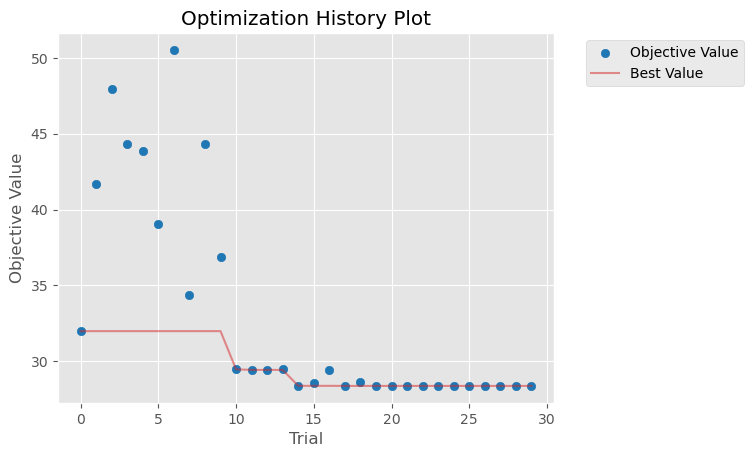

C:\Users\gandj\AppData\Local\Temp\ipykernel_82324\3235800607.py:44: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna_matplotlib.plot_param_importances(study_rfr)


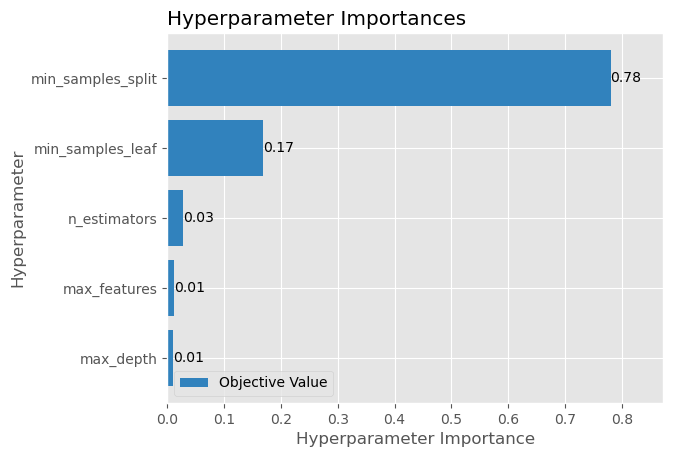

C:\Users\gandj\AppData\Local\Temp\ipykernel_82324\3235800607.py:47: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  optuna_matplotlib.plot_contour(study_rfr,params=['n_estimators','max_depth','min_samples_split','min_samples_leaf','max_features'])
[W 2025-02-20 23:55:57,665] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


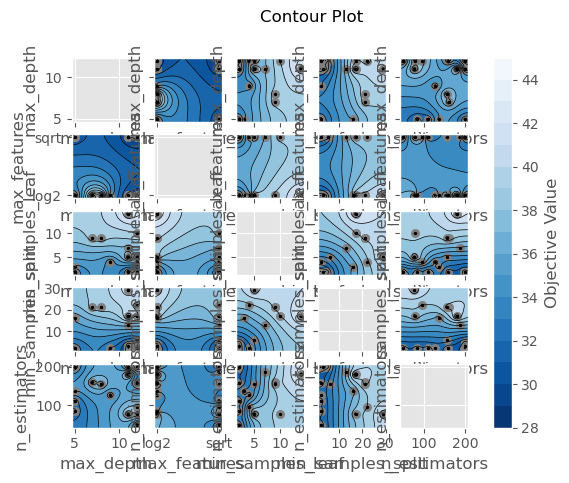

Text(0.5, 1.0, 'Train-Validation for RandomForest')

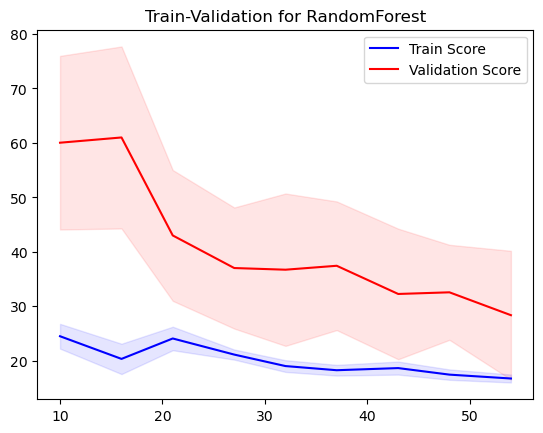

In [86]:
#RandomForest
def create_pipeline_randfor(trial):
    #threshold=trial.suggest_float('threshold',0.01,0.05) #commented out => optuna_matplotlib.plot_param_importances() indicates that the parameter has the biggest impact on the tuning trials
    n_estimators=trial.suggest_int('n_estimators',50,200)
    max_depth=trial.suggest_int('max_depth',5,12)
    min_samples_split=trial.suggest_int('min_samples_split',2,30)
    min_samples_leaf=trial.suggest_int('min_samples_leaf',2,15)
    max_features=trial.suggest_categorical('max_features',['sqrt','log2'])

    rfr_pipeline=Pipeline(
        [
            ('rare_label',RareCategoryEncoder(feat="Opponent", tolerance=0.05)),
            ('mean_encoder',MeanEncoder(variables=['Opponent'])),
            ('discritization',DecisionTreeDiscretiser(cv=10, scoring="neg_root_mean_squared_error", regression=True, variables=['TD','Int','Sk','# TopReceiver','# TopRunningBacks'],random_state=101)),
            ('feature_select',FeatureSelector(threshold=0.05,random_state=101)),
            ('rfr_model',RandomForestRegressor(n_estimators=n_estimators,max_depth=max_depth,min_samples_split=min_samples_split,min_samples_leaf=min_samples_leaf,max_features=max_features,random_state=101))
        ]
    )
    return rfr_pipeline

def objective(trial):
    pipeline=create_pipeline_randfor(trial)
    scores=cross_val_score(pipeline, X_train, y_train,cv=KFold(n_splits=10,shuffle=True,random_state=101),
                           scoring="neg_root_mean_squared_error")
    return -scores.mean()

study_rfr=optuna.create_study(direction='minimize',sampler=GPSampler(seed=101),pruner=SuccessiveHalvingPruner())
start_time=time.time()
study_rfr.optimize(objective,n_trials=30)
end_time=time.time()

print(f"Best trial: {study_rfr.best_trial.params}")
#getting the best score
best_rfr_score=study_rfr.best_trial.value
print(f"Best trial Score (RMSE) for RandomForest: {best_rfr_score}")
print(f'Run Time in Minutes: {(end_time - start_time)/60}')

dict_model_scores['Random_Forest_Score']={'Score':best_rfr_score,'RunTime_In_Min':((end_time-start_time)/60)}

plt.figure(figsize=(10,6))
optuna_matplotlib.plot_optimization_history(study_rfr)
plt.show()
print('\n')
optuna_matplotlib.plot_param_importances(study_rfr)
plt.show()
print('\n')
optuna_matplotlib.plot_contour(study_rfr,params=['n_estimators','max_depth','min_samples_split','min_samples_leaf','max_features'])
plt.show()

best_pipeline = Pipeline(
    create_pipeline_randfor(study_rfr.best_trial).steps
)

train_sizes, train_scores, val_scores = learning_curve(best_pipeline, X_train, y_train, train_sizes=np.linspace(0.2,1.0,9),
                                        cv=KFold(n_splits=10,shuffle=True,random_state=101),scoring="neg_root_mean_squared_error",n_jobs=-1)

train_mean=-np.mean(train_scores,axis=1)
train_std=-np.std(train_scores,axis=1)
val_mean=-np.mean(val_scores,axis=1)
val_std=-np.std(val_scores,axis=1)

plt.style.use('default')
plt.plot(train_sizes,train_mean,color='blue',label='Train Score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')

plt.plot(train_sizes,val_mean,color='red',label='Validation Score')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='red')

plt.legend()
plt.title('Train-Validation for RandomForest')

### Gradient Boosting Regression

C:\Users\gandj\AppData\Local\Temp\ipykernel_82324\2314474973.py:29: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  study_gbr=optuna.create_study(direction='minimize',sampler=GPSampler(seed=101),pruner=SuccessiveHalvingPruner())
[I 2025-02-20 23:56:08,797] A new study created in memory with name: no-name-70e74068-b0c3-47e9-9126-041f0000d95c
[I 2025-02-20 23:56:33,084] Trial 0 finished with value: 22.890436381844395 and parameters: {'n_estimators': 92, 'learning_rate': 0.021413351737362793, 'min_samples_split': 10, 'min_samples_leaf': 6, 'criterion': 'squared_error', 'loss': 'huber', 'max_depth': 5}. Best is trial 0 with value: 22.890436381844395.
[I 2025-02-20 23:56:57,690] Trial 1 finished with value: 24.933644870989585 and parameters: {'n_estimators': 52, 'learning_rate': 0.02108455182249574, 'min_samples_split': 13, 'min_samples_leaf': 6, 'criterion': 'squared_error', 'loss': 'absolute_error', 'max_depth': 5}. Best is

Best trial: {'n_estimators': 150, 'learning_rate': 0.017428857465258175, 'min_samples_split': 20, 'min_samples_leaf': 5, 'criterion': 'friedman_mse', 'loss': 'huber', 'max_depth': 6}
Best trial Score (RMSE) for Gradient Boosting_CV: 19.017535981412415
Run Time in Minutes: 12.296365809440612


C:\Users\gandj\AppData\Local\Temp\ipykernel_82324\2314474973.py:43: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna_matplotlib.plot_optimization_history(study_gbr)


<Figure size 1000x600 with 0 Axes>

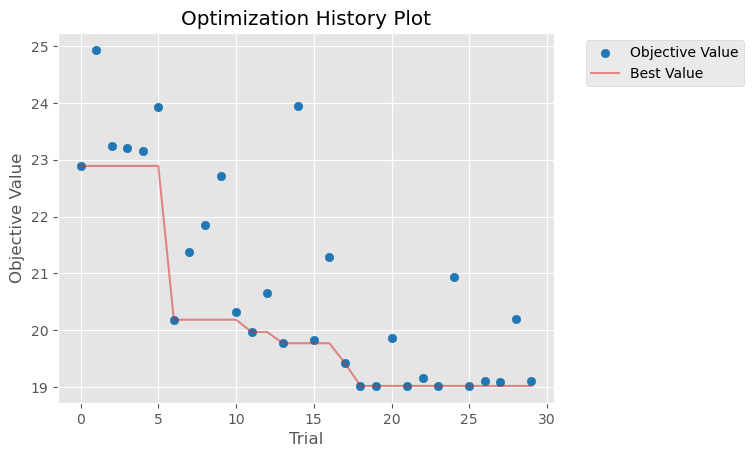

C:\Users\gandj\AppData\Local\Temp\ipykernel_82324\2314474973.py:46: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna_matplotlib.plot_param_importances(study_gbr)


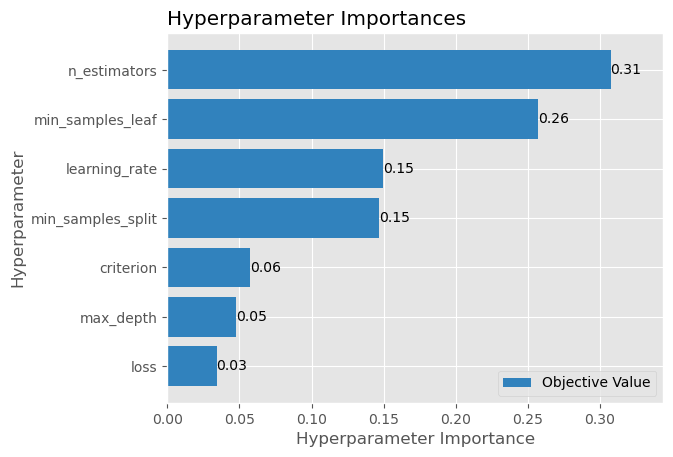

C:\Users\gandj\AppData\Local\Temp\ipykernel_82324\2314474973.py:49: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  optuna_matplotlib.plot_contour(study_gbr,params=['n_estimators','learning_rate','max_depth','min_samples_split','min_samples_leaf','criterion','loss'])
[W 2025-02-21 00:08:26,892] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


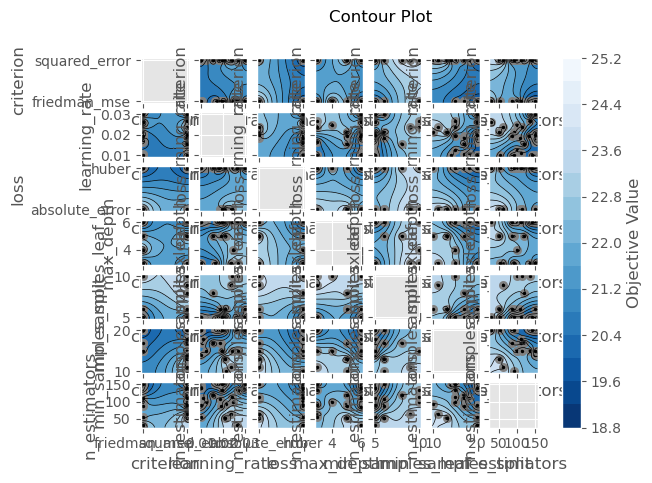

Text(0.5, 1.0, 'Train-Validation for Gradient Boosting Regressor')

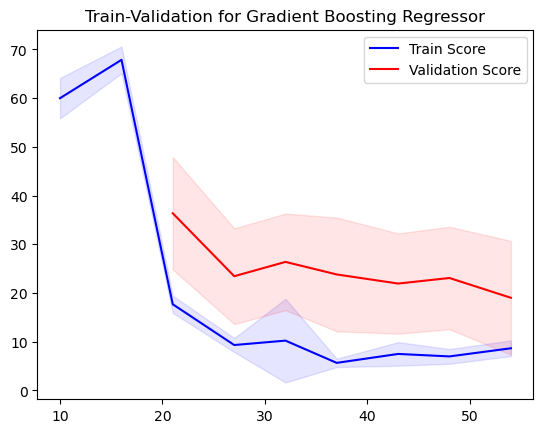

In [87]:
#GradientBoosting_CV
def create_pipeline_randfor(trial):
    n_estimators=trial.suggest_int('n_estimators',30,150)
    learning_rate=trial.suggest_float('learning_rate',0.01,0.03)
    min_samples_split=trial.suggest_int('min_samples_split',10,20)
    min_samples_leaf=trial.suggest_int('min_samples_leaf',5,10)
    criterion=trial.suggest_categorical('criterion',['friedman_mse','squared_error'])
    loss=trial.suggest_categorical('loss',['absolute_error', 'huber'])
    max_depth=trial.suggest_int('max_depth',3,6)

    pipeline=Pipeline(
        [
            ('rare_label',RareCategoryEncoder(feat="Opponent", tolerance=0.05)),
            ('mean_encoder',MeanEncoder(variables=['Opponent'])),
            ('discritization',DecisionTreeDiscretiser(cv=10, scoring="neg_root_mean_squared_error", regression=True, variables=['TD','Int','Sk','# TopReceiver','# TopRunningBacks'],random_state=101)),
            ('feature_select_cv',FeatureSelector_CV(threshold=0.05,random_state=101)),
            ('gbr_model',GradientBoostingRegressor(n_estimators=n_estimators,max_depth=max_depth,min_samples_split=min_samples_split,min_samples_leaf=min_samples_leaf,criterion=criterion,
                                                   loss=loss,random_state=101))
        ]
    )
    return pipeline

def objective(trial):
    pipeline=create_pipeline_randfor(trial)
    scores=cross_val_score(pipeline, X_train, y_train,cv=KFold(n_splits=10,shuffle=True,random_state=101),
                           scoring="neg_root_mean_squared_error")
    return -scores.mean()

study_gbr=optuna.create_study(direction='minimize',sampler=GPSampler(seed=101),pruner=SuccessiveHalvingPruner())
start_time=time.time()
study_gbr.optimize(objective,n_trials=30)
end_time=time.time()

print(f"Best trial: {study_gbr.best_trial.params}")
#getting the best score
best_gbr_score=study_gbr.best_trial.value
print(f"Best trial Score (RMSE) for Gradient Boosting_CV: {best_gbr_score}")
print(f'Run Time in Minutes: {(end_time - start_time)/60}')

dict_model_scores['Gradient_Boosting_CV_Score']={'Score':best_gbr_score,'RunTime_In_Min':((end_time-start_time)/60)}

plt.figure(figsize=(10,6))
optuna_matplotlib.plot_optimization_history(study_gbr)
plt.show()
print('\n')
optuna_matplotlib.plot_param_importances(study_gbr)
plt.show()
print('\n')
optuna_matplotlib.plot_contour(study_gbr,params=['n_estimators','learning_rate','max_depth','min_samples_split','min_samples_leaf','criterion','loss'])
plt.show()

best_pipeline = Pipeline(
    create_pipeline_randfor(study_gbr.best_trial).steps
)

train_sizes, train_scores, val_scores = learning_curve(best_pipeline, X_train, y_train, train_sizes=np.linspace(0.2,1.0,9),
                                        cv=KFold(n_splits=10,shuffle=True,random_state=101),scoring="neg_root_mean_squared_error",n_jobs=-1)

train_mean=-np.mean(train_scores,axis=1)
train_std=-np.std(train_scores,axis=1)
val_mean=-np.mean(val_scores,axis=1)
val_std=-np.std(val_scores,axis=1)

plt.style.use('default')
plt.plot(train_sizes,train_mean,color='blue',label='Train Score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')

plt.plot(train_sizes,val_mean,color='red',label='Validation Score')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='red')

plt.legend()
plt.title('Train-Validation for Gradient Boosting Regressor')

C:\Users\gandj\AppData\Local\Temp\ipykernel_82324\3883540629.py:29: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  study_gbr=optuna.create_study(direction='minimize',sampler=GPSampler(seed=101),pruner=SuccessiveHalvingPruner())
[I 2025-02-21 00:09:28,130] A new study created in memory with name: no-name-b5363a00-811d-49b4-a8ee-8eac92220e21
[I 2025-02-21 00:09:32,937] Trial 0 finished with value: 22.709178242203286 and parameters: {'n_estimators': 92, 'learning_rate': 0.021413351737362793, 'min_samples_split': 10, 'min_samples_leaf': 6, 'criterion': 'squared_error', 'loss': 'huber', 'max_depth': 5}. Best is trial 0 with value: 22.709178242203286.
[I 2025-02-21 00:09:37,235] Trial 1 finished with value: 24.170949714774753 and parameters: {'n_estimators': 52, 'learning_rate': 0.02108455182249574, 'min_samples_split': 13, 'min_samples_leaf': 6, 'criterion': 'squared_error', 'loss': 'absolute_error', 'max_depth': 5}. Best is

Best trial: {'n_estimators': 150, 'learning_rate': 0.03, 'min_samples_split': 20, 'min_samples_leaf': 5, 'criterion': 'squared_error', 'loss': 'huber', 'max_depth': 3}
Best trial Score (RMSE) for Gradient Boosting: 19.427175295632967
Run Time in Minutes: 2.5042538046836853


C:\Users\gandj\AppData\Local\Temp\ipykernel_82324\3883540629.py:43: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna_matplotlib.plot_optimization_history(study_gbr)


<Figure size 1000x600 with 0 Axes>

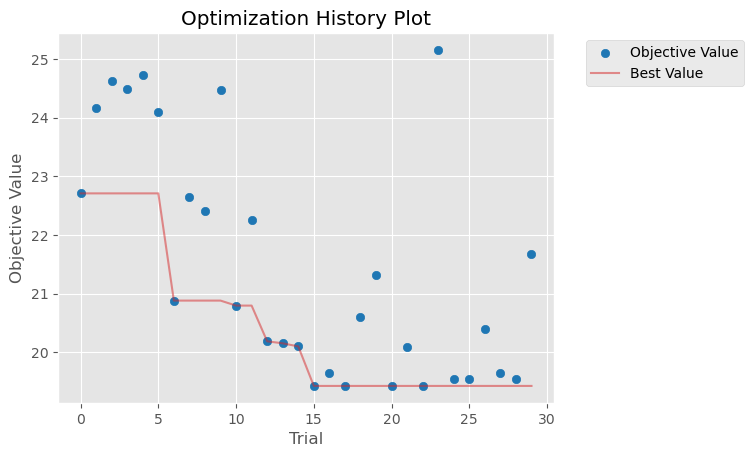

C:\Users\gandj\AppData\Local\Temp\ipykernel_82324\3883540629.py:46: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna_matplotlib.plot_param_importances(study_gbr)


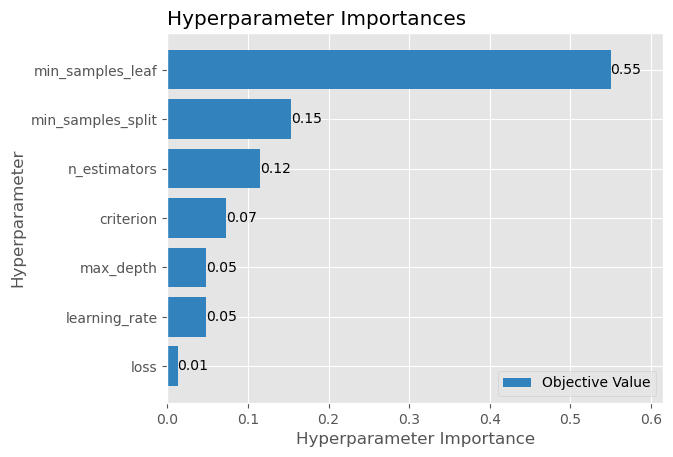

C:\Users\gandj\AppData\Local\Temp\ipykernel_82324\3883540629.py:49: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  optuna_matplotlib.plot_contour(study_gbr,params=['n_estimators','learning_rate','max_depth','min_samples_split','min_samples_leaf','criterion','loss'])
[W 2025-02-21 00:11:58,704] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


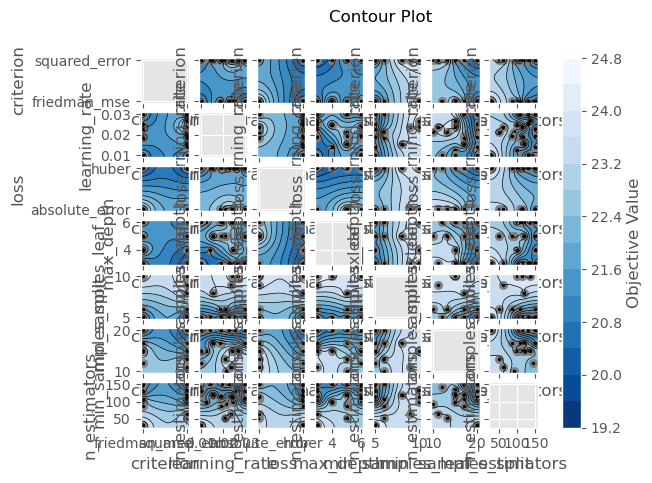

Text(0.5, 1.0, 'Train-Validation for Gradient Boosting Regressor')

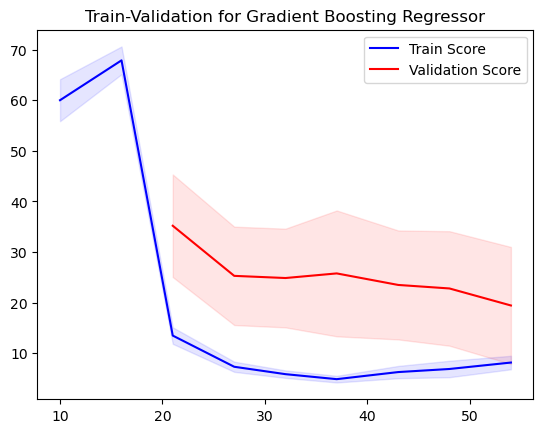

In [88]:
#GradientBoosting
def create_pipeline_randfor(trial):
    n_estimators=trial.suggest_int('n_estimators',30,150)
    learning_rate=trial.suggest_float('learning_rate',0.01,0.03)
    min_samples_split=trial.suggest_int('min_samples_split',10,20)
    min_samples_leaf=trial.suggest_int('min_samples_leaf',5,10)
    criterion=trial.suggest_categorical('criterion',['friedman_mse','squared_error'])
    loss=trial.suggest_categorical('loss',['absolute_error', 'huber'])
    max_depth=trial.suggest_int('max_depth',3,6)

    rfr_pipeline=Pipeline(
        [
            ('rare_label',RareCategoryEncoder(feat="Opponent", tolerance=0.05)),
            ('mean_encoder',MeanEncoder(variables=['Opponent'])),
            ('discritization',DecisionTreeDiscretiser(cv=10, scoring="neg_root_mean_squared_error", regression=True, variables=['TD','Int','Sk','# TopReceiver','# TopRunningBacks'],random_state=101)),
            ('feature_select',FeatureSelector(threshold=0.05,random_state=101)),
            ('gbr_model',GradientBoostingRegressor(n_estimators=n_estimators,max_depth=max_depth,min_samples_split=min_samples_split,min_samples_leaf=min_samples_leaf,criterion=criterion,
                                                   loss=loss,random_state=101))
        ]
    )
    return rfr_pipeline

def objective(trial):
    pipeline=create_pipeline_randfor(trial)
    scores=cross_val_score(pipeline, X_train, y_train,cv=KFold(n_splits=10,shuffle=True,random_state=101),
                           scoring="neg_root_mean_squared_error")
    return -scores.mean()

study_gbr=optuna.create_study(direction='minimize',sampler=GPSampler(seed=101),pruner=SuccessiveHalvingPruner())
start_time=time.time()
study_gbr.optimize(objective,n_trials=30)
end_time=time.time()

print(f"Best trial: {study_gbr.best_trial.params}")
#getting the best score
best_gbr_score=study_gbr.best_trial.value
print(f"Best trial Score (RMSE) for Gradient Boosting: {best_gbr_score}")
print(f'Run Time in Minutes: {(end_time - start_time)/60}')

dict_model_scores['Gradient_Boosting_Score']={'Score':best_gbr_score,'RunTime_In_Min':((end_time-start_time)/60)}

plt.figure(figsize=(10,6))
optuna_matplotlib.plot_optimization_history(study_gbr)
plt.show()
print('\n')
optuna_matplotlib.plot_param_importances(study_gbr)
plt.show()
print('\n')
optuna_matplotlib.plot_contour(study_gbr,params=['n_estimators','learning_rate','max_depth','min_samples_split','min_samples_leaf','criterion','loss'])
plt.show()

best_pipeline = Pipeline(
    create_pipeline_randfor(study_gbr.best_trial).steps
)

train_sizes, train_scores, val_scores = learning_curve(best_pipeline, X_train, y_train, train_sizes=np.linspace(0.2,1.0,9),
                                        cv=KFold(n_splits=10,shuffle=True,random_state=101),scoring="neg_root_mean_squared_error",n_jobs=-1)

train_mean=-np.mean(train_scores,axis=1)
train_std=-np.std(train_scores,axis=1)
val_mean=-np.mean(val_scores,axis=1)
val_std=-np.std(val_scores,axis=1)

plt.style.use('default')
plt.plot(train_sizes,train_mean,color='blue',label='Train Score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')

plt.plot(train_sizes,val_mean,color='red',label='Validation Score')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='red')

plt.legend()
plt.title('Train-Validation for Gradient Boosting Regressor')

### Kernel Ridge Regression

C:\Users\gandj\AppData\Local\Temp\ipykernel_82324\782005756.py:30: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  study_krr=optuna.create_study(direction='minimize',sampler=GPSampler(seed=101),pruner=SuccessiveHalvingPruner())
[I 2025-02-21 00:12:11,894] A new study created in memory with name: no-name-4bf36114-fdce-4cc4-8055-c0e015da00b8
[I 2025-02-21 00:12:35,755] Trial 0 finished with value: 30.41786865993735 and parameters: {'alpha': 0.026303532757419864, 'kernel': 'linear'}. Best is trial 0 with value: 30.41786865993735.
[I 2025-02-21 00:12:59,424] Trial 1 finished with value: 189.6580483706425 and parameters: {'alpha': 0.00940456115503005, 'kernel': 'rbf', 'gamma': 0.3070355230502706}. Best is trial 0 with value: 30.41786865993735.
[I 2025-02-21 00:13:23,166] Trial 2 finished with value: 30.41785610198818 and parameters: {'alpha': 0.04478704090448647, 'kernel': 'linear'}. Best is trial 2 with value: 30.41785610198

Best trial: {'alpha': 0.05, 'kernel': 'linear'}
Best trial Score (RMSE) for Kernel Ridge_CV: 30.417852573635848
Run Time in Minutes: 11.839874605337778


C:\Users\gandj\AppData\Local\Temp\ipykernel_82324\782005756.py:44: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna_matplotlib.plot_optimization_history(study_krr)


<Figure size 1000x600 with 0 Axes>

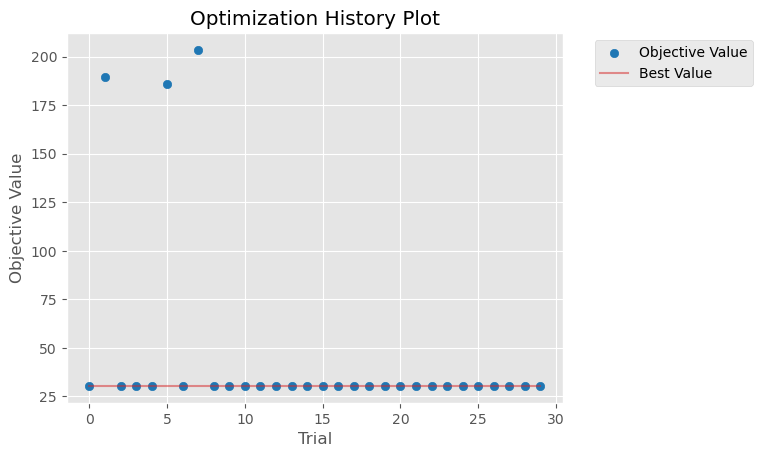

C:\Users\gandj\AppData\Local\Temp\ipykernel_82324\782005756.py:47: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna_matplotlib.plot_param_importances(study_krr)


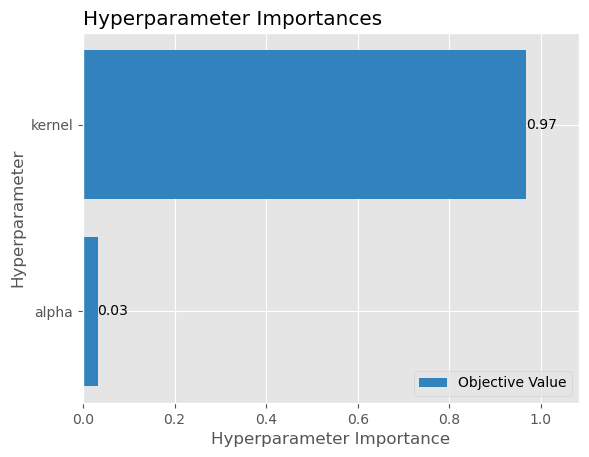

C:\Users\gandj\AppData\Local\Temp\ipykernel_82324\782005756.py:50: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  optuna_matplotlib.plot_contour(study_krr,params=['alpha','kernel','gamma'])
[W 2025-02-21 00:24:02,512] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


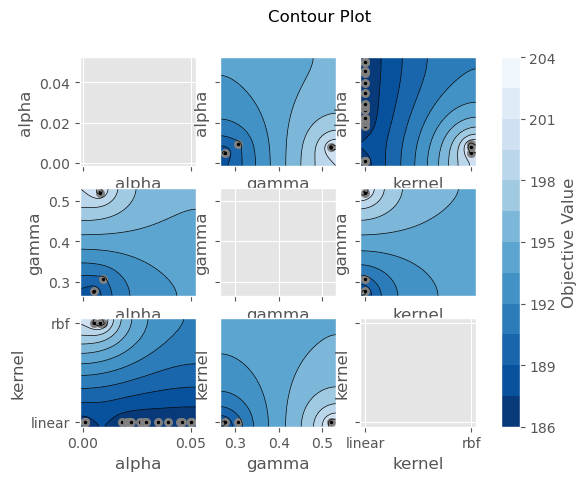

Text(0.5, 1.0, 'Train-Validation for Kernel Ridge Regression')

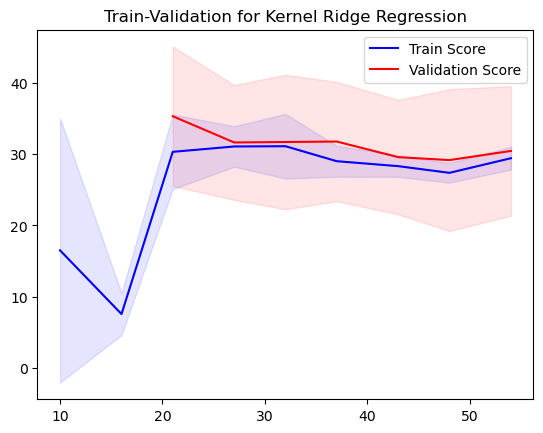

In [89]:
#Kernel RIdge Regression_CV
def create_pipeline_randfor(trial):
    alpha = trial.suggest_float('alpha', 0.001, 0.05)
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf'])

    #here we define hyperparameters selectively
    params = {'alpha': alpha, 'kernel': kernel}

    #based on the selected kernel, additional hyperparameter will be included in the model
    if kernel in ['rbf']:
        params['gamma'] = trial.suggest_float('gamma', 0.0001,1.0)

    pipeline=Pipeline(
        [
            ('rare_label',RareCategoryEncoder(feat="Opponent", tolerance=0.05)),
            ('mean_encoder',MeanEncoder(variables=['Opponent'])),
            ('discritization',DecisionTreeDiscretiser(cv=10, scoring="neg_root_mean_squared_error", regression=True, variables=['TD','Int','Sk','# TopReceiver','# TopRunningBacks'],random_state=101)),
            ('feature_select_cv',FeatureSelector_CV(threshold=0.05,random_state=101)),
            ('gbr_model',KernelRidge(**params))
        ]
    )
    return pipeline

def objective(trial):
    pipeline=create_pipeline_randfor(trial)
    scores=cross_val_score(pipeline, X_train, y_train,cv=KFold(n_splits=10,shuffle=True,random_state=101),
                           scoring="neg_root_mean_squared_error")
    return -scores.mean()

study_krr=optuna.create_study(direction='minimize',sampler=GPSampler(seed=101),pruner=SuccessiveHalvingPruner())
start_time=time.time()
study_krr.optimize(objective,n_trials=30)
end_time=time.time()

print(f"Best trial: {study_krr.best_trial.params}")
#getting the best score
best_krr_score=study_krr.best_trial.value
print(f"Best trial Score (RMSE) for Kernel Ridge_CV: {best_krr_score}")
print(f'Run Time in Minutes: {(end_time - start_time)/60}')

dict_model_scores['Kernel_Ridge_CV_Score']={'Score':best_krr_score,'RunTime_In_Min':((end_time-start_time)/60)}

plt.figure(figsize=(10,6))
optuna_matplotlib.plot_optimization_history(study_krr)
plt.show()
print('\n')
optuna_matplotlib.plot_param_importances(study_krr)
plt.show()
print('\n')
optuna_matplotlib.plot_contour(study_krr,params=['alpha','kernel','gamma'])
plt.show()

best_pipeline = Pipeline(
    create_pipeline_randfor(study_krr.best_trial).steps
)

train_sizes, train_scores, val_scores = learning_curve(best_pipeline, X_train, y_train, train_sizes=np.linspace(0.2,1.0,9),
                                        cv=KFold(n_splits=10,shuffle=True,random_state=101),scoring="neg_root_mean_squared_error",n_jobs=-1)

train_mean=-np.mean(train_scores,axis=1)
train_std=-np.std(train_scores,axis=1)
val_mean=-np.mean(val_scores,axis=1)
val_std=-np.std(val_scores,axis=1)

plt.style.use('default')
plt.plot(train_sizes,train_mean,color='blue',label='Train Score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')

plt.plot(train_sizes,val_mean,color='red',label='Validation Score')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='red')

plt.legend()
plt.title('Train-Validation for Kernel Ridge Regression')

C:\Users\gandj\AppData\Local\Temp\ipykernel_82324\3812684026.py:30: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  study_krr=optuna.create_study(direction='minimize',sampler=GPSampler(seed=101),pruner=SuccessiveHalvingPruner())
[I 2025-02-21 00:24:59,088] A new study created in memory with name: no-name-a3cc356e-2158-4ba3-be9b-afe23df0e3b7
[I 2025-02-21 00:25:02,986] Trial 0 finished with value: 27.95629088855991 and parameters: {'alpha': 0.026303532757419864, 'kernel': 'linear'}. Best is trial 0 with value: 27.95629088855991.
[I 2025-02-21 00:25:06,869] Trial 1 finished with value: 225.05743239854533 and parameters: {'alpha': 0.00940456115503005, 'kernel': 'rbf', 'gamma': 0.3070355230502706}. Best is trial 0 with value: 27.95629088855991.
[I 2025-02-21 00:25:10,958] Trial 2 finished with value: 27.955926278099987 and parameters: {'alpha': 0.04478704090448647, 'kernel': 'linear'}. Best is trial 2 with value: 27.95592627

Best trial: {'alpha': 0.05, 'kernel': 'linear'}
Best trial Score (RMSE) for Kernel Ridge: 27.955823509165366
Run Time in Minutes: 2.000651443004608


C:\Users\gandj\AppData\Local\Temp\ipykernel_82324\3812684026.py:44: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna_matplotlib.plot_optimization_history(study_krr)


<Figure size 1000x600 with 0 Axes>

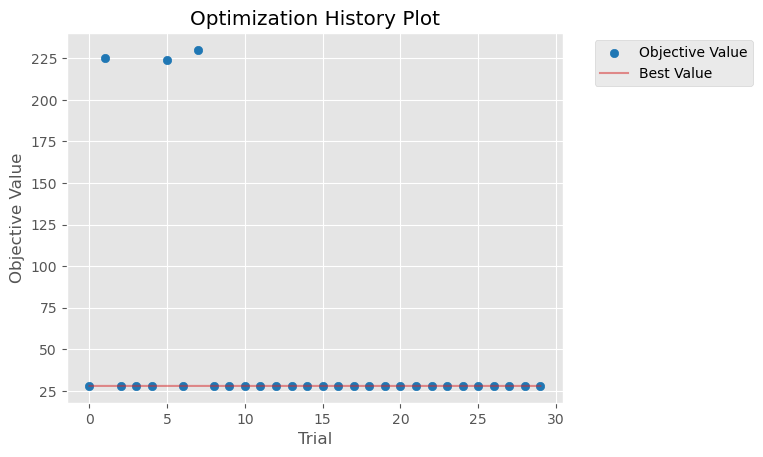

C:\Users\gandj\AppData\Local\Temp\ipykernel_82324\3812684026.py:47: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna_matplotlib.plot_param_importances(study_krr)


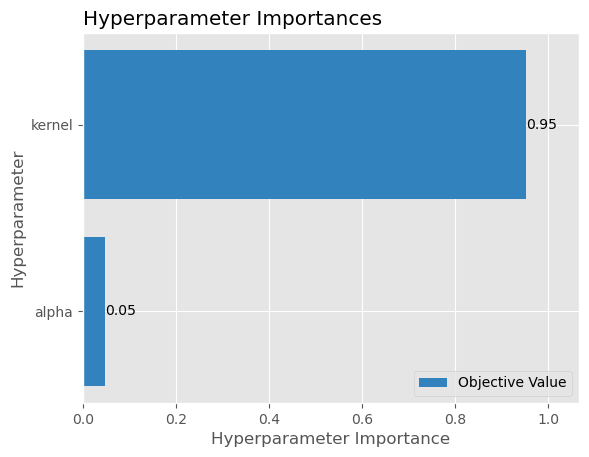

C:\Users\gandj\AppData\Local\Temp\ipykernel_82324\3812684026.py:50: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  optuna_matplotlib.plot_contour(study_krr,params=['alpha','kernel','gamma'])
[W 2025-02-21 00:26:59,367] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


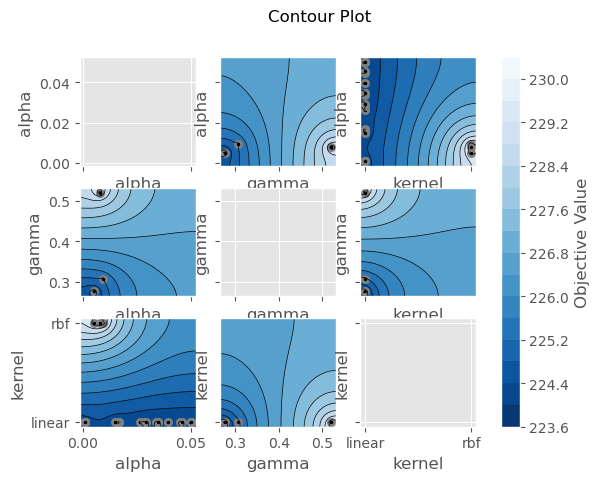

Text(0.5, 1.0, 'Train-Validation for Kernel Ridge Regression')

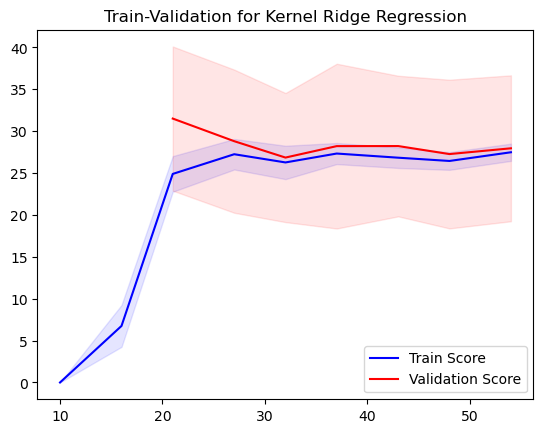

In [90]:
#Kernel Ridge Regression
def create_pipeline_randfor(trial):
    alpha = trial.suggest_float('alpha', 0.001, 0.05)
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf'])

    #here we define hyperparameters selectively
    params = {'alpha': alpha, 'kernel': kernel}

    #based on the selected kernel, additional hyperparameter will be included in the model
    if kernel in ['rbf']:
        params['gamma'] = trial.suggest_float('gamma', 0.0001,1.0)

    pipeline=Pipeline(
        [
            ('rare_label',RareCategoryEncoder(feat="Opponent", tolerance=0.05)),
            ('mean_encoder',MeanEncoder(variables=['Opponent'])),
            ('discritization',DecisionTreeDiscretiser(cv=10, scoring="neg_root_mean_squared_error", regression=True, variables=['TD','Int','Sk','# TopReceiver','# TopRunningBacks'],random_state=101)),
            ('feature_select',FeatureSelector(threshold=0.05,random_state=101)),
            ('gbr_model',KernelRidge(**params))
        ]
    )
    return pipeline

def objective(trial):
    pipeline=create_pipeline_randfor(trial)
    scores=cross_val_score(pipeline, X_train, y_train,cv=KFold(n_splits=10,shuffle=True,random_state=101),
                           scoring="neg_root_mean_squared_error")
    return -scores.mean()

study_krr=optuna.create_study(direction='minimize',sampler=GPSampler(seed=101),pruner=SuccessiveHalvingPruner())
start_time=time.time()
study_krr.optimize(objective,n_trials=30)
end_time=time.time()

print(f"Best trial: {study_krr.best_trial.params}")
#getting the best score
best_krr_score=study_krr.best_trial.value
print(f"Best trial Score (RMSE) for Kernel Ridge: {best_krr_score}")
print(f'Run Time in Minutes: {(end_time - start_time)/60}')

dict_model_scores['Kernel_Ridge_Score']={'Score':best_krr_score,'RunTime_In_Min':((end_time-start_time)/60)}

plt.figure(figsize=(10,6))
optuna_matplotlib.plot_optimization_history(study_krr)
plt.show()
print('\n')
optuna_matplotlib.plot_param_importances(study_krr)
plt.show()
print('\n')
optuna_matplotlib.plot_contour(study_krr,params=['alpha','kernel','gamma'])
plt.show()

best_pipeline = Pipeline(
    create_pipeline_randfor(study_krr.best_trial).steps
)

train_sizes, train_scores, val_scores = learning_curve(best_pipeline, X_train, y_train, train_sizes=np.linspace(0.2,1.0,9),
                                        cv=KFold(n_splits=10,shuffle=True,random_state=101),scoring="neg_root_mean_squared_error",n_jobs=-1)

train_mean=-np.mean(train_scores,axis=1)
train_std=-np.std(train_scores,axis=1)
val_mean=-np.mean(val_scores,axis=1)
val_std=-np.std(val_scores,axis=1)

plt.style.use('default')
plt.plot(train_sizes,train_mean,color='blue',label='Train Score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')

plt.plot(train_sizes,val_mean,color='red',label='Validation Score')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='red')

plt.legend()
plt.title('Train-Validation for Kernel Ridge Regression')

### XGBoost Regressor

C:\Users\gandj\AppData\Local\Temp\ipykernel_82324\1111716347.py:30: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  study_xgb=optuna.create_study(direction='minimize',sampler=GPSampler(seed=101),pruner=SuccessiveHalvingPruner())
[I 2025-02-21 00:27:07,381] A new study created in memory with name: no-name-b7eab338-838c-4b45-8bac-8ff1fdea99fb
C:\Users\gandj\anaconda3\Lib\site-packages\optuna\trial\_trial.py:678: RuntimeWarning: Inconsistent parameter values for distribution with name "learning_rate"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'step': None, 'low': 0.001, 'high': 0.1, 'log': False}
  warnings.warn(
[I 2025-02-21 00:27:32,154] Trial 0 finished with value: 24.695690846700032 and parameters: 

Best trial: {'n_estimators': 200, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2'}
Best trial Score (RMSE) for XGBoost_CV: 20.21303780065555
Run Time in Minutes: 12.525460501511892


C:\Users\gandj\AppData\Local\Temp\ipykernel_82324\1111716347.py:44: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna_matplotlib.plot_optimization_history(study_xgb)


<Figure size 1000x600 with 0 Axes>

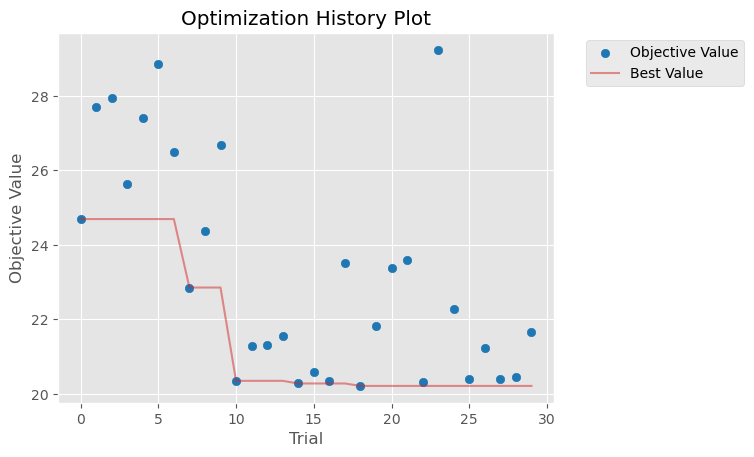

C:\Users\gandj\AppData\Local\Temp\ipykernel_82324\1111716347.py:47: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna_matplotlib.plot_param_importances(study_xgb)


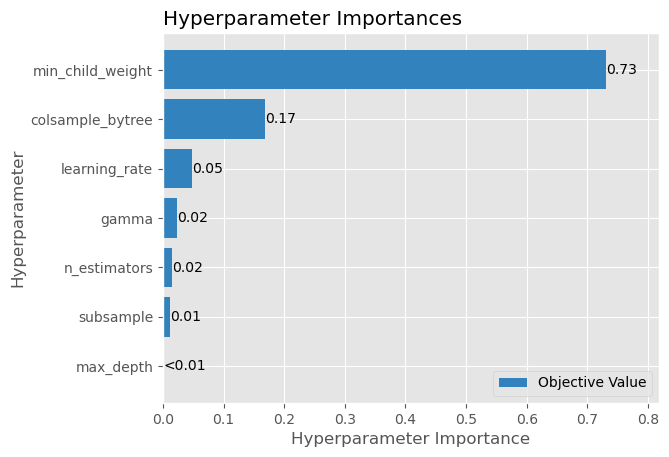

C:\Users\gandj\AppData\Local\Temp\ipykernel_82324\1111716347.py:50: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  optuna_matplotlib.plot_contour(study_xgb,params=['n_estimators','max_depth','min_child_weight','subsample','colsample_bytree','gamma','learning_rate'])
[W 2025-02-21 00:39:39,277] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


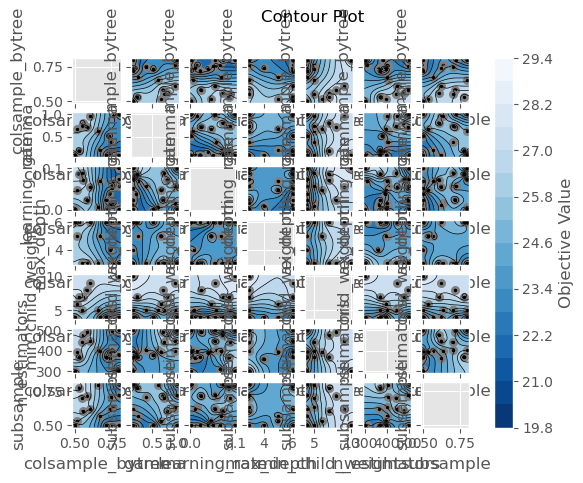

Text(0.5, 1.0, 'Train-Validation for XGBoost Regressor')

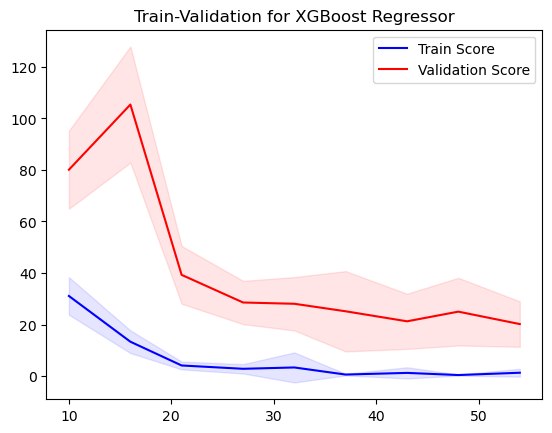

In [91]:
#XGBoost Regression_CV
def create_pipeline_randfor(trial):
    n_estimators=trial.suggest_int('n_estimators',300,500)
    learning_rate=trial.suggest_float('learning_rate',0.001,0.1)
    max_depth=trial.suggest_int('max_depth',3,6)
    min_child_weight=trial.suggest_int('min_child_weight',4,10)
    subsample=trial.suggest_float('subsample',0.5,0.8)
    colsample_bytree=trial.suggest_float('colsample_bytree',0.5,0.8)
    gamma=trial.suggest_float('gamma',0.1,1.0)
    learning_rate=trial.suggest_float('learning_rate',0.005,0.02)

    pipeline=Pipeline(
        [
            ('rare_label',RareCategoryEncoder(feat="Opponent", tolerance=0.05)),
            ('mean_encoder',MeanEncoder(variables=['Opponent'])),
            ('discritization',DecisionTreeDiscretiser(cv=10, scoring="neg_root_mean_squared_error", regression=True, variables=['TD','Int','Sk','# TopReceiver','# TopRunningBacks'],random_state=101)),
            ('feature_select_cv',FeatureSelector_CV(threshold=0.05,random_state=101)),
            ('xgb_model',XGBRegressor(n_estimators=n_estimators,max_depth=max_depth,min_child_weight=min_child_weight,subsample=subsample,colsample_bytree=colsample_bytree,
                                      gamma=gamma,random_state=101))
        ]
    )
    return pipeline

def objective(trial):
    pipeline=create_pipeline_randfor(trial)
    scores=cross_val_score(pipeline, X_train, y_train,cv=KFold(n_splits=10,shuffle=True,random_state=101),
                           scoring="neg_root_mean_squared_error")
    return -scores.mean()

study_xgb=optuna.create_study(direction='minimize',sampler=GPSampler(seed=101),pruner=SuccessiveHalvingPruner())
start_time=time.time()
study_xgb.optimize(objective,n_trials=30)
end_time=time.time()

print(f"Best trial: {study_rfr.best_trial.params}")
#getting the best score
best_xgb_score=study_xgb.best_trial.value
print(f"Best trial Score (RMSE) for XGBoost_CV: {best_xgb_score}")
print(f'Run Time in Minutes: {(end_time - start_time)/60}')

dict_model_scores['XGBoost_CV_Score']={'Score':best_rfr_score,'RunTime_In_Min':((end_time-start_time)/60)}

plt.figure(figsize=(10,6))
optuna_matplotlib.plot_optimization_history(study_xgb)
plt.show()
print('\n')
optuna_matplotlib.plot_param_importances(study_xgb)
plt.show()
print('\n')
optuna_matplotlib.plot_contour(study_xgb,params=['n_estimators','max_depth','min_child_weight','subsample','colsample_bytree','gamma','learning_rate'])
plt.show()

best_pipeline = Pipeline(
    create_pipeline_randfor(study_xgb.best_trial).steps
)

train_sizes, train_scores, val_scores = learning_curve(best_pipeline, X_train, y_train, train_sizes=np.linspace(0.2,1.0,9),
                                        cv=KFold(n_splits=10,shuffle=True,random_state=101),scoring="neg_root_mean_squared_error",n_jobs=-1)

train_mean=-np.mean(train_scores,axis=1)
train_std=-np.std(train_scores,axis=1)
val_mean=-np.mean(val_scores,axis=1)
val_std=-np.std(val_scores,axis=1)

plt.style.use('default')
plt.plot(train_sizes,train_mean,color='blue',label='Train Score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')

plt.plot(train_sizes,val_mean,color='red',label='Validation Score')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='red')

plt.legend()
plt.title('Train-Validation for XGBoost Regressor')

C:\Users\gandj\AppData\Local\Temp\ipykernel_82324\1729246269.py:30: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  study_xgb=optuna.create_study(direction='minimize',sampler=GPSampler(seed=101),pruner=SuccessiveHalvingPruner())
[I 2025-02-21 00:40:38,226] A new study created in memory with name: no-name-7003c2ff-174e-4fd7-a10c-14179884b8b5
C:\Users\gandj\anaconda3\Lib\site-packages\optuna\trial\_trial.py:678: RuntimeWarning: Inconsistent parameter values for distribution with name "learning_rate"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'step': None, 'low': 0.001, 'high': 0.1, 'log': False}
  warnings.warn(
[I 2025-02-21 00:40:43,599] Trial 0 finished with value: 22.277270593964882 and parameters: 

Best trial: {'n_estimators': 403, 'learning_rate': 0.05749609109994584, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.7055830945091938, 'colsample_bytree': 0.750169058790823, 'gamma': 0.376269597705014}
Best trial Score (RMSE) for XGBoost: 28.37031199362143
Run Time in Minutes: 2.751136116186778


C:\Users\gandj\AppData\Local\Temp\ipykernel_82324\1729246269.py:44: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna_matplotlib.plot_optimization_history(study_xgb)


<Figure size 1000x600 with 0 Axes>

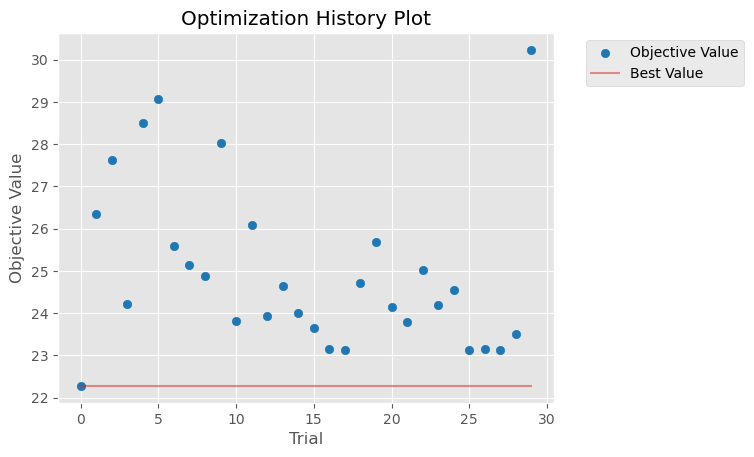

C:\Users\gandj\AppData\Local\Temp\ipykernel_82324\1729246269.py:47: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna_matplotlib.plot_param_importances(study_xgb)


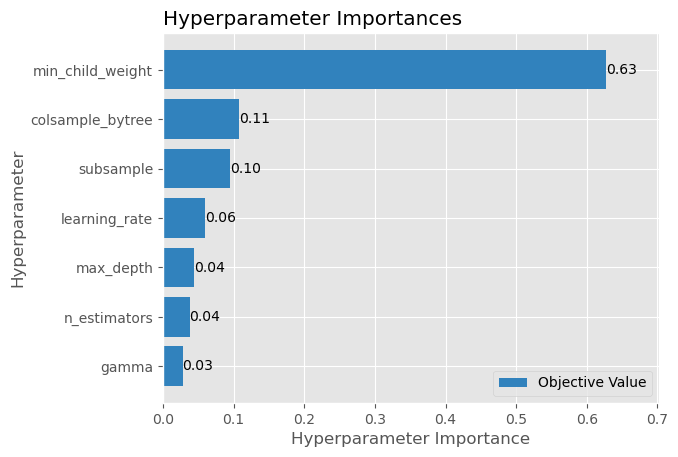

C:\Users\gandj\AppData\Local\Temp\ipykernel_82324\1729246269.py:50: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  optuna_matplotlib.plot_contour(study_xgb,params=['n_estimators','max_depth','min_child_weight','subsample','colsample_bytree','gamma','learning_rate'])
[W 2025-02-21 00:43:23,940] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


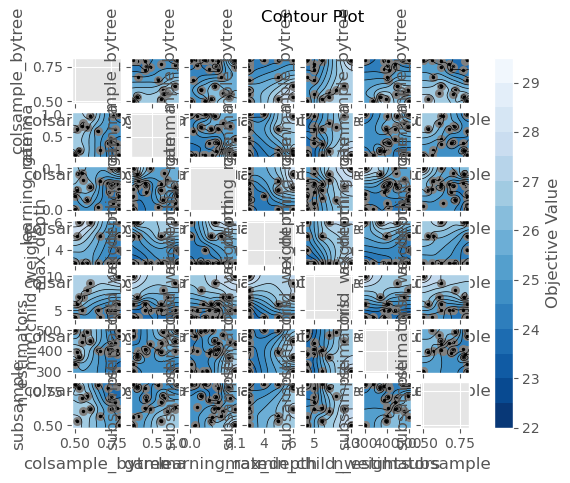

C:\Users\gandj\anaconda3\Lib\site-packages\optuna\trial\_frozen.py:354: UserWarning: The value 0.05749609109994584 of the parameter 'learning_rate' is out of the range of the distribution FloatDistribution(high=0.02, log=False, low=0.005, step=None).
  warnings.warn(


Text(0.5, 1.0, 'Train-Validation for XGBoost Regressor')

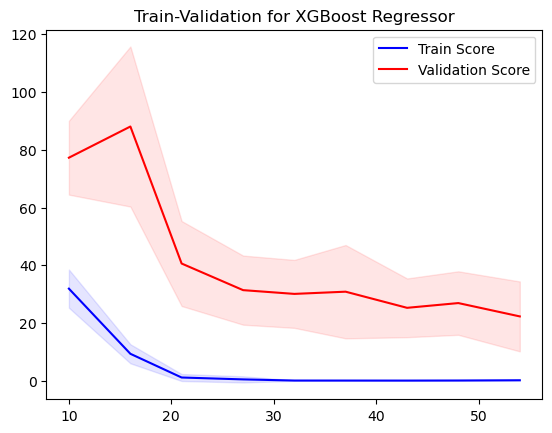

In [92]:
#XGBoost Regression
def create_pipeline_randfor(trial):
    n_estimators=trial.suggest_int('n_estimators',300,500)
    learning_rate=trial.suggest_float('learning_rate',0.001,0.1)
    max_depth=trial.suggest_int('max_depth',3,6)
    min_child_weight=trial.suggest_int('min_child_weight',4,10)
    subsample=trial.suggest_float('subsample',0.5,0.8)
    colsample_bytree=trial.suggest_float('colsample_bytree',0.5,0.8)
    gamma=trial.suggest_float('gamma',0.1,1.0)
    learning_rate=trial.suggest_float('learning_rate',0.005,0.02)

    pipeline=Pipeline(
        [
            ('rare_label',RareCategoryEncoder(feat="Opponent", tolerance=0.05)),
            ('mean_encoder',MeanEncoder(variables=['Opponent'])),
            ('discritization',DecisionTreeDiscretiser(cv=10, scoring="neg_root_mean_squared_error", regression=True, variables=['TD','Int','Sk','# TopReceiver','# TopRunningBacks'],random_state=101)),
            ('feature_select',FeatureSelector(threshold=0.05,random_state=101)),
            ('xgb_model',XGBRegressor(n_estimators=n_estimators,max_depth=max_depth,min_child_weight=min_child_weight,subsample=subsample,colsample_bytree=colsample_bytree,
                                      random_state=101))
        ]
    )
    return pipeline

def objective(trial):
    pipeline=create_pipeline_randfor(trial)
    scores=cross_val_score(pipeline, X_train, y_train,cv=KFold(n_splits=10,shuffle=True,random_state=101),
                           scoring="neg_root_mean_squared_error")
    return -scores.mean()

study_xgb=optuna.create_study(direction='minimize',sampler=GPSampler(seed=101),pruner=SuccessiveHalvingPruner())
start_time=time.time()
study_xgb.optimize(objective,n_trials=30)
end_time=time.time()

print(f"Best trial: {study_xgb.best_trial.params}")
#getting the best score
best_xgb_score=study_xgb.best_trial.value
print(f"Best trial Score (RMSE) for XGBoost: {best_rfr_score}")
print(f'Run Time in Minutes: {(end_time - start_time)/60}')

dict_model_scores['XGBoost_Score']={'Score':best_xgb_score,'RunTime_In_Min':((end_time-start_time)/60)}

plt.figure(figsize=(10,6))
optuna_matplotlib.plot_optimization_history(study_xgb)
plt.show()
print('\n')
optuna_matplotlib.plot_param_importances(study_xgb)
plt.show()
print('\n')
optuna_matplotlib.plot_contour(study_xgb,params=['n_estimators','max_depth','min_child_weight','subsample','colsample_bytree','gamma','learning_rate'])
plt.show()

best_pipeline = Pipeline(
    create_pipeline_randfor(study_xgb.best_trial).steps
)

train_sizes, train_scores, val_scores = learning_curve(best_pipeline, X_train, y_train, train_sizes=np.linspace(0.2,1.0,9),
                                        cv=KFold(n_splits=10,shuffle=True,random_state=101),scoring="neg_root_mean_squared_error",n_jobs=-1)

train_mean=-np.mean(train_scores,axis=1)
train_std=-np.std(train_scores,axis=1)
val_mean=-np.mean(val_scores,axis=1)
val_std=-np.std(val_scores,axis=1)

plt.style.use('default')
plt.plot(train_sizes,train_mean,color='blue',label='Train Score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')

plt.plot(train_sizes,val_mean,color='red',label='Validation Score')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='red')

plt.legend()
plt.title('Train-Validation for XGBoost Regressor')

In [93]:
pd.DataFrame.from_dict(dict_model_scores).transpose()

Score  RunTime_In_Min
Baseline_Model_Score        63.807378        0.071833
Baseline_Model_Score_CV     63.807378        0.419085
Random_Forest_CV_Score      31.719702       12.163745
Random_Forest_Score         28.370312        2.413040
Gradient_Boosting_CV_Score  19.017536       12.296366
Gradient_Boosting_Score     19.427175        2.504254
Kernel_Ridge_CV_Score       30.417853       11.839875
Kernel_Ridge_Score          27.955824        2.000651
XGBoost_CV_Score            28.370312       12.525461
XGBoost_Score               22.277271        2.751136

By comparing all the model scores and running times, one thing becomes clear. The models with the feature selection method using leave_one_out take about six times as long as without, but allow us to get a model that is less likely to under- or over-fit.

As we can see, the best performing model that appears to fit well is the gradient boosting model with the leave_one_out approach to feature selection.
We need to address the fact that it looks like part of the learning_curve of the Gradient Boosting model is missing. We can also get the impression that the validation score is flattening, but it is actually decreasing, the missing part makes it look like it is flattening, but we can observe a decrease in the RMSE of the validation score. Another aspect in favour of the Gradient Boosting model is that both the training score and the validation score operate at a relatively low score level. All the other models may appear to be a better fit, but the training and validation scores remain at a relatively high score level.

Next, we will train the final model using SHAP to show which features are most important and check the final score of the model using MAE (Mean Absolute Error) which makes the error easier to interpret.

## Final Model Performance

In [31]:
final_model=Pipeline(
    [
        ('rare_label',RareCategoryEncoder(feat="Opponent", tolerance=0.05)),
        ('mean_encoder',MeanEncoder(variables=['Opponent'])),
        ('discritization',DecisionTreeDiscretiser(cv=10, scoring="neg_root_mean_squared_error", regression=True, variables=['TD','Int','Sk','# TopReceiver','# TopRunningBacks'],random_state=101)),
        ('feature_select_cv',FeatureSelector_CV(threshold=0.05,random_state=101)),
        ('gbr_model',GradientBoostingRegressor(n_estimators=150,max_depth=6,min_samples_split=20,min_samples_leaf=5,criterion='friedman_mse',
                                               loss='huber',random_state=101))
    ]
).fit(X_train,y_train)

y_pred=final_model.predict(X_test)
final_mae=mean_absolute_error(y_pred,y_test)
final_rmse=root_mean_squared_error(y_pred,y_test)

print(f'MAE: {final_mae}')
print(f'Average Error Ratio of the model: {(final_mae/df["Yds"].mean())*100}%')
print('\n')
print(f'MAE: {final_rmse}')
print(f'Variability Ratio of the model: {(final_rmse/df["Yds"].std())*100}%')

MAE: 13.180569098777731
Average Error Ratio of the model: 5.785955273978106%


MAE: 16.862717561118945
Variability Ratio of the model: 24.81470825687171%


Based on the Average Error Ratio (0%-30% => good) and Variability Ratio (0%-20% => good; 21%-49% => moderate; everything at 50% and above is considered as bad), our model is doing a good job

Number of samples: 11


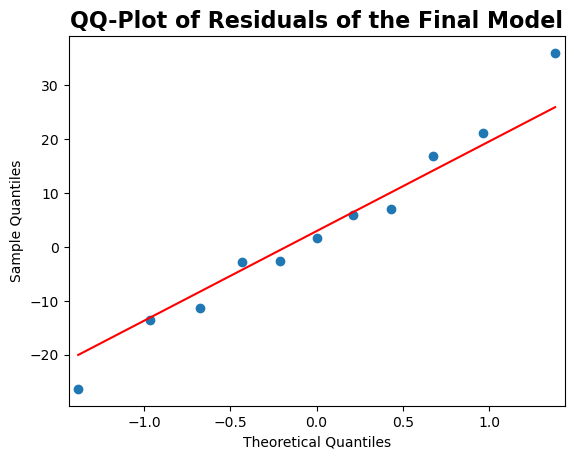

In [32]:
residuals=y_test-y_pred
sm.qqplot(residuals, line="s");
plt.title('QQ-Plot of Residuals of the Final Model',size=16,fontweight='bold')
print(f'Number of samples: {y_test.shape[0]}')

The qq-plot indicates that the residuals are normally distributed, which is important information for creating a prediction range. Another important aspect is the number of samples we are comparing our predictions to, we have 11 samples, therefore we need to use a t-distribution to create the range because the sample is below 30.

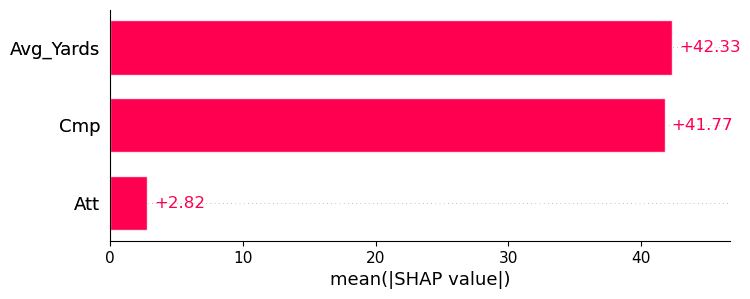

In [33]:
X_train_transformed=final_model[:-1].transform(X_train)
X_test_transformed=final_model[:-1].transform(X_test)

explainer=shap.Explainer(final_model['gbr_model'],X_train_transformed)
shap_values=explainer(X_test_transformed)
shap.plots.bar(shap_values)

shap.plots.bar(shap_values), shows which features have the biggest impact on the model, based on the average absolute SHAP values.

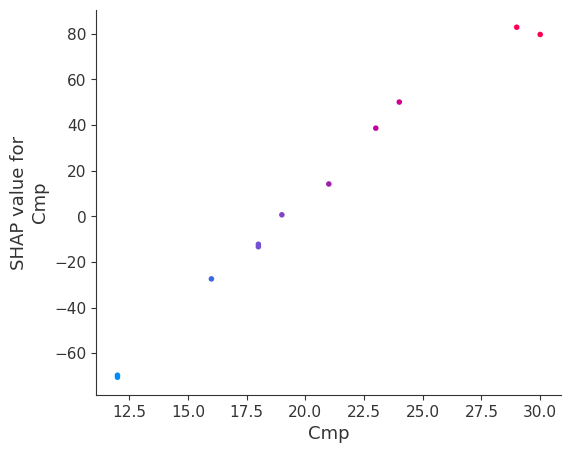

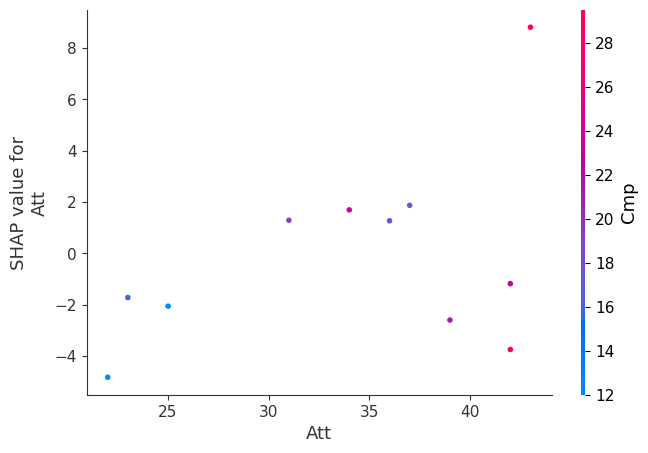

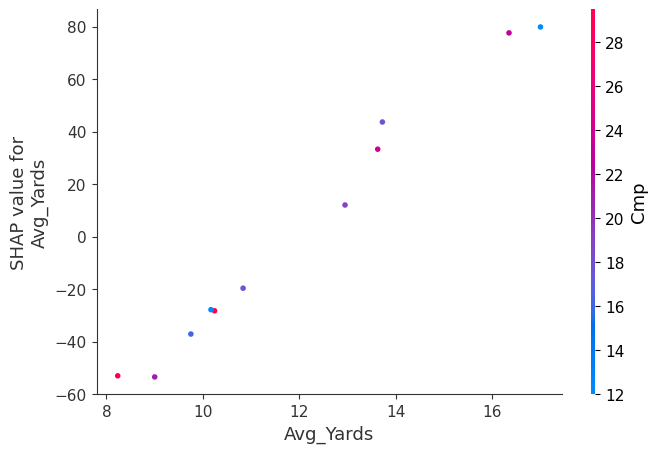

In [34]:
for feature in list(X_train_transformed.columns):
    shap.dependence_plot(feature, shap_values.values, X_test_transformed)

The dependence_plot() shows how every data point of a feature and how it affects the target variable, blue negative impact on teh target variable and red postive.

In [35]:
#required for force plots
shap.initjs()
shap.plots.force(shap_values[0])

In [36]:
shap.plots.force(shap_values[1])

shap.plots.force() allows us to see how all features interact/affect the target variable for each trial, red positive; blue negative

Number of samples: 60


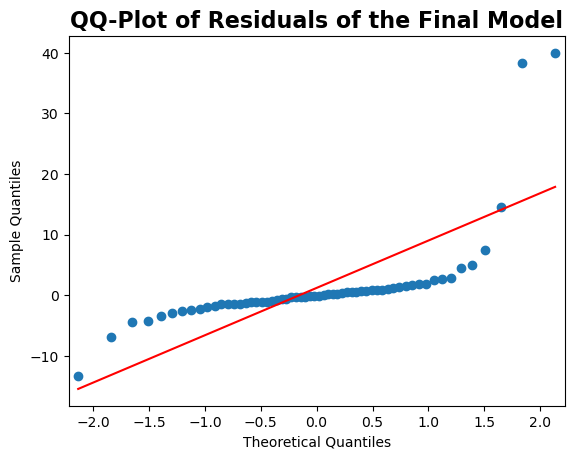

In [55]:
y_pred = final_model.predict(X_train)
residuals = np.array(y_train - y_pred)

sm.qqplot(residuals, line="s");
plt.title('QQ-Plot of Residuals of the Final Model',size=16,fontweight='bold')
print(f'Number of samples: {y_train.shape[0]}')

The residuals of X_train; y_train does not follow a normal distribution, therefore we need to perform a bootstrapping approach to get a representitive prediction range.

In [52]:
# Function to compute bootstrapped prediction intervals
def bootstrap_prediction_interval(y_true, y_pred, num_bootstrap=10000, confidence=0.95):
    residuals = y_true - y_pred  # Compute residuals

    # Bootstrap sampling of residuals
    bootstrap_samples = np.random.choice(residuals, size=(num_bootstrap, len(residuals)), replace=True)
    bootstrap_predictions = np.mean(bootstrap_samples, axis=1)  # Mean error for each bootstrap sample

    # Compute the predicted values for each sample
    bootstrap_pred = np.tile(y_pred, (num_bootstrap, 1)).T + bootstrap_predictions
    
    # Compute the percentile-based prediction intervals
    lower_percentile = (1 - confidence) / 2 * 100
    upper_percentile = (1 + confidence) / 2 * 100
    lower_bound = np.percentile(bootstrap_pred, lower_percentile, axis=0)
    upper_bound = np.percentile(bootstrap_pred, upper_percentile, axis=0)

    return lower_bound, upper_bound

# Link to the game schedule of Tampa Bay with Baker 2023-2024
team_game_status = pd.read_html('https://www.pro-football-reference.com/players/M/MayfBa00/gamelog/2023/')[0]
team_game_status.columns = team_game_status.columns.droplevel()
team_game_status = team_game_status.iloc[:-1, [6, 7]].rename(columns={'Unnamed: 6_level_1': 'Home_Game_Status'})
team_game_status['Home_Game_Status'] = team_game_status['Home_Game_Status'].fillna(1)
team_game_status['Home_Game_Status'] = team_game_status['Home_Game_Status'].replace({'@': 0})
team_game_status['Home_Game_Status'] = team_game_status['Home_Game_Status'].astype(int)

# Train model predictions
y_pred = final_model.predict(X_train)
residuals = np.array(y_train - y_pred)

# Bootstrap prediction intervals
lower_bound, upper_bound = bootstrap_prediction_interval(y_train, y_pred)

# Adding predictions to the list
predict = []
for x in range(len(team_game_status)):
    game, opp = team_game_status.iloc[x, :]
    df_ = pd.read_csv(r"C:\Users\gandj\OneDrive\Desktop\Case_Study\NFL\Baker_DataFrame.csv").iloc[:, 1:]
    df_.rename(columns={'Yds.1': 'Yards_Lost_After_Sack'}, inplace=True)
    df_['Yards_Lost_After_Sack'] = df_['Yards_Lost_After_Sack'] * -1
    df_['Avg_Yards'] = df_['Yds'] / df_['Cmp']
    df_.drop(['Player', 'Tm'], axis=1, inplace=True)

    stats = input_value(df_, opp, game)
    stats.rename(columns={'Yds.1': 'Yards_Lost_After_Sack'}, inplace=True)
    stats['Avg_Yards'] = stats['Yds'] / stats['Cmp']
    stats = stats.drop(['Yds'], axis=1)
    stats = stats.loc[:, list(X_train.columns)]

    pred = final_model.predict(stats)
    predict.append(round(pred[0]))

# Construct final table
table = pd.read_html('https://www.pro-football-reference.com/players/M/MayfBa00/gamelog/2023/')[0]
table.columns = table.columns.droplevel()
table = table.iloc[:-1, 5:]
table['Final_Pred'] = predict
table = table.loc[:, ~table.columns.duplicated()]
table['Diff'] = table['Final_Pred'] - table['Yds'].fillna(0)

# Adding prediction intervals to the table
table['Pred_Range'] = [f'{round(l)} - {round(p)} - {round(u)}' for l, p, u in zip(lower_bound, predict, upper_bound)]
table

Tm Unnamed: 6_level_1  Opp   Result GS  Cmp  Att   Cmp%  Yds  TD  ...  \
0   TAM                  @  MIN  W 20-17  *   21   34  61.76  173   2  ...   
1   TAM                NaN  CHI  W 27-17  *   26   34  76.47  317   1  ...   
2   TAM                NaN  PHI  L 11-25  *   15   25  60.00  146   1  ...   
3   TAM                  @  NOR   W 26-9  *   25   32  78.13  246   3  ...   
4   TAM                NaN  DET   L 6-20  *   19   37  51.35  206   0  ...   
5   TAM                NaN  ATL  L 13-16  *   27   42  64.29  275   1  ...   
6   TAM                  @  BUF  L 18-24  *   25   42  59.52  237   2  ...   
7   TAM                  @  HOU  L 37-39  *   21   30  70.00  265   2  ...   
8   TAM                NaN  TEN   W 20-6  *   18   29  62.07  278   2  ...   
9   TAM                  @  SFO  L 14-27  *   29   45  64.44  246   1  ...   
10  TAM                  @  IND  L 20-27  *   20   30  66.67  199   2  ...   
11  TAM                NaN  CAR  W 21-18  *   14   29  48.28  202   1  ...   
12  TAM                  @  ATL  W 29-25  *   14   29  48.28  144   2  ...   
13  TAM                  @  GNB  W 34-20  *   22   28  78.57  381   4  ...   
14  TAM                NaN  JAX  W 30-12  *   26   35  74.29  283   2  ...   
15  TAM                NaN  NOR  L 13-23  *   22   33  66.67  309   2  ...   
16  TAM                  @  CAR    W 9-0  *   20   32  62.50  137   0  ...   

    Pts  Fmb  FL  FF  FR   Num   Pct  Final_Pred  Diff       Pred_Range  
0     0    0   0   0   0  68.0  100%         155   -18  110 - 155 - 345  
1     0    0   0   0   1  71.0  100%         239   -78  109 - 239 - 344  
2     0    1   0   0   0  47.0  100%         230    84  107 - 230 - 342  
3     0    0   0   0   0  71.0  100%         170   -76  109 - 170 - 344  
4     0    0   0   0   0  56.0  100%         175   -31  109 - 175 - 344  
5     0    1   0   0   1  73.0  100%         217   -58  108 - 217 - 343  
6     0    1   0   0   1  68.0  100%         238     1  109 - 238 - 344  
7     0    0   0   0   0  66.0  100%         357    92  107 - 357 - 342  
8     0    1   0   0   0  64.0   98%         285     7  110 - 285 - 345  
9     0    1   1   0   0  71.0  100%         104  -142  108 - 104 - 343  
10    0    2   1   0   0  58.0   97%         249    50  110 - 249 - 345  
11    0    0   0   0   0  62.0  100%         234    32  107 - 234 - 342  
12    6    0   0   0   0  68.0  100%         217    73  109 - 217 - 344  
13    0    1   1   0   0  62.0  100%         161  -220  110 - 161 - 345  
14    0    0   0   0   0  74.0  100%         259   -24  107 - 259 - 342  
15    0    0   0   0   0  56.0  100%         170  -139  109 - 170 - 344  
16    0    0   0   0   0  65.0  100%         234    97  109 - 234 - 344  

[17 rows x 26 columns]

# Summary

Throughout the project we have analysed the data on its characteristic, and based on that we have selected the appropriate feature selection and engineering methods and after that we have selected best fitting model. The insights what we have gained is that the leave_on_out() approach in the feature selection is very benefical with few data points. The Gradient Boosting model was the best model, which is based on the models characteristic, it can deal well when only a few data points avaiable. This is achieved by sequentially building smaller models, each trained on a subset of the data, and iteratively improving the predictions by correcting the errors of the previous models.

Based on the model's average error and variability ratio, we can say that the model is doing a good job.

However, we also have to consider the limitations of the model, which at times has high variability/relatively low accuracy, but this can be attributed to the small number of data points. Having seen two seasons of Baker in Tampa Bay, it also has something to do with a better fitting offensive scheme and better offensive weapons like running backs and wide receivers.

For future projects, more recent data can be included and the model retrained to see if this improves the model's performance.